ID 1: 207701426
<br>
ID 2: 209321553

# Loading Libraries


In this proposed work, we aim to conduct a classification task on defualts of credit card clients utilizing a dataset comprised of 30000 instances 25 features of personal data and financial data.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import random
from itertools import combinations, product
import itertools

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.model_selection import cross_val_score, KFold,train_test_split,cross_val_predict
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.decomposition import PCA

from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, roc_curve,roc_auc_score
from sklearn.svm import SVC

from tabulate import tabulate
from sklearn.base import clone

import warnings
import time

# Loading the data

In [7]:
df=pd.read_csv("C:/Users/amitr/Desktop/ML/Final_Project_ML_2024/Final_Project/default/default of credit card clients.csv")

## Variable Descriptions

| Column Name | Description                                                     |
|-------------|-----------------------------------------------------------------|
| X1          | Amount of the given credit (NT dollar)                           |
| X2          | Gender (1 = male; 2 = female)                                   |
| X3          | Education (1 = graduate school; 2 = university; 3 = high school; 4 = others) |
| X4          | Marital status (1 = married; 2 = single; 3 = others)             |
| X5          | Age (year)                                                      |
| X6 - X11    | History of past payment. The repayment status from April to September, 2005. Scale: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above |
| X12 - X17   | Amount of bill statement (NT dollar). Bill statements from April to September, 2005 |
| X18 - X23   | Amount of previous payment (NT dollar). Previous payments from April to September, 2005 |

In this research, the binary variable "default payment" (Yes = 1, No = 0) is used as the response variable, and the above 23 variables are used as explanatory variables.


**Full Disclosure:**
<br>
The chat assistance was invaluable in crafting all the necessary docstrings and creating the graphs.

### Reorganizing Data Chronologically in a DataFrame

In [8]:
"""
This code shifts the values of payment status, bill amounts, and payment amounts in reverse order, 
allowing the data to reflect a chronological sequence. By creating temporary columns, transferring values, 
and dropping unnecessary columns, the code ensures that the most recent data appears in the respective columns. 
This reordering can be beneficial for analyzing and modeling temporal patterns in the data.
"""

df['pay_1']=df['PAY_6']
df['pay_2']=df['PAY_5']
df['pay_3']=df['PAY_4']
df['pay_4']=df['PAY_3']
df['pay_5']=df['PAY_2']
df['pay_6']=df['PAY_0']

df['PAY_0']=df['pay_1']
df['PAY_2']=df['pay_2']
df['PAY_3']=df['pay_3']
df['PAY_4']=df['pay_4']
df['PAY_5']=df['pay_5']
df['PAY_6']=df['pay_6']

df = df.drop(columns=['pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6'])
df.rename(columns={'PAY_0': 'PAY_1'}, inplace=True)


df['bill_amt_1'] = df['BILL_AMT6']
df['bill_amt_2'] = df['BILL_AMT5']
df['bill_amt_3'] = df['BILL_AMT4']
df['bill_amt_4'] = df['BILL_AMT3']
df['bill_amt_5'] = df['BILL_AMT2']
df['bill_amt_6'] = df['BILL_AMT1']

df['BILL_AMT1'] = df['bill_amt_1']
df['BILL_AMT2'] = df['bill_amt_2']
df['BILL_AMT3'] = df['bill_amt_3']
df['BILL_AMT4'] = df['bill_amt_4']
df['BILL_AMT5'] = df['bill_amt_5']
df['BILL_AMT6'] = df['bill_amt_6']

df = df.drop(columns=['bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6'])

df['pay_amt_1'] = df['PAY_AMT6']
df['pay_amt_2'] = df['PAY_AMT5']
df['pay_amt_3'] = df['PAY_AMT4']
df['pay_amt_4'] = df['PAY_AMT3']
df['pay_amt_5'] = df['PAY_AMT2']
df['pay_amt_6'] = df['PAY_AMT1']

df['PAY_AMT1'] = df['pay_amt_1']
df['PAY_AMT2'] = df['pay_amt_2']
df['PAY_AMT3'] = df['pay_amt_3']
df['PAY_AMT4'] = df['pay_amt_4']
df['PAY_AMT5'] = df['pay_amt_5']
df['PAY_AMT6'] = df['pay_amt_6']

df = df.drop(columns=['pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6'])

Upon further examination of the data, we have discovered that the bill amount recorded in a given month actually corresponds to the following month in the pay amount. In other words, there is a time lag of a months between the payment amount (pay_amt) and the billed amount (bill_amt) for a specific month. For example, bill_amt1 represents the customer's charges for the month of April while the amount he paid will appear in pay_amnt2 belonging to the month of May. Therefore it is important to note that we do not know for pay_amt1 what his "debt" was (bill_amnt of March which does not appear in the data) and for bill_amnt6 we do not know how much was returned in the following month (pay_amnt of October which does not also appear in the data).

In [9]:
print(df.iloc[70:71,6:12])
print(df.iloc[70:71,12:18])
print(df.iloc[70:71,18:24])

    PAY_1  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6
70     -1     -1     -1     -1     -1     -1
    BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6
70        390        390        390        390          0        780
    PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6
70       390       390       390       390       390         0


In [10]:
df.shape

(30000, 25)

In [11]:
df.head()

ID  LIMIT_BAL     SEX   EDUCATION MARRIAGE  AGE  PAY_1  PAY_2  PAY_3  \
0   1      20000  female  university  married   24     -2     -2     -1   
1   2     120000  female  university   single   26      2      0      0   
2   3      90000  female  university   single   34      0      0      0   
3   4      50000  female  university  married   37      0      0      0   
4   5      50000    male  university  married   57      0      0      0   

   PAY_4  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0     -1  ...        689       3102       3913         0         0         0   
1      0  ...       2682       1725       2682      2000         0      1000   
2      0  ...      13559      14027      29239      5000      1000      1000   
3      0  ...      49291      48233      46990      1000      1069      1100   
4     -1  ...      35835       5670       8617       679       689      9000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  DEFAULT  
0         0       689         0        1  
1      1000      1000         0        1  
2      1000      1500      1518        0  
3      1200      2019      2000        0  
4     10000     36681      2000        0  

[5 rows x 25 columns]

# Data Cleaning

In [12]:
df=df.rename(columns=str.lower)

drop some features which are not informative

In [13]:
df = df.drop(['id'],axis=1)

### Check for missing values

In [14]:
na_percent = {}

for column in df.columns:
    if column == 'id':
        continue
    na_count = df[column].isna().sum()
    na_percent[column] = (na_count / len(df)) * 100

sorted_na_percent = {column: na_percent for column, na_percent in sorted(na_percent.items(), key=lambda x: x[1], reverse=True)}

print("Missing Values Percentage by Column:")
for column, na_percent in sorted_na_percent.items():
    if na_percent > 0:
        column_na_count = df[column].isna().sum()
        print(f"\033[91m{column}: {na_percent:.2f}% Na Percent (Count: {column_na_count})\033[0m")
    else:
        print(f"{column}: {na_percent:.2f}% Na Percent")


Missing Values Percentage by Column:
marriage: 0.18% Na Percent (Count: 54)
education: 0.05% Na Percent (Count: 14)
limit_bal: 0.00% Na Percent
sex: 0.00% Na Percent
age: 0.00% Na Percent
pay_1: 0.00% Na Percent
pay_2: 0.00% Na Percent
pay_3: 0.00% Na Percent
pay_4: 0.00% Na Percent
pay_5: 0.00% Na Percent
pay_6: 0.00% Na Percent
bill_amt1: 0.00% Na Percent
bill_amt2: 0.00% Na Percent
bill_amt3: 0.00% Na Percent
bill_amt4: 0.00% Na Percent
bill_amt5: 0.00% Na Percent
bill_amt6: 0.00% Na Percent
pay_amt1: 0.00% Na Percent
pay_amt2: 0.00% Na Percent
pay_amt3: 0.00% Na Percent
pay_amt4: 0.00% Na Percent
pay_amt5: 0.00% Na Percent
pay_amt6: 0.00% Na Percent
default: 0.00% Na Percent


Later we will fill in the missing values and examine the effect of the completion on the model.

### Target Variable

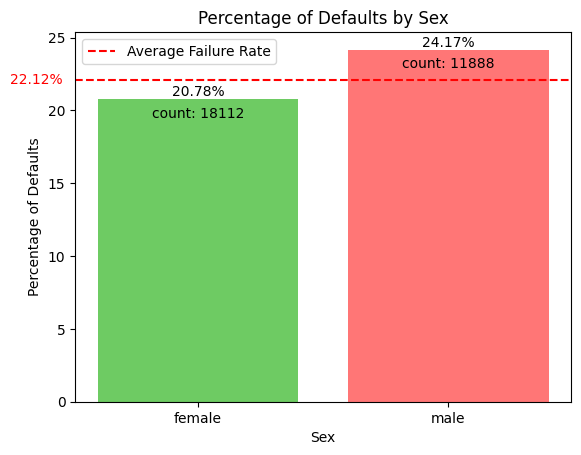

In [15]:
colors = ['#6ECB63', '#FF7676']  # Replace with your desired colors

default_percentage = df.groupby('sex')['default'].mean() * 100

plt.bar(default_percentage.index, default_percentage.values, color=colors)

plt.xlabel('Sex')
plt.ylabel('Percentage of Defaults')
plt.title('Percentage of Defaults by Sex')

# Add labels for percentage and count
total_counts = df['sex'].value_counts()
for i, (index, value) in enumerate(default_percentage.items()):
    count = total_counts[index]
    plt.text(i, value, f'{value:.2f}%', ha='center', va='bottom')
    plt.text(i, value - 0.5, f'count: {count}', ha='center', va='top', color='black')

average_failure_rate = df['default'].mean() * 100
plt.axhline(average_failure_rate, color='red', linestyle='--', label='Average Failure Rate')

plt.legend()

# Add label for the red line value on the y-axis
plt.text(-0.75, average_failure_rate, f'{average_failure_rate:.2f}%', color='red', va='center')

plt.show()


It is evident that the target variable, which represents the default status, exhibits class imbalance. Class imbalance occurs when the distribution of classes within the target variable is disproportionate, posing challenges for model performance. In this case, the imbalanced nature of the target variable can adversely affect the model's ability to accurately identify and predict instances of the minority class, which are the cases that have significant impact on our business. As a result, relying solely on accuracy or recall metrics can be unreliable. Therefore, when evaluating the model, we will account for this factor and explore methods to address the class imbalance, such as adjusting the threshold or assigning appropriate weights to the classes. By examining the impact of imbalance on the model, we can gain insights into its performance and make informed decisions to mitigate potential issues.

### Overview on the data

In [16]:
df.describe()

limit_bal           age         pay_1         pay_2         pay_3  \
count    30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean    167484.322667     35.485500     -0.291100     -0.266200     -0.220667   
std     129747.661567      9.217904      1.149988      1.133187      1.169139   
min      10000.000000     21.000000     -2.000000     -2.000000     -2.000000   
25%      50000.000000     28.000000     -1.000000     -1.000000     -1.000000   
50%     140000.000000     34.000000      0.000000      0.000000      0.000000   
75%     240000.000000     41.000000      0.000000      0.000000      0.000000   
max    1000000.000000     79.000000      8.000000      8.000000      8.000000   

              pay_4         pay_5         pay_6      bill_amt1      bill_amt2  \
count  30000.000000  30000.000000  30000.000000   30000.000000   30000.000000   
mean      -0.166200     -0.133767     -0.016700   38871.760400   40311.400967   
std        1.196868      1.197186      1.123802   59554.107537   60797.155770   
min       -2.000000     -2.000000     -2.000000 -339603.000000  -81334.000000   
25%       -1.000000     -1.000000     -1.000000    1256.000000    1763.000000   
50%        0.000000      0.000000      0.000000   17071.000000   18104.500000   
75%        0.000000      0.000000      0.000000   49198.250000   50190.500000   
max        8.000000      8.000000      8.000000  961664.000000  927171.000000   

       ...     bill_amt4      bill_amt5      bill_amt6       pay_amt1  \
count  ...  3.000000e+04   30000.000000   30000.000000   30000.000000   
mean   ...  4.701315e+04   49179.075167   51223.330900    5215.502567   
std    ...  6.934939e+04   71173.768783   73635.860576   17777.465775   
min    ... -1.572640e+05  -69777.000000 -165580.000000       0.000000   
25%    ...  2.666250e+03    2984.750000    3558.750000     117.750000   
50%    ...  2.008850e+04   21200.000000   22381.500000    1500.000000   
75%    ...  6.016475e+04   64006.250000   67091.000000    4000.000000   
max    ...  1.664089e+06  983931.000000  964511.000000  528666.000000   

            pay_amt2       pay_amt3      pay_amt4      pay_amt5  \
count   30000.000000   30000.000000   30000.00000  3.000000e+04   
mean     4799.387633    4826.076867    5225.68150  5.921163e+03   
std     15278.305679   15666.159744   17606.96147  2.304087e+04   
min         0.000000       0.000000       0.00000  0.000000e+00   
25%       252.500000     296.000000     390.00000  8.330000e+02   
50%      1500.000000    1500.000000    1800.00000  2.009000e+03   
75%      4031.500000    4013.250000    4505.00000  5.000000e+03   
max    426529.000000  621000.000000  896040.00000  1.684259e+06   

            pay_amt6       default  
count   30000.000000  30000.000000  
mean     5663.580500      0.221200  
std     16563.280354      0.415062  
min         0.000000      0.000000  
25%      1000.000000      0.000000  
50%      2100.000000      0.000000  
75%      5006.000000      0.000000  
max    873552.000000      1.000000  

[8 rows x 21 columns]

From the statistical summary, we observe that the average credit limit (limit_bal) is approximately 167,484 units. The average age of the clients is around 35 years. The bill amounts (bill_amt1 to bill_amt6) and payment amounts (pay_amt1 to pay_amt6) exhibit a wide range of values with varying means and standard deviations.
Regarding the target variable, the dataset shows that approximately 22.1% of clients defaulted on their credit card payment, while the majority (77.9%) did not default.


In [17]:
numeric_df = df.select_dtypes(include=['number'])
print(numeric_df.corr())

           limit_bal       age     pay_1     pay_2     pay_3     pay_4  \
limit_bal   1.000000  0.144713 -0.235195 -0.249411 -0.267460 -0.286123   
age         0.144713  1.000000 -0.048773 -0.053826 -0.049722 -0.053048   
pay_1      -0.235195 -0.048773  1.000000  0.816900  0.716449  0.632684   
pay_2      -0.249411 -0.053826  0.816900  1.000000  0.819835  0.686775   
pay_3      -0.267460 -0.049722  0.716449  0.819835  1.000000  0.777359   
pay_4      -0.286123 -0.053048  0.632684  0.686775  0.777359  1.000000   
pay_5      -0.296382 -0.050148  0.575501  0.622780  0.662067  0.766552   
pay_6      -0.271214 -0.039447  0.474553  0.509426  0.538841  0.574245   
bill_amt1   0.290389  0.047613  0.285091  0.262509  0.239154  0.222327   
bill_amt2   0.295562  0.049345  0.290894  0.269783  0.242902  0.225145   
bill_amt3   0.293988  0.051353  0.266356  0.271915  0.245917  0.227202   
bill_amt4   0.283236  0.053710  0.241181  0.243335  0.244983  0.227494   
bill_amt5   0.278314  0.054283  0.2269

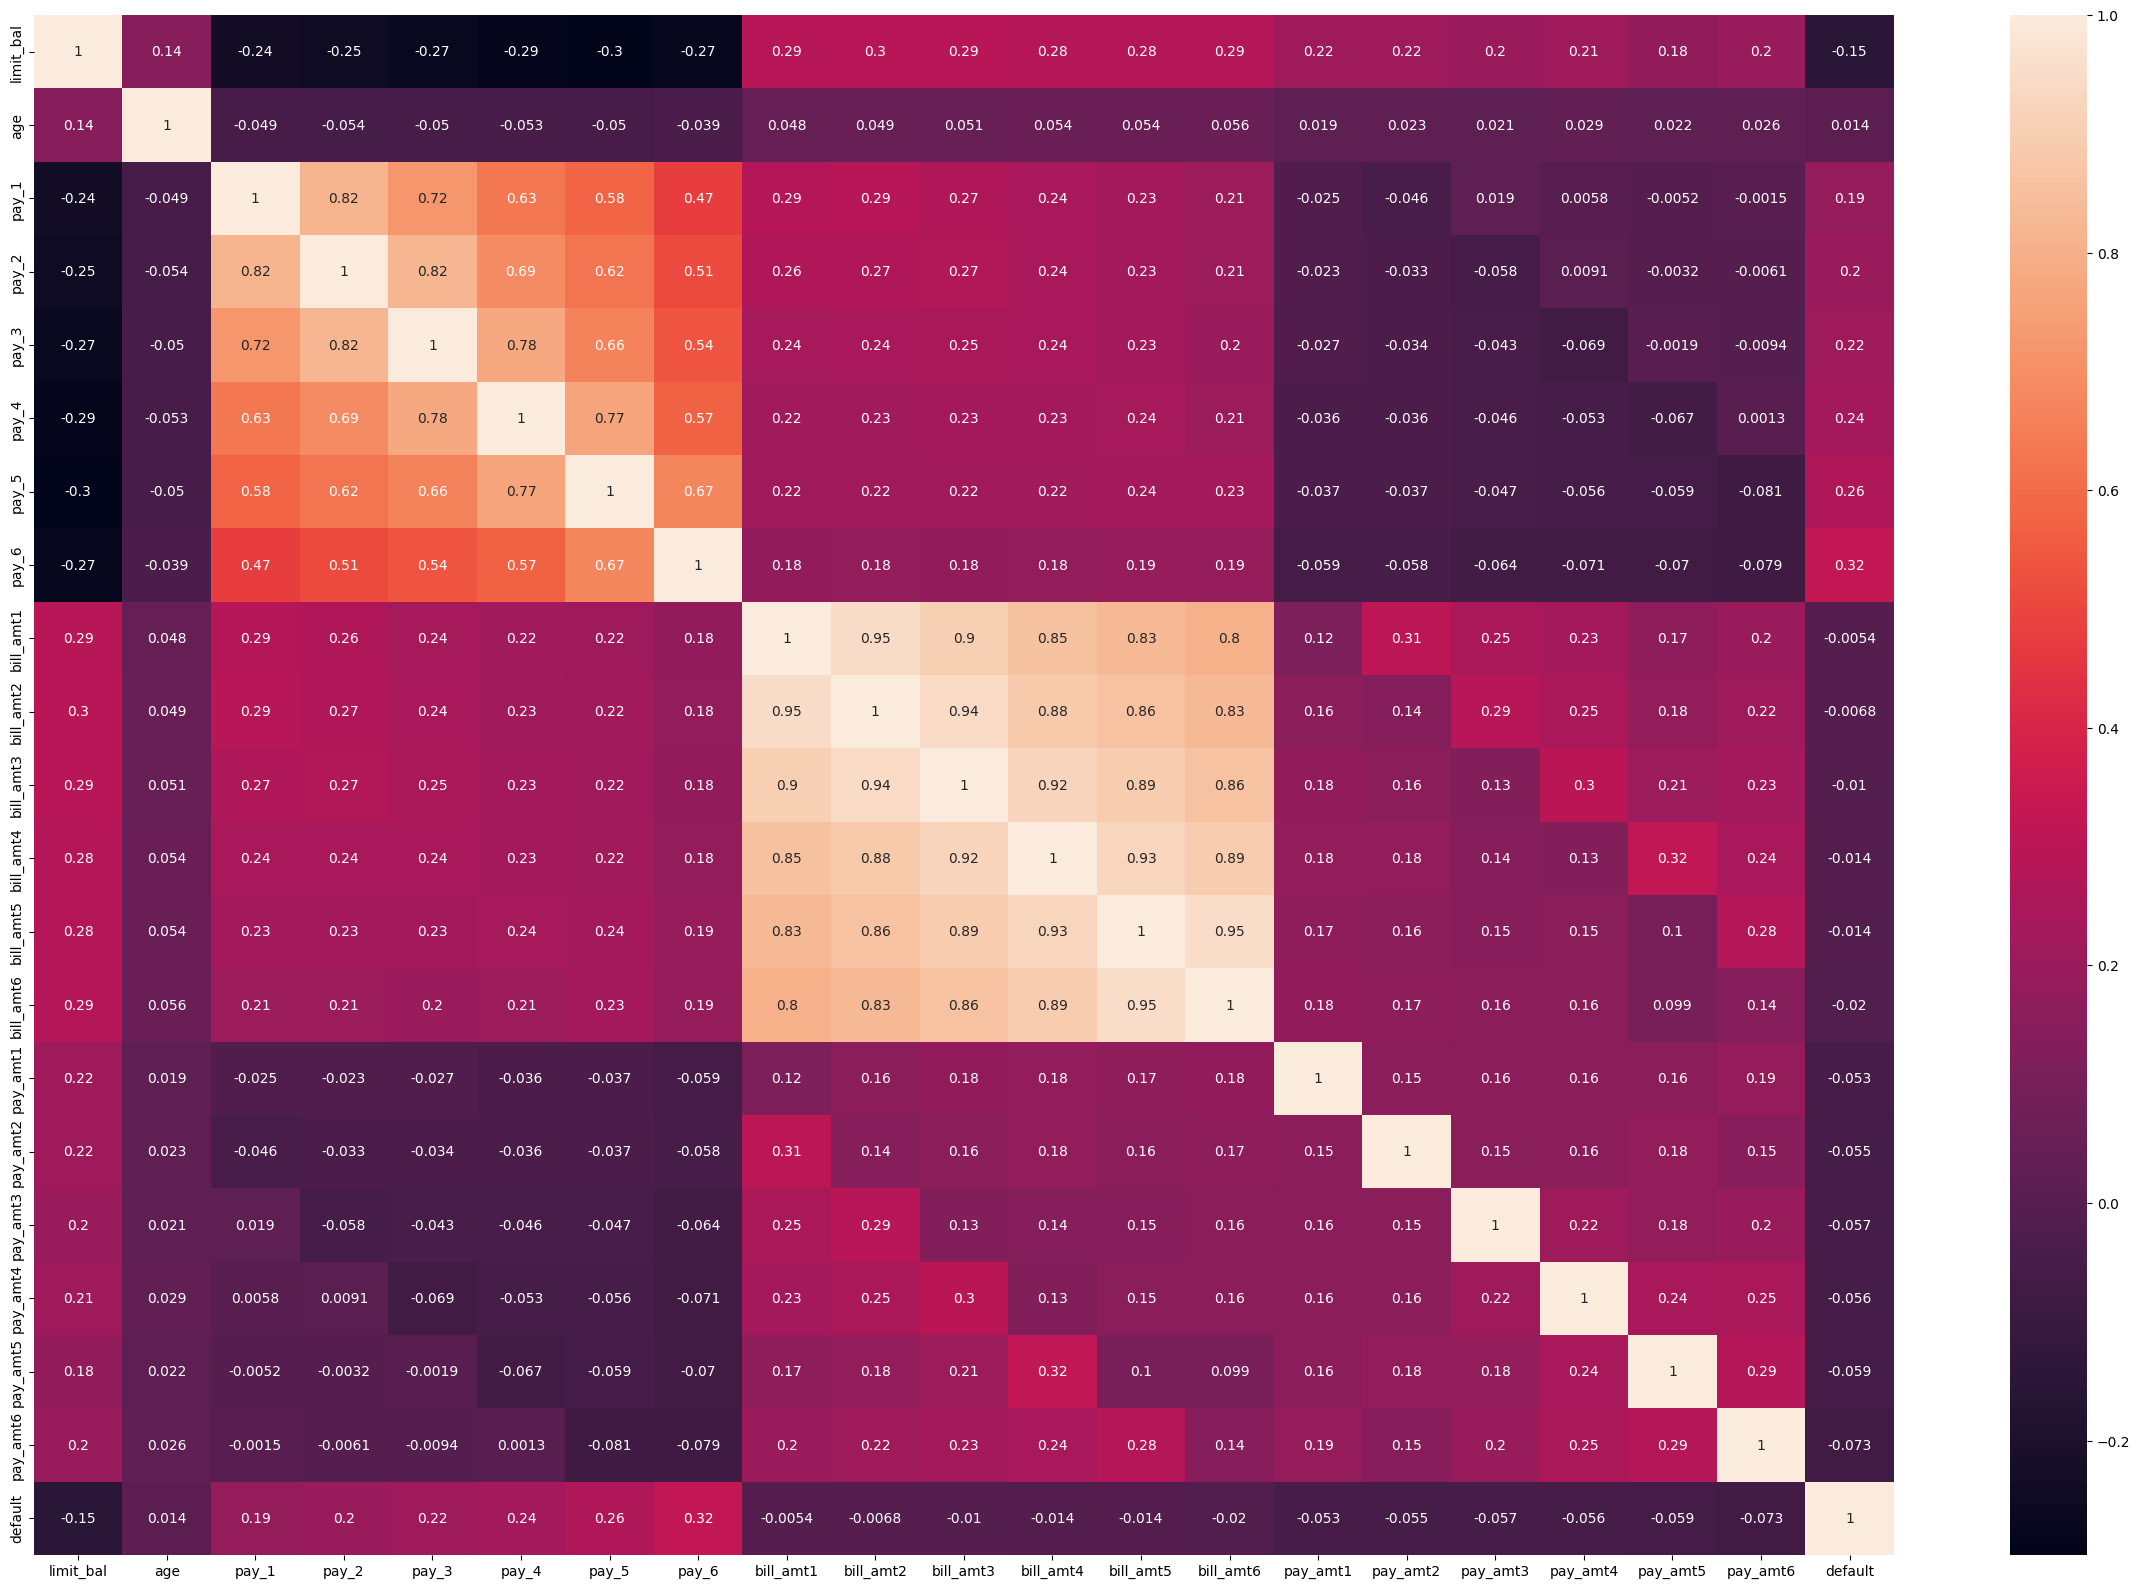

In [20]:
df_numeric = df.select_dtypes(include=['number'])

plt.subplots(figsize=(30, 20))
sns.heatmap(df_numeric.corr(), annot=True)
plt.show()

The **"limit_bal"** variable (credit limit) has a moderately positive correlation with "age" and a negative correlation with "default" (the target variable). This suggests that higher credit limits are associated with older individuals and a lower likelihood of default.
<br>
The **"pay_X"** variables (repayment status) show positive correlations with each other. This indicates that individuals who had a delayed payment in one month were likely to have delayed payments in the following months as well.
<br>
The **"bill_amtX"** variables (bill amounts) exhibit positive correlations with each other, indicating that higher bill amounts in one month are associated with higher bill amounts in subsequent months.
<br>
The **"pay_amtX"** variables (payment amounts) have weak to moderate positive correlations with "bill_amtX" variables. This suggests that individuals who had higher bill amounts tended to make higher payment amounts.
<br>
The **"default"** variable (whether the individual defaulted) shows positive correlations with the "pay_X" variables, indicating that individuals with a history of delayed payments were more likely to default.

### Analysis of Credit Card Default Dataset Variables

**Limit_bal**

C:\Users\amitr\AppData\Local\Temp\ipykernel_19076\2768854618.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(grouper).default.mean().plot.bar()


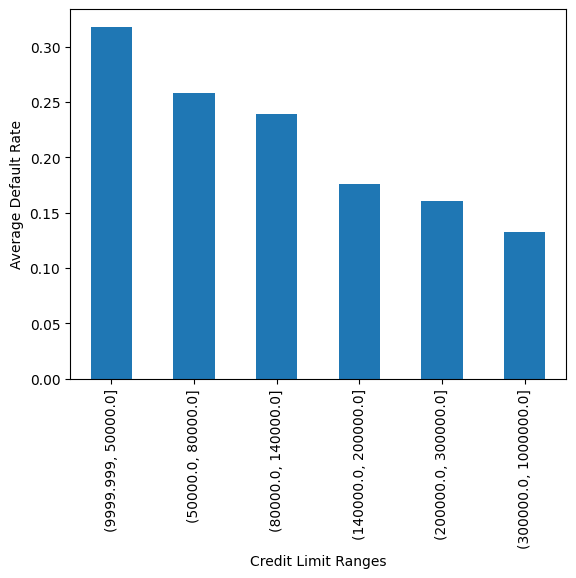

In [21]:
number_of_bins = 6
grouper = pd.qcut(df.limit_bal, number_of_bins)
df.groupby(grouper).default.mean().plot.bar()

plt.xlabel('Credit Limit Ranges')
plt.ylabel('Average Default Rate')

plt.show()

It can be observed that the average default rate is higher when the credit limit is lower.


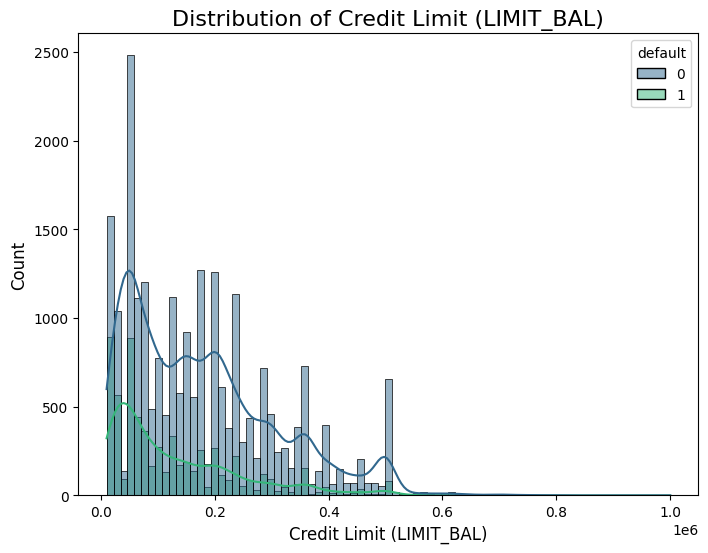

In [22]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='limit_bal', hue=df.default, kde=True, palette='viridis')
plt.title('Distribution of Credit Limit (LIMIT_BAL)', fontsize=16)
plt.xlabel('Credit Limit (LIMIT_BAL)', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

As the credit limit increases, the number of defaulters decreases. Individuals with low credit limits are more likely to default.

**Sex**

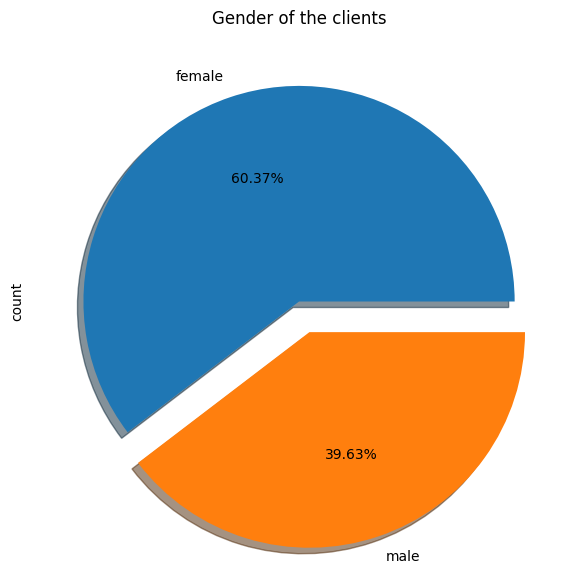

In [23]:
plt.figure(figsize = [7, 7], clear = True, facecolor = "#FFFFFF")
plt.title("Gender of the clients")
df["sex"].value_counts().plot.pie(explode = [0, 0.15], autopct = '%1.2f%%', shadow = True);

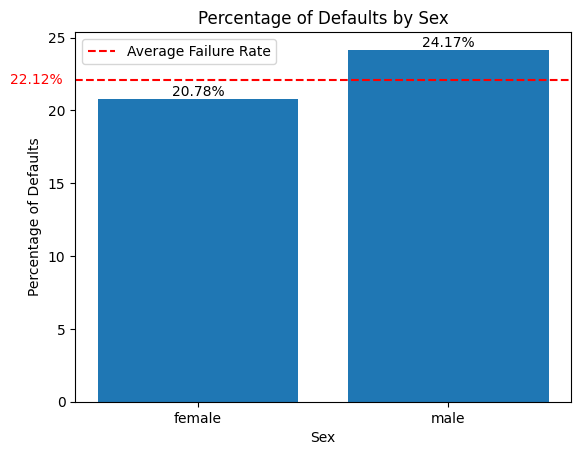

In [24]:
default_percentage = df.groupby('sex')['default'].mean() * 100

plt.bar(default_percentage.index, default_percentage.values)

plt.xlabel('Sex')
plt.ylabel('Percentage of Defaults')
plt.title('Percentage of Defaults by Sex')

for i, value in enumerate(default_percentage.values):
    plt.text(i, value, f'{value:.2f}%', ha='center', va='bottom')

average_failure_rate = df['default'].mean() * 100
plt.axhline(average_failure_rate, color='red', linestyle='--', label='Average Failure Rate')

plt.legend()

# Add label for the red line value on the y-axis
plt.text(-0.75, average_failure_rate, f'{average_failure_rate:.2f}%', color='red', va='center')

plt.show()


Although there are 20% more females in the dataset, the percentage of defaulters is higher among men. Men are more likely to default.

C:\Users\amitr\AppData\Local\Temp\ipykernel_19076\2122606236.py:1: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#00FFFF'` for the same effect.

  sns.catplot(x = "sex",


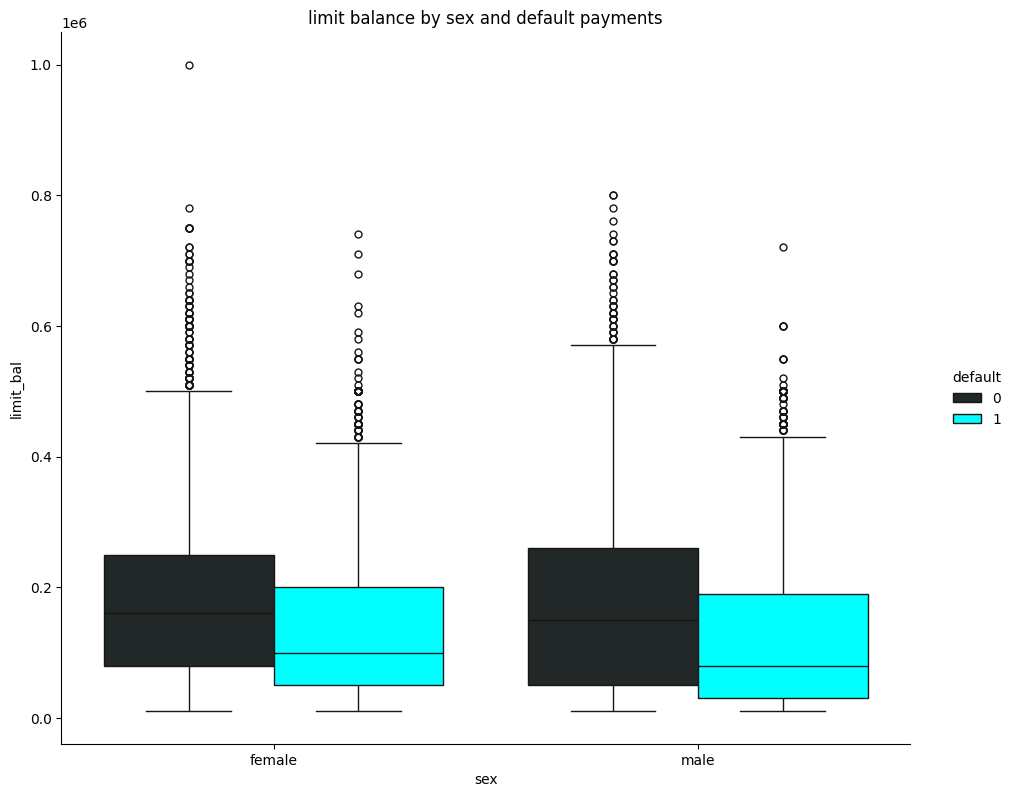

In [25]:
sns.catplot(x = "sex",
            y = "limit_bal",
            kind = "box",
            hue = "default",
            color = '#00FFFF',
            data = df, saturation = 1, height = 8, aspect = 1.2,
            margin_titles = True).set(title = "limit balance by sex and default payments");

The average credit limit for females is slightly higher, including those who default.


**Education**

In [26]:
df['education'].value_counts()

education
university         14030
graduate school    10585
high school         4917
unknown              331
others               123
Name: count, dtype: int64

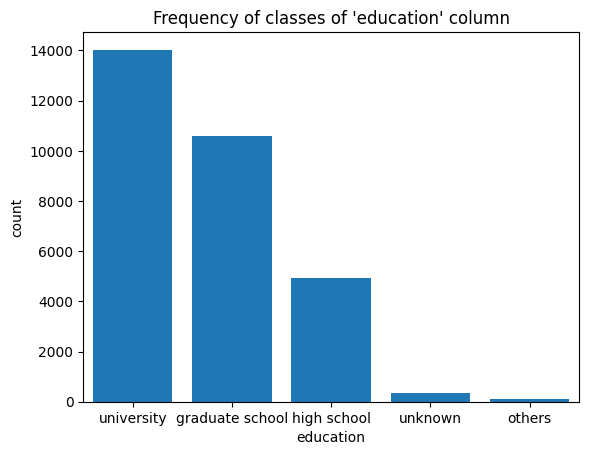

In [28]:
sns.barplot(x=df["education"].value_counts().index,
            y=df["education"].value_counts(), saturation=1)
plt.title("Frequency of classes of 'education' column")
plt.show()

In [29]:
df.groupby('education')['default'].mean()

education
graduate school    0.192348
high school        0.251576
others             0.056911
university         0.237349
unknown            0.078550
Name: default, dtype: float64

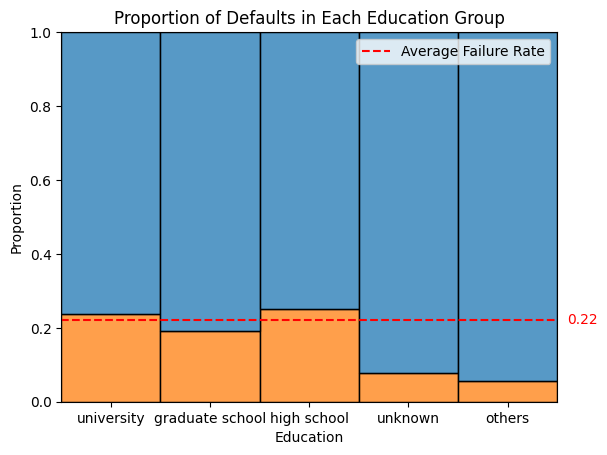

In [30]:
age_group_counts = df.groupby('education')['default'].mean()

sns.histplot(df, x='education', hue='default', multiple='fill')

plt.xlabel('Education')
plt.ylabel('Proportion')
plt.title('Proportion of Defaults in Each Education Group')

average_failure_rate = df['default'].mean()
plt.axhline(average_failure_rate, color='red', linestyle='--', label='Average Failure Rate')

plt.legend()

# Add label for the red line value on the y-axis
plt.text(4.6, average_failure_rate, f'{average_failure_rate:.2f}', color='red', va='center')

plt.show()


We can see that people with high school education has the highest chance to default.
In addition, you can see that there was already some data cleaning here - there is the unknown category (apparently no information was given) and the (other) category.
We will treat the unknown category as a missing value and later we will fill it in.

In [31]:
df['education'].replace('unknown', np.nan, inplace=True)

C:\Users\amitr\AppData\Local\Temp\ipykernel_19076\3287279457.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['education'].replace('unknown', np.nan, inplace=True)


**Marriage**

In [32]:
df['marriage'].value_counts()

marriage
single     15964
married    13659
others       323
Name: count, dtype: int64

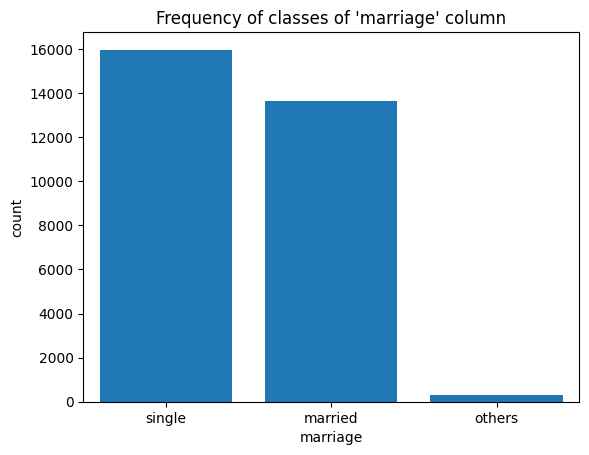

In [34]:
sns.barplot(x=df["marriage"].value_counts().index,
            y=df["marriage"].value_counts(), saturation=1)
plt.title("Frequency of classes of 'marriage' column")
plt.show()

In [35]:
df.groupby('marriage')['default'].mean()

marriage
married    0.234717
others     0.260062
single     0.209283
Name: default, dtype: float64

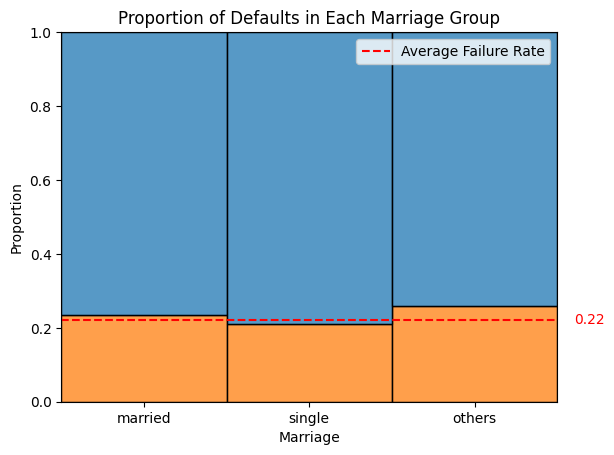

In [36]:
marriage_group_counts = df.groupby('marriage')['default'].mean()

sns.histplot(df, x='marriage', hue='default', multiple='fill')

plt.xlabel('Marriage')
plt.ylabel('Proportion')
plt.title('Proportion of Defaults in Each Marriage Group')

average_failure_rate = df['default'].mean()
plt.axhline(average_failure_rate, color='red', linestyle='--', label='Average Failure Rate')

plt.legend()

# Add label for the red line value on the y-axis
plt.text(2.6, average_failure_rate, f'{average_failure_rate:.2f}', color='red', va='center')

plt.show()


Because the proportion of the default in each unique category is very close, we think that alone this feature will not add value to the model.

**Age**

<Axes: xlabel='age'>

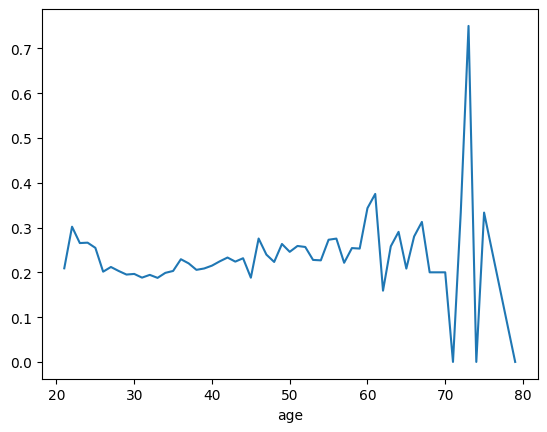

In [37]:
df.groupby('age').default.mean().plot()

It appears that individuals aged between 70 and 73 have a higher probability of defaulting. However, it is possible that there are very few instances within this age range, and a majority of them default. Let's further investigate to validate this observation.

In [38]:
len(df[(df['age'] >= 70) & (df['age'] <= 73)]['default'])

20

There are  only 20 instances in the dataset where the age falls between 70 and 73 as we suspected

In [39]:
print(f"There are only 20 instances in the dataset where the age falls between 70 and 73 as we suspected and {np.sum(df[(df['age'] >= 70) & (df['age'] <= 73)]['default'])/len(df[(df['age'] >= 70) & (df['age'] <= 73)]['default'])*100}% Make default")

There are only 20 instances in the dataset where the age falls between 70 and 73 as we suspected and 30.0% Make default


In [40]:
print(f"There are only 20 instances in the dataset where the age falls between 70 and 79 as we suspected and {np.sum(df[(df['age'] >= 70) & (df['age'] <= 79)]['default'])/len(df[(df['age'] >= 70) & (df['age'] <= 79)]['default'])*100}% Make default")

There are only 20 instances in the dataset where the age falls between 70 and 79 as we suspected and 28.000000000000004% Make default


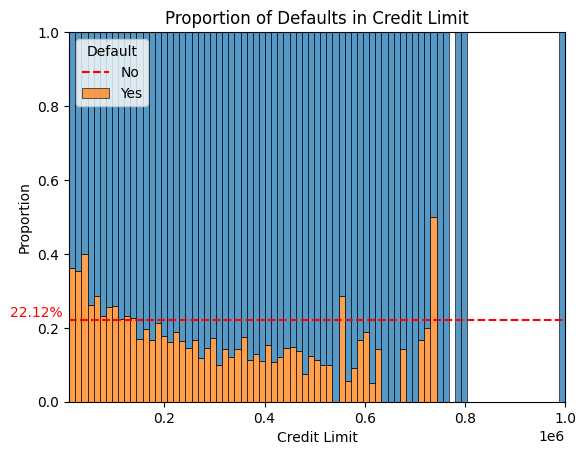

In [41]:
age_group_counts = df.groupby('limit_bal')['default'].mean()

sns.histplot(df, x='limit_bal', hue='default', multiple='fill')

plt.xlabel('Credit Limit')
plt.ylabel('Proportion')
plt.title('Proportion of Defaults in Credit Limit')

average_failure_rate = df['default'].mean()

plt.axhline(average_failure_rate, color='red', linestyle='--', label='Average Failure Rate')
plt.text(-3000, average_failure_rate, f'{average_failure_rate*100:.2f}%', color='red', ha='right', va='bottom')

plt.legend(title='Default', labels=['No', 'Yes'])  # Display legend with labels

plt.show()

**Pay Columns**

In [42]:
pays=['pay_1','pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
for pay in pays:
    print(pay,":")
    print(df[pay].value_counts())
    print("---------------------------")

pay_1 :
pay_1
 0    16286
-1     5740
-2     4895
 2     2766
 3      184
 4       49
 7       46
 6       19
 5       13
 8        2
Name: count, dtype: int64
---------------------------
pay_2 :
pay_2
 0    16947
-1     5539
-2     4546
 2     2626
 3      178
 4       84
 7       58
 5       17
 6        4
 8        1
Name: count, dtype: int64
---------------------------
pay_3 :
pay_3
 0    16455
-1     5687
-2     4348
 2     3159
 3      180
 4       69
 7       58
 5       35
 6        5
 1        2
 8        2
Name: count, dtype: int64
---------------------------
pay_4 :
pay_4
 0    15764
-1     5938
-2     4085
 2     3819
 3      240
 4       76
 7       27
 6       23
 5       21
 1        4
 8        3
Name: count, dtype: int64
---------------------------
pay_5 :
pay_5
 0    15730
-1     6050
 2     3927
-2     3782
 3      326
 4       99
 1       28
 5       25
 7       20
 6       12
 8        1
Name: count, dtype: int64
---------------------------
pay_6 :
pay_6
 0    1473

We need to investigate the variables pay_X to understand the meaning of the categories 0 and -2, which are not described in the data dictionary.
<br>


**pay_X== -2**

In [43]:
for pay in pays:
    con_count = (df[pay] == -2).sum()
    con_per = round(con_count / df.shape[0] * 100, 3)
    print(f"Number of instances where {pay}==-2: {con_count} ({con_per}%)")

general_instances_count = df[(df['pay_1'] == -2) |
                             (df['pay_2'] == -2) |
                             (df['pay_3'] == -2) |
                             (df['pay_4'] == -2) |
                             (df['pay_5'] == -2)].shape[0]
general_instances_per = round(general_instances_count / df.shape[0] * 100, 3)

RED = '\033[91m'
END = '\033[0m'

print("")
print("Overall, there are", RED + str(general_instances_count) + END, "instances in the data where pay_X == -2,",
      RED + str(general_instances_per) + END, "% of the data")

Number of instances where pay_1==-2: 4895 (16.317%)
Number of instances where pay_2==-2: 4546 (15.153%)
Number of instances where pay_3==-2: 4348 (14.493%)
Number of instances where pay_4==-2: 4085 (13.617%)
Number of instances where pay_5==-2: 3782 (12.607%)
Number of instances where pay_6==-2: 2759 (9.197%)

Overall, there are 6424 instances in the data where pay_X == -2, 21.413 % of the data


We will check if this is a situation where the customer has not charged the credit card that month

In [44]:
con_count= df[((df['pay_1'] == -2) & (df['bill_amt1'] ==0) & (df['pay_amt2'] ==0)) |
   ((df['pay_2'] == -2) & (df['bill_amt2'] ==0) & (df['pay_amt3'] ==0)) |
   ((df['pay_3'] == -2) & (df['bill_amt3'] ==0) & (df['pay_amt4'] ==0)) |
   ((df['pay_4'] == -2) & (df['bill_amt4'] ==0) & (df['pay_amt5'] ==0)) |
   ((df['pay_5'] == -2) & (df['bill_amt5'] ==0) & (df['pay_amt6'] ==0))].shape[0]

con_per = round(con_count / general_instances_count * 100, 3)

print(f"There are {con_count} instances that are suitable for the case of not charged the credit card (about {con_per}% of the general cases where pay_x==-2")      

There are 4182 instances that are suitable for the case of not charged the credit card (about 65.1% of the general cases where pay_x==-2


We see that the absolute majority refers to non-payment of the credit, therefore we will assume that this was the intention in index -2 - we will investigate all other cases and act accordingly.

We will check whether the payment in full:

In [45]:
con_count = df[((df['pay_1'] == -2) & (df['bill_amt1'] <= df['pay_amt2']) & (df['bill_amt1'] != 0)) |
               ((df['pay_2'] == -2) & (df['bill_amt2'] <= df['pay_amt3']) & (df['bill_amt2'] != 0)) |
               ((df['pay_3'] == -2) & (df['bill_amt3'] <= df['pay_amt4']) & (df['bill_amt3'] != 0)) |
               ((df['pay_4'] == -2) & (df['bill_amt4'] <= df['pay_amt5']) & (df['bill_amt4'] != 0)) |
               ((df['pay_5'] == -2) & (df['bill_amt5'] <= df['pay_amt6']) & (df['bill_amt5'] != 0))].shape[0]
con_per = round(con_count / general_instances_count * 100, 3)

print(f"There are {con_count} instances that are suitable for the case where payment is made in full (about {con_per}% of the general cases where pay_X == -2.")


There are 2952 instances that are suitable for the case where payment is made in full (about 45.953% of the general cases where pay_X == -2.


We will change these instances to pay_X==-1

In [46]:
df.loc[((df['pay_1'] == -2) & (df['bill_amt1'] <= df['pay_amt2']) & (df['bill_amt1'] != 0)), 'pay_1'] = -1
df.loc[((df['pay_2'] == -2) & (df['bill_amt2'] <= df['pay_amt3']) & (df['bill_amt2'] != 0)), 'pay_2'] = -1
df.loc[((df['pay_3'] == -2) & (df['bill_amt3'] <= df['pay_amt4']) & (df['bill_amt3'] != 0)), 'pay_3'] = -1
df.loc[((df['pay_4'] == -2) & (df['bill_amt4'] <= df['pay_amt5']) & (df['bill_amt4'] != 0)), 'pay_4'] = -1
df.loc[((df['pay_5'] == -2) & (df['bill_amt5'] <= df['pay_amt6']) & (df['bill_amt5'] != 0)), 'pay_5'] = -1

We will check if this is a case of partial payment:

In [47]:
con_count = df[
    ((df['pay_1'] == -2) & (df['bill_amt1'] > df['pay_amt2']) & (df['bill_amt1'] != 0) & (df['pay_amt2'] != 0)) |
    ((df['pay_2'] == -2) & (df['bill_amt2'] > df['pay_amt3']) & (df['bill_amt2'] != 0) & (df['pay_amt3'] != 0)) |
    ((df['pay_3'] == -2) & (df['bill_amt3'] > df['pay_amt4']) & (df['bill_amt3'] != 0) & (df['pay_amt4'] != 0)) |
    ((df['pay_4'] == -2) & (df['bill_amt4'] > df['pay_amt5']) & (df['bill_amt4'] != 0) & (df['pay_amt5'] != 0)) |
    ((df['pay_5'] == -2) & (df['bill_amt5'] > df['pay_amt6']) & (df['bill_amt5'] != 0) & (df['pay_amt6'] != 0))].shape[0]

con_per = round(con_count / general_instances_count * 100, 3)

print(f"There are {con_count} instances that are suitable for the case of partial payment (about {con_per}% of the general cases where pay_X == -2 and pay_amtX != 0).")

There are 223 instances that are suitable for the case of partial payment (about 3.471% of the general cases where pay_X == -2 and pay_amtX != 0).


In the next step we will see why but for now we will change them to pay_X==0

In [48]:
df.loc[(df['pay_1'] == -2) & (df['bill_amt1'] > df['pay_amt2']) & (df['bill_amt1'] != 0) & (df['pay_amt2'] != 0),'pay_1'] = 0
df.loc[(df['pay_2'] == -2) & (df['bill_amt2'] > df['pay_amt3']) & (df['bill_amt2'] != 0) & (df['pay_amt3'] != 0),'pay_2'] = 0
df.loc[(df['pay_3'] == -2) & (df['bill_amt3'] > df['pay_amt4']) & (df['bill_amt3'] != 0) & (df['pay_amt4'] != 0),'pay_3'] = 0
df.loc[(df['pay_4'] == -2) & (df['bill_amt4'] > df['pay_amt5']) & (df['bill_amt4'] != 0) & (df['pay_amt5'] != 0),'pay_4'] = 0
df.loc[(df['pay_5'] == -2) & (df['bill_amt5'] > df['pay_amt6']) & (df['bill_amt5'] != 0) & (df['pay_amt6'] != 0),'pay_5'] = 0

We will check if this is a case of non-payment at all (given that there is a charge for the relevant month)

In [49]:
con_count = df[((df['pay_1'] == -2) & (df['pay_amt2'] == 0) & (df['bill_amt1'] != 0)) |
    ((df['pay_2'] == -2) & (df['pay_amt3'] == 0) & (df['bill_amt2'] != 0)) |
    ((df['pay_3'] == -2) & (df['pay_amt4'] == 0) & (df['bill_amt3'] != 0)) |
    ((df['pay_4'] == -2) & (df['pay_amt5'] == 0) & (df['bill_amt4'] != 0)) |
    ((df['pay_5'] == -2) & (df['pay_amt6'] == 0) & (df['bill_amt5'] != 0))].shape[0]
con_per = round(con_count / general_instances_count * 100, 3)

print(f"There are {con_count} instances that are suitable for the case of non-payment at all (about {con_per}% of the general cases where pay_X == -2.")


There are 54 instances that are suitable for the case of non-payment at all (about 0.841% of the general cases where pay_X == -2.


Considering the lack of information to verify the actual payment delay duration, we have decided to exclude these instances from further analysis.

In [50]:
instances_to_drop = df[
    ((df['pay_1'] == -2) & (df['pay_amt2'] == 0) & (df['bill_amt1'] != 0)) |
    ((df['pay_2'] == -2) & (df['pay_amt3'] == 0) & (df['bill_amt2'] != 0)) |
    ((df['pay_3'] == -2) & (df['pay_amt4'] == 0) & (df['bill_amt3'] != 0)) |
    ((df['pay_4'] == -2) & (df['pay_amt5'] == 0) & (df['bill_amt4'] != 0)) |
    ((df['pay_5'] == -2) & (df['pay_amt6'] == 0) & (df['bill_amt5'] != 0))
].index

df = df.drop(instances_to_drop)

In [51]:
##Sanity test##
general_instances_count = df[(df['pay_1'] == -2) |
                             (df['pay_2'] == -2) |
                             (df['pay_3'] == -2) |
                             (df['pay_4'] == -2) |
                             (df['pay_5'] == -2)].shape[0]

con_count= df[((df['pay_1'] == -2) & (df['bill_amt1'] ==0)) |
   ((df['pay_2'] == -2) & (df['bill_amt2'] ==0)) |
   ((df['pay_3'] == -2) & (df['bill_amt3'] ==0)) |
   ((df['pay_4'] == -2) & (df['bill_amt4'] ==0)) |
   ((df['pay_5'] == -2) & (df['bill_amt5'] ==0))].shape[0]

con_per = round(con_count / general_instances_count * 100, 3)

print(f"There are {con_count} instances that are suitable for the case of non-payment of the credit (about {con_per}% of the general cases where pay_x==-2")      

There are 4219 instances that are suitable for the case of non-payment of the credit (about 100.0% of the general cases where pay_x==-2


**pay_X== 0**

In [52]:
for pay in pays:
    con_count = (df[pay] == 0).sum()
    con_per = round(con_count / df.shape[0] * 100, 3)
    print(f"Number of instances where {pay}==0: {con_count} ({con_per}%)")

general_instances_count = df[(df['pay_1'] == 0) |
                             (df['pay_2'] == 0) |
                             (df['pay_3'] == 0) |
                             (df['pay_4'] == 0) |
                             (df['pay_5'] == 0)].shape[0]
general_instances_per = round(general_instances_count / df.shape[0] * 100, 3)

RED = '\033[91m'
END = '\033[0m'

print("")
print("Overall, there are", RED + str(general_instances_count) + END, "instances in the data where pay_X == 0,",
      RED + str(general_instances_per) + END, "% of the data")


Number of instances where pay_1==0: 16357 (54.622%)
Number of instances where pay_2==0: 17018 (56.829%)
Number of instances where pay_3==0: 16523 (55.176%)
Number of instances where pay_4==0: 15834 (52.875%)
Number of instances where pay_5==0: 15832 (52.868%)
Number of instances where pay_6==0: 14733 (49.199%)

Overall, there are 21130 instances in the data where pay_X == 0, 70.56 % of the data


There are quite a few such instances, we will investigate whether the category 0 in the variables corresponds to case of partial payment.

In [53]:
con_count= df[((df['pay_1'] == 0) & (df['bill_amt1'] > df['pay_amt2']) & (df['bill_amt1'] != 0)) |
   ((df['pay_2'] == 0) & (df['bill_amt2'] > df['pay_amt3']) & (df['bill_amt2'] != 0)) |
   ((df['pay_3'] == 0) & (df['bill_amt3'] > df['pay_amt4']) & (df['bill_amt3'] != 0)) |
   ((df['pay_4'] == 0) & (df['bill_amt4'] > df['pay_amt5']) & (df['bill_amt4'] != 0)) |
   ((df['pay_5'] == 0) & (df['bill_amt5'] > df['pay_amt6']) & (df['bill_amt5'] != 0))].shape[0]
con_per = round(con_count / general_instances_count * 100, 3)

print(f"There are {con_count} instances that are suitable for the case of partial payment (about {con_per}% of the general cases where pay_X == 0).")


There are 20900 instances that are suitable for the case of partial payment (about 98.912% of the general cases where pay_X == 0).


We see that the absolute majority refers to a partial payment, therefore we will assume that this was the intention in index 0 - we will investigate all other cases and act accordingly.

We will check if this is a situation where the customer has not charged the credit card that month

In [54]:
con_count= df[((df['pay_1'] == 0) & (df['bill_amt1'] ==0) & (df['pay_amt2']==0)) |
   ((df['pay_2'] == 0) & (df['bill_amt2'] ==0) & (df['pay_amt3']==0)) |
   ((df['pay_3'] == 0) & (df['bill_amt3'] ==0) & (df['pay_amt4']==0)) |
   ((df['pay_4'] == 0) & (df['bill_amt4'] ==0) & (df['pay_amt5']==0)) |
   ((df['pay_5'] == 0) & (df['bill_amt5'] ==0) & (df['pay_amt6']==0))].shape[0]

con_per = round(con_count / general_instances_count * 100, 3)

print(f"There are {con_count} instances that are suitable for the case of non-payment of the credit (about {con_per}% of the general cases where pay_x==0")      

There are 1495 instances that are suitable for the case of non-payment of the credit (about 7.075% of the general cases where pay_x==0


We will change these values to -2 as we saw in the previous step.

In [55]:
df.loc[((df['pay_1'] == 0) & (df['bill_amt1'] == 0) & (df['pay_amt2']==0)), 'pay_1'] = -2
df.loc[((df['pay_2'] == 0) & (df['bill_amt2'] == 0) & (df['pay_amt3']==0)), 'pay_2'] = -2
df.loc[((df['pay_3'] == 0) & (df['bill_amt3'] == 0) & (df['pay_amt4']==0)), 'pay_3'] = -2
df.loc[((df['pay_4'] == 0) & (df['bill_amt4'] == 0) & (df['pay_amt5']==0)), 'pay_4'] = -2
df.loc[((df['pay_5'] == 0) & (df['bill_amt5'] == 0) & (df['pay_amt6']==0)), 'pay_5'] = -2

We will check whether it is a payment in full:

In [56]:
con_count = df[((df['pay_1'] == 0) & (df['bill_amt1'] <= df['pay_amt2']) & (df['bill_amt1'] != 0)) |
               ((df['pay_2'] == 0) & (df['bill_amt2'] <= df['pay_amt3']) & (df['bill_amt2'] != 0)) |
               ((df['pay_3'] == 0) & (df['bill_amt3'] <= df['pay_amt4']) & (df['bill_amt3'] != 0)) |
               ((df['pay_4'] == 0) & (df['bill_amt4'] <= df['pay_amt5']) & (df['bill_amt4'] != 0)) |
               ((df['pay_5'] == 0) & (df['bill_amt5'] <= df['pay_amt6']) & (df['bill_amt5'] != 0))].shape[0]
con_per = round(con_count / general_instances_count * 100, 3)

print(f"There are {con_count} instances that are suitable for the case where payment is made in full (about {con_per}% of the general cases where pay_X == 0.")


There are 577 instances that are suitable for the case where payment is made in full (about 2.731% of the general cases where pay_X == 0.


We will change these values to -1 as we saw in the previous step. 

In [57]:
df.loc[((df['pay_1'] == 0) & (df['bill_amt1'] <= df['pay_amt2']) & (df['bill_amt1'] >= 0)), 'pay_1'] = -1
df.loc[((df['pay_2'] == 0) & (df['bill_amt2'] <= df['pay_amt3']) & (df['bill_amt2'] >= 0)), 'pay_2'] = -1
df.loc[((df['pay_3'] == 0) & (df['bill_amt3'] <= df['pay_amt4']) & (df['bill_amt3'] >= 0)), 'pay_3'] = -1
df.loc[((df['pay_4'] == 0) & (df['bill_amt4'] <= df['pay_amt5']) & (df['bill_amt4'] >= 0)), 'pay_4'] = -1
df.loc[((df['pay_5'] == 0) & (df['bill_amt5'] <= df['pay_amt6']) & (df['bill_amt5'] >= 0)), 'pay_5'] = -1

We will check whether it has not been paid at all

In [58]:
con_count = df[((df['pay_1'] == 0) & (df['pay_amt2']==0) & (df['bill_amt1'] != 0)) |
               ((df['pay_2'] == 0) & (df['pay_amt3']==0) & (df['bill_amt2'] != 0)) |
               ((df['pay_3'] == 0) & (df['pay_amt4']==0) & (df['bill_amt3'] != 0)) |
               ((df['pay_4'] == 0) & (df['pay_amt5']==0) & (df['bill_amt4'] != 0)) |
               ((df['pay_5'] == 0) & (df['pay_amt6']==0) & (df['bill_amt5'] != 0))].shape[0]
con_per = round(con_count / general_instances_count * 100, 3)

print(f"There are {con_count} instances that are suitable for the case of non-payment at all (about {con_per}% of the general cases where pay_X == 0.")

There are 1804 instances that are suitable for the case of non-payment at all (about 8.538% of the general cases where pay_X == 0.


Considering the lack of information to verify the actual payment delay duration, we have decided to exclude these instances from further analysis.

In [59]:
instances_to_drop = df[
    ((df['pay_1'] == 0) & (df['pay_amt2'] == 0) & (df['bill_amt1'] != 0)) |
    ((df['pay_2'] == 0) & (df['pay_amt3'] == 0) & (df['bill_amt2'] != 0)) |
    ((df['pay_3'] == 0) & (df['pay_amt4'] == 0) & (df['bill_amt3'] != 0)) |
    ((df['pay_4'] == 0) & (df['pay_amt5'] == 0) & (df['bill_amt4'] != 0)) |
    ((df['pay_5'] == 0) & (df['pay_amt6'] == 0) & (df['bill_amt5'] != 0))
].index

df = df.drop(instances_to_drop)

We saw that there are quite a few errors regarding the value of pay_X. Apparently there were quite a few input errors. Since we have no way to verify the reliability of column pay_6, we would prefer to remove it so that our model does not learn false information.
<br>
We found out about this trick on our own ;))

In [60]:
df = df.drop(['pay_6'],axis=1)

**We are interested in investigating situations where an excess amount was paid compared to the required payment.**

In [61]:
con_count= df[( (df['bill_amt1'] < df['pay_amt2'])) |
   ( (df['bill_amt2'] < df['pay_amt3'])) |
   ( (df['bill_amt3'] < df['pay_amt4'])) |
   ( (df['bill_amt4'] < df['pay_amt5'])) |
   ( (df['bill_amt5'] < df['pay_amt6']))].shape[0]
con_per = round(con_count / df.shape[0] * 100, 3)

print(f"There are {con_count} instances where individuals paid more than the required amount, which accounts for approximately {con_per:.2f}% of the total instances in the dataset.")

There are 5742 instances where individuals paid more than the required amount, which accounts for approximately 20.40% of the total instances in the dataset.


In [62]:
bill_amt_list = ['bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5']
pay_amt_list = ['pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
failure_rate_list=[]
failure_rate=0

for bill_amt, pay_amt in zip(bill_amt_list, pay_amt_list):
    filtered_df=df[df[bill_amt] < df[pay_amt]]
    rate=filtered_df["default"].mean()*100
    failure_rate_list.append(rate)
    print(rate)
    
for rate in failure_rate_list:
    failure_rate+=rate
    
failure_rate/=5

print(f"The avg failure rate for individuals who paid more than necessary is {failure_rate:.2f}%.")

13.096802452912835
12.970004224757076
12.36155769917828
11.947469570787957
11.36653895274585
The avg failure rate for individuals who paid more than necessary is 12.35%.


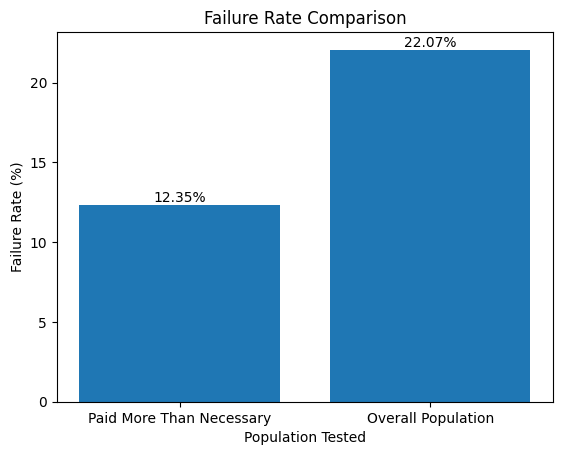

In [63]:
average_failure_rate = df['default'].mean() * 100

# Create a bar plot
plt.bar(['Paid More Than Necessary', 'Overall Population'], [failure_rate, average_failure_rate])
plt.xlabel('Population Tested')
plt.ylabel('Failure Rate (%)')
plt.title('Failure Rate Comparison')

# Add labels to the bars
for i, rate in enumerate([failure_rate, average_failure_rate]):
    plt.text(i, rate, f'{rate:.2f}%', ha='center', va='bottom')

# Show the plot
plt.show()

We would like to examine this compared to those who were classified in -1 and did not pay more (paid exactly)

In [64]:
pay_list=['pay_1','pay_2','pay_3','pay_4','pay_5']
bill_amt_list = ['bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5']
pay_amt_list = ['pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
failure_rate_list=[]
failure_rate1=0
rate=0

for bill_amt, pay_amt,pay_x in zip(bill_amt_list, pay_amt_list,pay_list):
    filtered_df=df[((df[pay_x] == -1) & ~(df[bill_amt] < df[pay_amt]))]
    rate=filtered_df["default"].mean()*100
    failure_rate_list.append(rate)

for rate in failure_rate_list:
    failure_rate1+=rate
    
failure_rate1/=5

print(f"The avg failure rate for individuals who classified in -1 and did not pay more is {failure_rate1:.2f}%.")

The avg failure rate for individuals who classified in -1 and did not pay more is 15.57%.


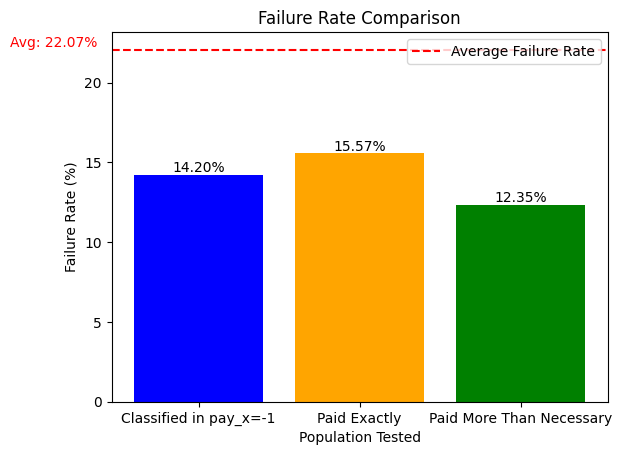

In [65]:
pay_list=['pay_1','pay_2','pay_3','pay_4','pay_5']
failure_rate_list=[]
rate=0
failure_rateall=0

for pay_x in pay_list:
    filtered_df=df[df[pay_x] == -1]
    rate=filtered_df["default"].mean()*100
    failure_rate_list.append(rate)

for rate in failure_rate_list:
    failure_rateall+=rate
    
failure_rateall/=5

plt.bar(['Classified in pay_x=-1', 'Paid Exactly', 'Paid More Than Necessary'], [failure_rateall, failure_rate1, failure_rate], color=['blue', 'orange', 'green'])

plt.axhline(average_failure_rate, color='red', linestyle='--', label='Average Failure Rate')

plt.xlabel('Population Tested')
plt.ylabel('Failure Rate (%)')
plt.title('Failure Rate Comparison')

for i, rate in enumerate([failure_rateall, failure_rate1, failure_rate]):
    plt.text(i, rate, f'{rate:.2f}%', ha='center', va='bottom')

plt.text(-0.9, average_failure_rate, f'Avg: {average_failure_rate:.2f}%', color='red', ha='center', va='bottom')

plt.legend()
plt.show()


Although individuals classified under -1 for pay_x tend to have a lower average failure percentage compared to the overall population, there is a significant distinction between those who paid exactly and those who paid more than the average failure percentage. Due to this notable difference, we have introduced a new category called "Paid More." This category helps to further differentiate individuals who have made payments above the average failure percentage, acknowledging their higher level of payment commitment and potentially different risk profile.
pay x=-3 

In [66]:
df.loc[(df['bill_amt1'] < df['pay_amt2']), 'pay_1'] = -3
df.loc[(df['bill_amt2'] < df['pay_amt3']), 'pay_2'] = -3
df.loc[(df['bill_amt3'] < df['pay_amt4']), 'pay_3'] = -3
df.loc[(df['bill_amt4'] < df['pay_amt5']), 'pay_4'] = -3
df.loc[(df['bill_amt5'] < df['pay_amt6']), 'pay_5'] = -3

**bill_amt**

we will check if the bill_amt is negative

In [67]:
print(df[(df['bill_amt1'] < 0) | (df['bill_amt2'] < 0) | (df['bill_amt3'] < 0) | (df['bill_amt4'] < 0) | (df['bill_amt5'] < 0)].shape[0])

1381


It is reasonable that there are negative accounts for 2 reasons - we have seen that there are cases where people paid more than they should have before and that it makes sense that people received credits for their purchases.

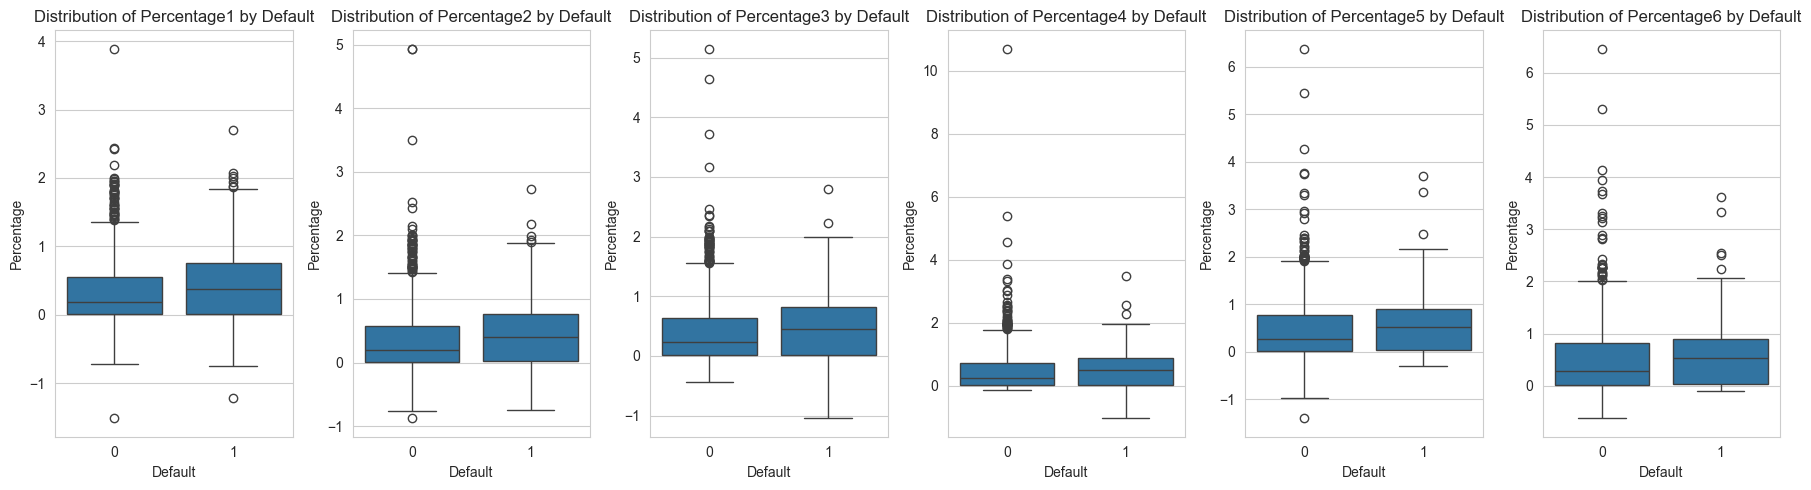

In [68]:
default_df = df.copy()
default_df.loc[:, 'Percentage1'] = default_df['bill_amt1'] / default_df['limit_bal']
default_df.loc[:, 'Percentage2'] = default_df['bill_amt2'] / default_df['limit_bal']
default_df.loc[:, 'Percentage3'] = default_df['bill_amt3'] / default_df['limit_bal']
default_df.loc[:, 'Percentage4'] = default_df['bill_amt4'] / default_df['limit_bal']
default_df.loc[:, 'Percentage5'] = default_df['bill_amt5'] / default_df['limit_bal']
default_df.loc[:, 'Percentage6'] = default_df['bill_amt6'] / default_df['limit_bal']

# Filter the default and non-default accounts
default_accounts = default_df[default_df['default'] == 1]
non_default_accounts = default_df[default_df['default'] == 0]

sns.set_style("whitegrid")

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(18, 5))

for i, month in enumerate(['Percentage1', 'Percentage2', 'Percentage3', 'Percentage4', 'Percentage5', 'Percentage6']):
    ax = axes[i]
    sns.boxplot(x='default', y=month, data=default_df, ax=ax)
    ax.set_xlabel('Default')
    ax.set_ylabel('Percentage')
    ax.set_title(f'Distribution of {month} by Default')

plt.tight_layout()

plt.show()


The percentage of the bill amount relative to the credit limit for each month can be analyzed. It is observed that the average percentage for defaulters is higher, indicating that defaulters tend to accumulate a higher level of debt relative to their credit limit.

**pay_amt**

we will check if the pay_amt is negative

In [69]:
df[(df['pay_amt1'] < 0)| (df['pay_amt2'] < 0)|(df['pay_amt3'] < 0)|(df['pay_amt4'] < 0) | df['pay_amt5']< 0].shape[0]

0

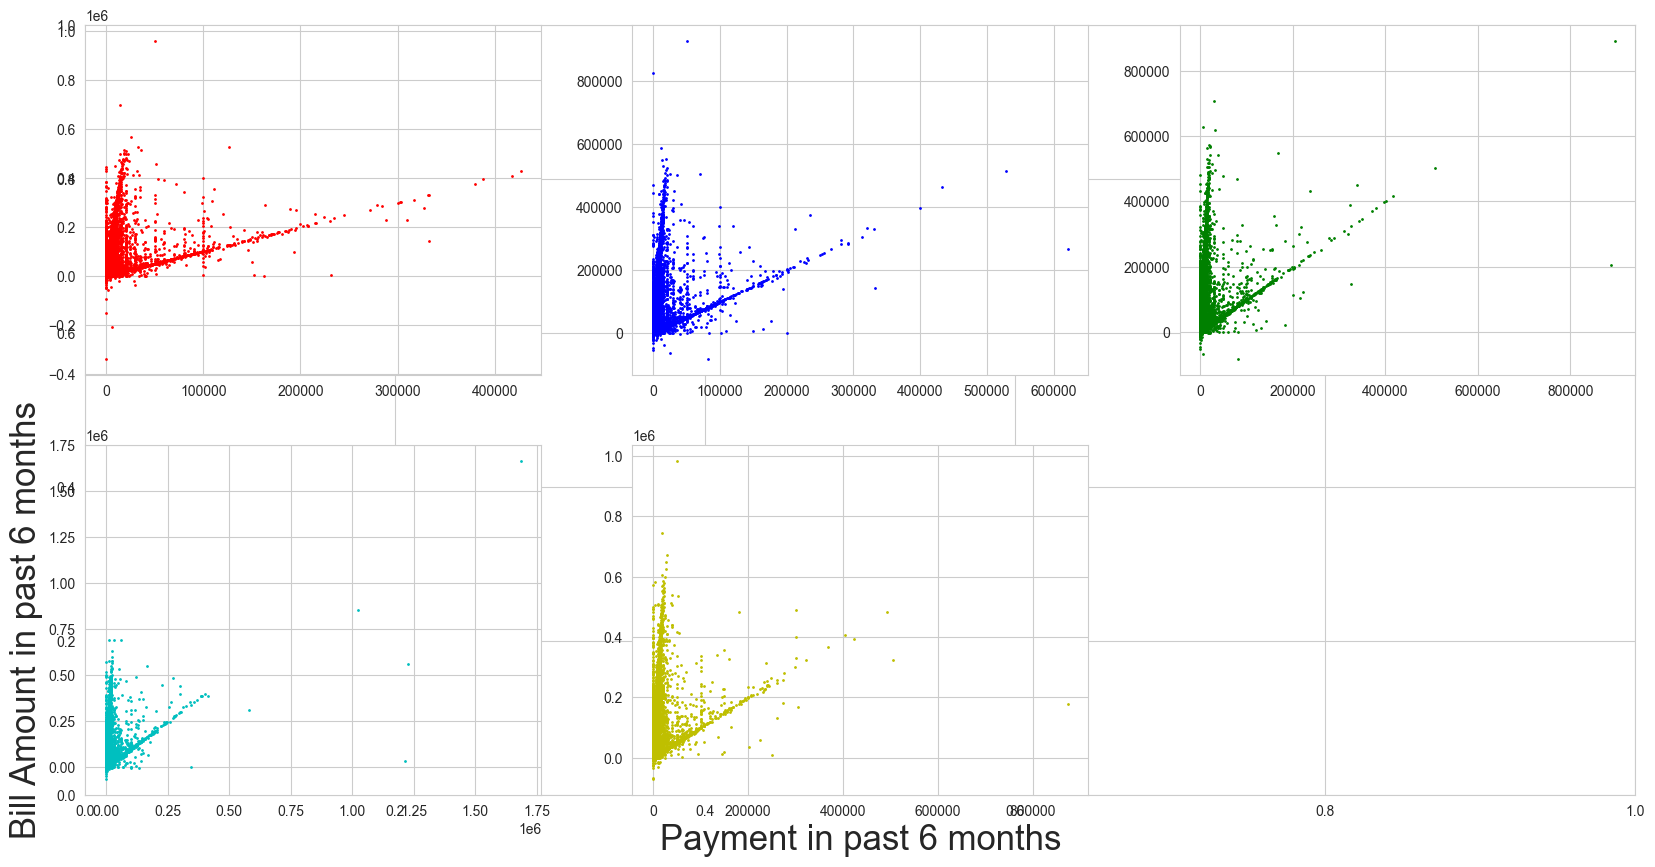

In [70]:
plt.subplots(figsize=(20,10))

plt.subplot(231)
plt.scatter(x=df.pay_amt2, y=df.bill_amt1, c='r', s=1)

plt.subplot(232)
plt.scatter(x=df.pay_amt3, y=df.bill_amt2, c='b', s=1)

plt.subplot(233)
plt.scatter(x=df.pay_amt4, y=df.bill_amt3, c='g', s=1)

plt.subplot(234)
plt.scatter(x=df.pay_amt5, y=df.bill_amt4, c='c', s=1)
plt.ylabel("Bill Amount in past 6 months", fontsize=25)

plt.subplot(235)
plt.scatter(x=df.pay_amt6, y=df.bill_amt5, c='y', s=1)
plt.xlabel("Payment in past 6 months", fontsize=25)



plt.show()

These plots display the five payment cycles present in our dataset. It is evident that our data reveals a problem where some payments are made on time and in full, while others show accumulated bills without any corresponding payments. This discrepancy is clearly visible in the plot, as there are two distinct lines representing these different payment behaviors.

## Filling in Missing Values
Subsequently, we will proceed with the task of handling missing values in the dataset. It is important to note that the number of missing values has increased compared to the initial test, as we have now reclassified the unknown categories as missing values. Given the lack of information about the true distribution of the variable in the overall population, we will employ three different options to fill in these missing values. By doing so, we can later assess the impact of these imputation methods on our models and make informed decisions regarding the most suitable approach.

In [71]:
na_percent = {}

for column in df.columns:
    if column == 'id':
        continue
    na_count = df[column].isna().sum()
    na_percent[column] = (na_count / len(df)) * 100

sorted_na_percent = {column: na_percent for column, na_percent in sorted(na_percent.items(), key=lambda x: x[1], reverse=True)}

print("Missing Values Percentage by Column:")
for column, na_percent in sorted_na_percent.items():
    if na_percent > 0:
        column_na_count = df[column].isna().sum()
        print(f"\033[91m{column}: {na_percent:.2f}% Na Percent (Count: {column_na_count})\033[0m")
    else:
        print(f"{column}: {na_percent:.2f}% Na Percent")

Missing Values Percentage by Column:
education: 1.16% Na Percent (Count: 326)
marriage: 0.17% Na Percent (Count: 47)
limit_bal: 0.00% Na Percent
sex: 0.00% Na Percent
age: 0.00% Na Percent
pay_1: 0.00% Na Percent
pay_2: 0.00% Na Percent
pay_3: 0.00% Na Percent
pay_4: 0.00% Na Percent
pay_5: 0.00% Na Percent
bill_amt1: 0.00% Na Percent
bill_amt2: 0.00% Na Percent
bill_amt3: 0.00% Na Percent
bill_amt4: 0.00% Na Percent
bill_amt5: 0.00% Na Percent
bill_amt6: 0.00% Na Percent
pay_amt1: 0.00% Na Percent
pay_amt2: 0.00% Na Percent
pay_amt3: 0.00% Na Percent
pay_amt4: 0.00% Na Percent
pay_amt5: 0.00% Na Percent
pay_amt6: 0.00% Na Percent
default: 0.00% Na Percent


### Marriage
**First method-** we will fills missing values in the "marriage" column by calculating the mode value for each combination of bins formed by the "limit_bal" and "age" columns. It stores the mode values in a dictionary based on the bin combination. The missing values in the "marriage" column are then replaced with the appropriate mode value corresponding to the bins of the respective instance's "limit_bal" and "age" values.

In [72]:
df['marriage_method_1']=df['marriage']

In [73]:
limit_bal_bin_width = 2000
age_bin_width = 5

limit_bal_bins = np.arange(0, df['limit_bal'].max() + limit_bal_bin_width, limit_bal_bin_width)
age_bins = np.arange(0, df['age'].max() + age_bin_width, age_bin_width)

common_values = {}
for limit_bin in limit_bal_bins:
    for age_bin in age_bins:
        filtered_data = df[(df['limit_bal'] >= limit_bin) & (df['limit_bal'] < limit_bin + limit_bal_bin_width) &
                           (df['age'] >= age_bin) & (df['age'] < age_bin + age_bin_width)]
        if not filtered_data.empty:
            common_marriage_value = filtered_data['marriage_method_1'].mode().values[0]
            common_values[(limit_bin, age_bin)] = common_marriage_value

for index, row in df.iterrows():
    if pd.isnull(row['marriage_method_1']):
        limit_bin = min(limit_bal_bins, key=lambda x: abs(x - row['limit_bal']))
        age_bin = min(age_bins, key=lambda x: abs(x - row['age']))
        common_marriage_value = common_values.get((limit_bin, age_bin))
        if common_marriage_value is not None:
            df.loc[index, 'marriage_method_1'] = common_marriage_value

We will fill in the second way later.

**Second method** - We will fill in the missing values using a logistic regression on all the features we received (without the the educational features that have not yet been treated for missing values)

In [74]:
df['marriage_method_2']=df['marriage']

In [75]:
train_data = df[df['marriage_method_2'].notnull()].copy()
test_data = df[df['marriage_method_2'].isnull()].copy()

train_data.loc[:, 'sex'] = train_data['sex'].replace({'female': 1, 'male': 0})
test_data.loc[:, 'sex'] = test_data['sex'].replace({'female': 1, 'male': 0})

X_train = train_data.drop(['education', 'marriage','default','marriage_method_1','marriage_method_2'], axis=1)
y_train = train_data['marriage_method_2']
X_test = test_data.drop(['education', 'marriage','default','marriage_method_1','marriage_method_2'], axis=1)

model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

predicted_marriage = model.predict(X_test)

df.loc[df['marriage_method_2'].isnull(), 'marriage_method_2'] = predicted_marriage


C:\Users\amitr\AppData\Local\Temp\ipykernel_19076\2804811483.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data.loc[:, 'sex'] = train_data['sex'].replace({'female': 1, 'male': 0})
C:\Users\amitr\AppData\Local\Temp\ipykernel_19076\2804811483.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_data.loc[:, 'sex'] = test_data['sex'].replace({'female': 1, 'male': 0})
c:\Users\amitr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to conver

### education
Note that we also complete the unknown values with the thought that they are also missing values as we mentioned above
<br>
**First method-** we will fills missing values in the "education" column by calculating the mode value for each combination of bins formed by the "limit_bal" and "age" columns. It stores the mode values in a dictionary based on the bin combination. The missing values in the "marriage" column are then replaced with the appropriate mode value corresponding to the bins of the respective instance's "limit_bal" and "age" values.

In [76]:
df['education_method_1']=df['education']

In [77]:
df['education_method_1'].value_counts()

education_method_1
university         13288
graduate school     9793
high school         4622
others               113
Name: count, dtype: int64

In [78]:
limit_bal_bin_width = 2000
age_bin_width = 5

limit_bal_bins = np.arange(0, df['limit_bal'].max() + limit_bal_bin_width, limit_bal_bin_width)
age_bins = np.arange(0, df['age'].max() + age_bin_width, age_bin_width)

common_values = {}

for limit_bin in limit_bal_bins:
    for age_bin in age_bins:
        filtered_data = df[(df['limit_bal'] >= limit_bin) & (df['limit_bal'] < limit_bin + limit_bal_bin_width) &
                           (df['age'] >= age_bin) & (df['age'] < age_bin + age_bin_width)]
        if not filtered_data.empty:
            mode_values = filtered_data['education_method_1'].mode()
            if not mode_values.empty:
                common_education_value = mode_values.values[0]
                common_values[(limit_bin, age_bin)] = common_education_value

for index, row in df.iterrows():
    if pd.isnull(row['education_method_1']):
        limit_bin = min(limit_bal_bins, key=lambda x: abs(x - row['limit_bal']))
        age_bin = min(age_bins, key=lambda x: abs(x - row['age']))
        common_education_value = common_values.get((limit_bin, age_bin))
        if common_education_value is not None:
            df.loc[index, 'education_method_1'] = common_education_value


**Second method** - We will fill in the missing values using a KNN on all the features we received (without the marriage feature that have not yet been treated for missing values)

In [79]:
df['education_method_2']=df['education']

In [83]:
# Split data into train and test sets based on missing values in 'education_method_2' column
train_data = df[df['education_method_2'].notnull()].copy()
test_data = df[df['education_method_2'].isnull()].copy()

# Convert categorical values to numeric representation
train_data['sex'] = train_data['sex'].replace({'female': 1, 'male': 0})
test_data['sex'] = test_data['sex'].replace({'female': 1, 'male': 0})

education_mapping = {'university': 0, 'graduate school': 1, 'high school': 2, 'others': 3}
train_data['education'] = train_data['education'].replace(education_mapping)
train_data['education_method_2'] = train_data['education_method_2'].replace(education_mapping)

# Select features and target variable for training
X_train = train_data.drop(['education', 'marriage', 'default', 'marriage_method_1', 'marriage_method_2', 'education_method_1', 'education_method_2'], axis=1)
y_train = train_data['education_method_2']

# Select features for prediction
X_test = test_data.drop(['education', 'marriage', 'default', 'marriage_method_1', 'marriage_method_2', 'education_method_1', 'education_method_2'], axis=1)

# Scale features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train K-Nearest Neighbors classifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_scaled, y_train)

# Predict missing values
predicted_education = model.predict(X_test_scaled)

# Replace missing values in the original DataFrame
df.loc[df['education_method_2'].isnull(), 'education_method_2'] = predicted_education

# Replace numeric values with corresponding categories in the original DataFrame
df['education_method_2'] = df['education_method_2'].replace({v: k for k, v in education_mapping.items()})


C:\Users\amitr\AppData\Local\Temp\ipykernel_19076\3920039357.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data['sex'] = train_data['sex'].replace({'female': 1, 'male': 0})
C:\Users\amitr\AppData\Local\Temp\ipykernel_19076\3920039357.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_data['sex'] = test_data['sex'].replace({'female': 1, 'male': 0})
C:\Users\amitr\AppData\Local\Temp\ipykernel_19076\3920039357.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future versi

## Outliers

In our project, we chose not to handle outliers to preserve data integrity, maintain the authenticity of the dataset, and avoid potential distortions in data distribution and relationships.  By retaining outliers, we acknowledge the potential richness of information they carry, which could be valuable in understanding rare occurrences or extreme events. by choosing not to handle outliers , we take into concideration the risk of potential outliers disproportionately influencing statistical analyses, potentially leading to erroneous conclusions or skewed interpretations, which could impact the overall validity and credibility of our research findings. In an optimal process we would try both methods.

In [84]:
def detect_outliers(data):
    outliers = []
    
    for column in data.columns:
        if np.issubdtype(data[column].dtype, np.number):
            Q1 = np.percentile(data[column], 25)
            Q3 = np.percentile(data[column], 75)

            IQR = Q3 - Q1

            lower_bound = Q1 - (1.5 * IQR)
            upper_bound = Q3 + (1.5 * IQR)

            column_outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)][column].tolist()
            outliers.extend(column_outliers)
            
            print("Column:", column)
            print("Instances with outliers:", len(column_outliers))
            print(f"Percentage of instances with outliers: {len(column_outliers)/len(df)*100:.2f}%")
            print("---------------------------------------------")

    return outliers

outliers = detect_outliers(df)

Column: limit_bal
Instances with outliers: 163
Percentage of instances with outliers: 0.58%
---------------------------------------------
Column: age
Instances with outliers: 254
Percentage of instances with outliers: 0.90%
---------------------------------------------
Column: pay_1
Instances with outliers: 5323
Percentage of instances with outliers: 18.91%
---------------------------------------------
Column: pay_2
Instances with outliers: 5302
Percentage of instances with outliers: 18.84%
---------------------------------------------
Column: pay_3
Instances with outliers: 6155
Percentage of instances with outliers: 21.87%
---------------------------------------------
Column: pay_4
Instances with outliers: 7022
Percentage of instances with outliers: 24.95%
---------------------------------------------
Column: pay_5
Instances with outliers: 7249
Percentage of instances with outliers: 25.76%
---------------------------------------------
Column: bill_amt1
Instances with outliers: 2501
Pe

In [85]:
df1=df.copy()
df2=df.copy()

# 6 Month Period 
(the available data)
## Feature engineering (6 Month Period ):
we will add more engineered features and check their contribution to the model in the next steps

#### add colunm that represents the % of debt

In [86]:
df['cum_bill']=df['bill_amt1']+df['bill_amt2']+df['bill_amt3']+df['bill_amt4']+df['bill_amt5']
df['cum_pay']=df['pay_amt2']+df['pay_amt3']+df['pay_amt4']+df['pay_amt5']+df['pay_amt6']
df['debt_per']=(df['cum_pay']/df['cum_bill'])
df['debt_per'] = np.where(np.logical_or(np.isinf(df['debt_per']), np.isnan(df['debt_per'])), 0, df['debt_per'])

df=df.drop('cum_bill', axis=1)
df=df.drop('cum_pay', axis=1)

####  Adding is_late colunm  - Late at least once

In [87]:
df['is_late'] = ~(((df['pay_1'] == -1) | (df['pay_1'] == -3) | (df['pay_1'] == -2)) &
                  ((df['pay_2'] == -1) | (df['pay_2'] == -3) | (df['pay_2'] == -2)) &
                  ((df['pay_3'] == -1) | (df['pay_3'] == -3) | (df['pay_3'] == -2)) &
                  ((df['pay_4'] == -1) | (df['pay_4'] == -3) | (df['pay_4'] == -2)) &
                  ((df['pay_5'] == -1) | (df['pay_5'] == -3) | (df['pay_5'] == -2)))

df['is_late'] = df['is_late'].astype(int)

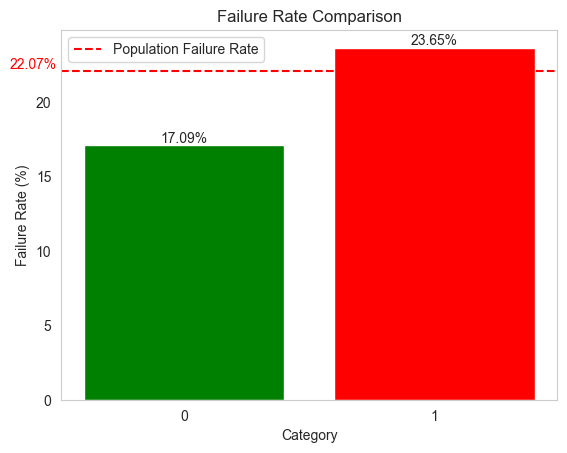

In [88]:
# Calculate the failure percentage for each category
category_failure_rate = df.groupby('is_late')['default'].mean() * 100

# Calculate the overall failure percentage in the population
population_failure_rate = df['default'].mean() * 100

# Define the desired order of categories
category_order = [0, 1]

# Create a bar plot with ordered categories
colors = ['green', 'red']
plt.bar(category_order, category_failure_rate[category_order], color=colors)

# Add a horizontal line for the population failure rate
plt.axhline(population_failure_rate, color='red', linestyle='--', label='Population Failure Rate')

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Failure Rate (%)')
plt.title('Failure Rate Comparison')

# Add values as labels on top of the bars
for i, rate in enumerate(category_failure_rate[category_order].values):
    plt.text(i, rate, f'{rate:.2f}%', ha='center', va='bottom')

# Add label for the population failure rate on the y-axis
plt.text(-0.6, population_failure_rate, f'{population_failure_rate:.2f}%', color='red', ha='center', va='bottom')

# Hide the grid behind the bars
plt.grid(False)

# Set the tick labels for the categories
plt.xticks(category_order, ['0', '1'])

# Show the plot
plt.legend()
plt.show()

**add std for bill and pay amt**

In [89]:
df['std_pay_amt'] = df[['pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']].std(axis=1)
df['std_bill_amt'] = df[['bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5']].std(axis=1)

C:\Users\amitr\AppData\Local\Temp\ipykernel_19076\3259239910.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='default', y='std_pay_amt', data=df, ax=axes[0], palette=['green', 'red'])
C:\Users\amitr\AppData\Local\Temp\ipykernel_19076\3259239910.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='default', y='std_bill_amt', data=df, ax=axes[1], palette=['green', 'red'])


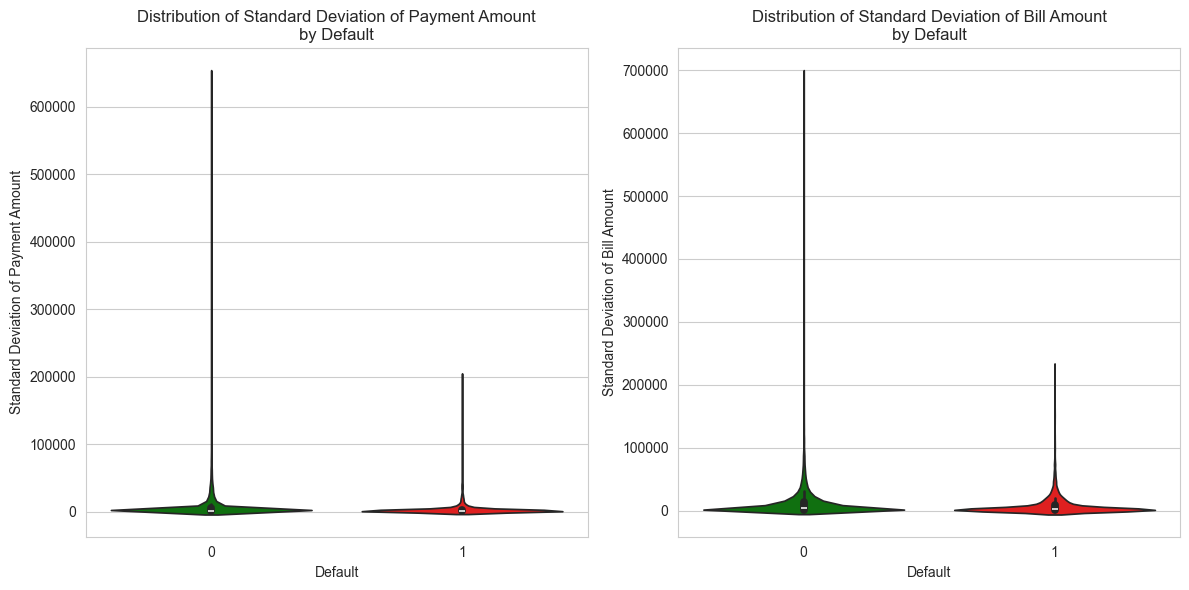

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.violinplot(x='default', y='std_pay_amt', data=df, ax=axes[0], palette=['green', 'red'])
axes[0].set_xlabel('Default')
axes[0].set_ylabel('Standard Deviation of Payment Amount')
axes[0].set_title('Distribution of Standard Deviation of Payment Amount\nby Default')

sns.violinplot(x='default', y='std_bill_amt', data=df, ax=axes[1], palette=['green', 'red'])
axes[1].set_xlabel('Default')
axes[1].set_ylabel('Standard Deviation of Bill Amount')
axes[1].set_title('Distribution of Standard Deviation of Bill Amount\nby Default')

plt.tight_layout()

plt.show()

**add late count (how many mothnes he is lated**

In [91]:
df['late_count'] = 0

df.loc[((df['bill_amt1'] > df['pay_amt2']) & (df['bill_amt1'] != 0)), 'late_count'] += 1
df.loc[((df['bill_amt2'] > df['pay_amt3']) & (df['bill_amt2'] != 0)), 'late_count'] += 1
df.loc[((df['bill_amt3'] > df['pay_amt4']) & (df['bill_amt3'] != 0)), 'late_count'] += 1
df.loc[((df['bill_amt4'] > df['pay_amt5']) & (df['bill_amt4'] != 0)), 'late_count'] += 1
df.loc[((df['bill_amt5'] > df['pay_amt6']) & (df['bill_amt5'] != 0)), 'late_count'] += 1

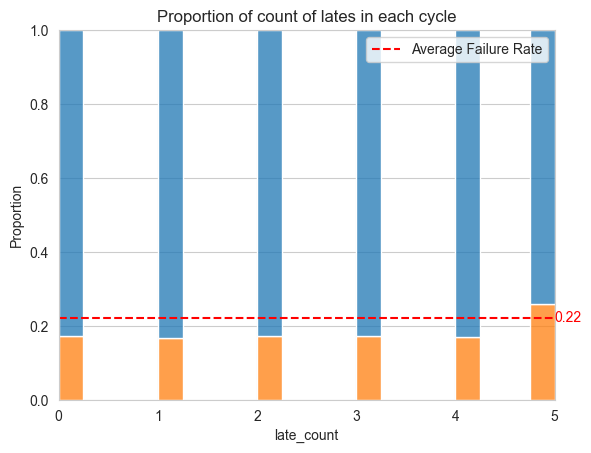

In [92]:
age_group_counts = df.groupby('late_count')['default'].mean()

sns.histplot(df, x='late_count', hue='default', multiple='fill')

plt.xlabel('late_count')
plt.ylabel('Proportion')
plt.title('Proportion of count of lates in each cycle')

average_failure_rate = df['default'].mean()
plt.axhline(average_failure_rate, color='red', linestyle='--', label='Average Failure Rate')

plt.legend()

# Add label for the red line value on the y-axis
plt.text(plt.gca().get_xlim()[1], average_failure_rate, f'{average_failure_rate:.2f}', color='red', ha='left', va='center')

plt.show()

**Average delays per cycle**

In [93]:
df['avg_months_late'] = 0

df.loc[(df['pay_1'] >0), 'avg_months_late'] += df['pay_1']
df.loc[(df['pay_2'] >0), 'avg_months_late'] += df['pay_2']
df.loc[(df['pay_3'] >0), 'avg_months_late'] += df['pay_3']
df.loc[(df['pay_4'] >0), 'avg_months_late'] += df['pay_4']
df.loc[(df['pay_5'] >0), 'avg_months_late'] += df['pay_5']

df['avg_months_late']=df['avg_months_late']/5

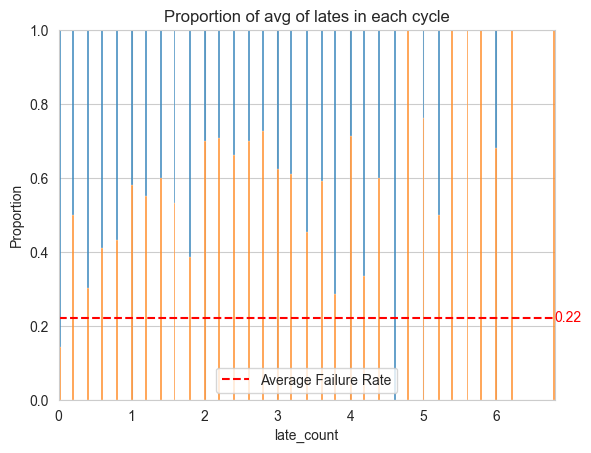

In [94]:
age_group_counts = df.groupby('avg_months_late')['default'].mean()

sns.histplot(df, x='avg_months_late', hue='default', multiple='fill')

plt.xlabel('late_count')
plt.ylabel('Proportion')
plt.title('Proportion of avg of lates in each cycle')

average_failure_rate = df['default'].mean()
plt.axhline(average_failure_rate, color='red', linestyle='--', label='Average Failure Rate')

plt.legend()

# Add label for the red line value on the y-axis
plt.text(plt.gca().get_xlim()[1], average_failure_rate, f'{average_failure_rate:.2f}', color='red', ha='left', va='center')

plt.show()

**create Ratio of expenses to credit limit 6 months**

In [95]:
df['expenses_credit_limit_ratio_6_mts']=(df['bill_amt1']+df['bill_amt2']+df['bill_amt3']+df['bill_amt4']+df['bill_amt5']+df['bill_amt6'])/(6*df['limit_bal'])

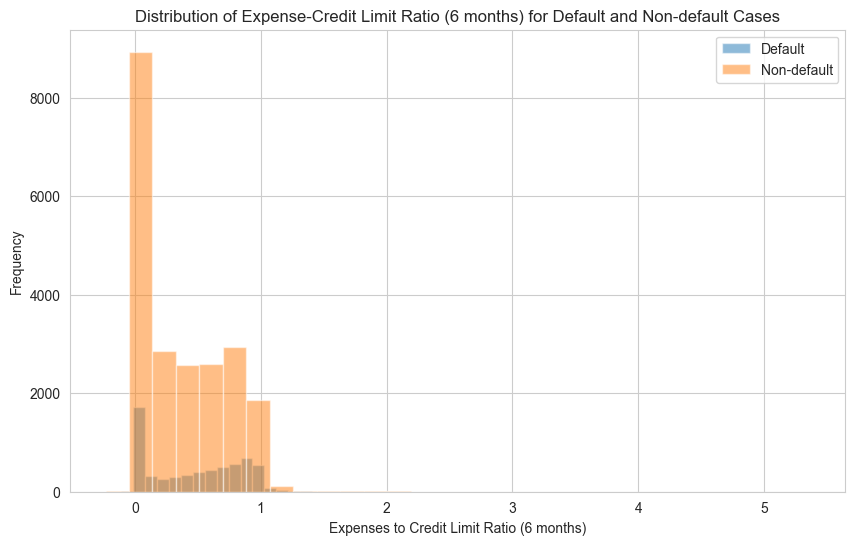

In [96]:

default_cases = df[df["default"] == 1]
non_default_cases = df[df["default"] == 0]

plt.figure(figsize=(10, 6))
plt.hist(default_cases["expenses_credit_limit_ratio_6_mts"], bins=30, alpha=0.5, label="Default")
plt.hist(non_default_cases["expenses_credit_limit_ratio_6_mts"], bins=30, alpha=0.5, label="Non-default")
plt.xlabel("Expenses to Credit Limit Ratio (6 months)")
plt.ylabel("Frequency")
plt.title("Distribution of Expense-Credit Limit Ratio (6 months) for Default and Non-default Cases")
plt.legend()

plt.show()

**Ratio of expenses to credit limit last 3 months**

In [97]:
df['expenses_credit_limit_ratio_3_mts']=(df['bill_amt4']+df['bill_amt5']+df['bill_amt6'])/(3*df['limit_bal'])

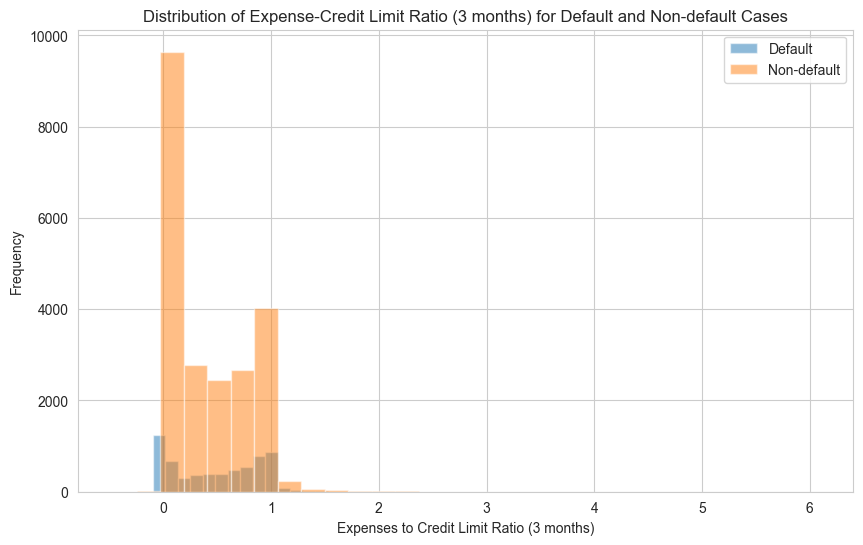

In [98]:
default_cases = df[df["default"] == 1]
non_default_cases = df[df["default"] == 0]

plt.figure(figsize=(10, 6))
plt.hist(default_cases["expenses_credit_limit_ratio_3_mts"], bins=30, alpha=0.5, label="Default")
plt.hist(non_default_cases["expenses_credit_limit_ratio_3_mts"], bins=30, alpha=0.5, label="Non-default")
plt.xlabel("Expenses to Credit Limit Ratio (3 months)")
plt.ylabel("Frequency")
plt.title("Distribution of Expense-Credit Limit Ratio (3 months) for Default and Non-default Cases")
plt.legend()

plt.show()

## Handling categorical variables

In [99]:
df['sex'] = df['sex'].replace({'female': 1, 'male': 0})

C:\Users\amitr\AppData\Local\Temp\ipykernel_19076\3104945787.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sex'] = df['sex'].replace({'female': 1, 'male': 0})


It is true that pay_X contains numbers, but since the number is a whole number and in some cases also represents the category (partially paid, there were no charges, fully paid). We will refer to this variable as a categorical variable

In [100]:
dummies = pd.get_dummies(df['pay_1'], prefix='pay_1')
df = pd.concat([df, dummies], axis=1)
df.drop('pay_1', axis=1, inplace=True)

In [101]:
dummies = pd.get_dummies(df['pay_2'], prefix='pay_2')
df = pd.concat([df, dummies], axis=1)
df.drop('pay_2', axis=1, inplace=True)

In [102]:
dummies = pd.get_dummies(df['pay_3'], prefix='pay_3')
df = pd.concat([df, dummies], axis=1)
df.drop('pay_3', axis=1, inplace=True)

In [103]:
dummies = pd.get_dummies(df['pay_4'], prefix='pay_4')
df = pd.concat([df, dummies], axis=1)
df.drop('pay_4', axis=1, inplace=True)

In [104]:
dummies = pd.get_dummies(df['pay_5'], prefix='pay_5')
df = pd.concat([df, dummies], axis=1)
df.drop('pay_5', axis=1, inplace=True)

## Feature Importance

For a general analysis we will only use the period of the last 6 months
We will analyze our data using feature importance in two ways:

Firstly, we will identify features that do not significantly contribute to our data or that without them we get better results.

Secondly, we want to ensure that our model does not rely too heavily on specific features, as it is important for the model to generalize well to new data. By checking feature importance, we can assess the extent to which the model depends on certain features and identify any potential biases or over-reliance on limited aspects of the data. This allows us to make our model more robust and better equipped to handle diverse datasets and real-world scenarios.

We will check this only for the random forest model beacuse we assume it will be our best model

In [105]:
data=df.copy()
dummies = pd.get_dummies(data['education_method_1'], prefix='education_method_1')
data = pd.concat([data, dummies], axis=1)
data = data.drop(['education_method_1'], axis=1)

dummies = pd.get_dummies(data['marriage_method_1'], prefix='marriage_method_1')
data = pd.concat([data, dummies], axis=1)
data = data.drop(['marriage_method_1'], axis=1)

dummies = pd.get_dummies(data['education_method_2'], prefix='education_method_2')
data = pd.concat([data, dummies], axis=1)
data = data.drop(['education_method_2'], axis=1)

dummies = pd.get_dummies(data['marriage_method_2'], prefix='marriage_method_2')
data = pd.concat([data, dummies], axis=1)
data = data.drop(['marriage_method_2'], axis=1)

data=data.drop(['education', 'marriage'], axis=1)

X_importence = data.drop('default', axis=1)
y_importence = data['default']

rf = RandomForestClassifier()
rf.fit(X_importence, y_importence)

feature_importance = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_importence.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                              Feature    Importance
2                                 age  5.488478e-02
21  expenses_credit_limit_ratio_6_mts  4.985032e-02
0                           limit_bal  4.894497e-02
22  expenses_credit_limit_ratio_3_mts  4.692294e-02
20                    avg_months_late  4.453343e-02
..                                ...           ...
61                            pay_4_1  6.018134e-06
33                            pay_1_8  4.737813e-06
49                            pay_3_1  2.642984e-06
56                            pay_3_8  8.950731e-07
44                            pay_2_8  0.000000e+00

[95 rows x 2 columns]


The feature importance analysis reveals that the most important feature in the model has an importance score of less than 0.054. This finding is can be encouraging as it indicates that the model does not heavily rely on any single feature. 
It can be seen that the feature of age, credit limit and limit expense ratio that we created are of the highest importance.
It can be seen that 6 of the variables we created are of the highest importance after age and frame - which may indicate that we did a good job ;)
On the other hand, most of the variables that give an indication of how many months the customer is late are of low importance.

**All of these will lead us later to select features according to their importance and to examine whether this action improves the results of the model.**

First we will check for the last 10 features in the feature importance list if the accuracy is better without them on a basic model (with random scaler) again

In [106]:
# Get the last 10 features based on importance rankings
last_10_features = feature_importance_df.tail(10)['Feature'].tolist()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_importence, y_importence, test_size=0.3, random_state=42)

# Apply StandardScaler to the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a basic model with all features
baseline_model = RandomForestClassifier()
baseline_model.fit(X_train, y_train)
baseline_predictions = baseline_model.predict(X_test)
baseline_accuracy = accuracy_score(y_test, baseline_predictions)
print("Baseline accuracy is:", baseline_accuracy)

features_to_drop = []

# Iterate through each feature
for feature in last_10_features:
    # Train a model without the current feature
    X_train_modified = X_train.drop(feature, axis=1)
    X_test_modified = X_test.drop(feature, axis=1)

    model_without_feature = RandomForestClassifier()
    model_without_feature.fit(X_train_modified, y_train)
    predictions_without_feature = model_without_feature.predict(X_test_modified)
    accuracy_without_feature = accuracy_score(y_test, predictions_without_feature)

    # Compare accuracies
    if accuracy_without_feature > baseline_accuracy:
        print(f"Feature '{feature}' can be dropped. Accuracy without the feature: {accuracy_without_feature:.4f}")
        features_to_drop.append(feature)
    else:
        print(f"Feature '{feature}' should be kept. Accuracy without the feature: {accuracy_without_feature:.4f}")

Baseline accuracy is: 0.8090726045244582
Feature 'pay_1_5' should be kept. Accuracy without the feature: 0.8068
Feature 'pay_3_6' should be kept. Accuracy without the feature: 0.8072
Feature 'pay_2_6' can be dropped. Accuracy without the feature: 0.8093
Feature 'pay_4_8' should be kept. Accuracy without the feature: 0.8079
Feature 'pay_5_8' can be dropped. Accuracy without the feature: 0.8097
Feature 'pay_4_1' should be kept. Accuracy without the feature: 0.8085
Feature 'pay_1_8' should be kept. Accuracy without the feature: 0.8080
Feature 'pay_3_1' should be kept. Accuracy without the feature: 0.8082
Feature 'pay_3_8' should be kept. Accuracy without the feature: 0.8082
Feature 'pay_2_8' should be kept. Accuracy without the feature: 0.8090


Because our data is imbalanced, we will now check also the f1 score.

In [107]:
# Get the last 10 features based on importance rankings
last_10_features = feature_importance_df.tail(10)['Feature'].tolist()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_importence, y_importence, test_size=0.3, random_state=42)

# Apply StandardScaler to the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a basic model with all features
baseline_model = RandomForestClassifier()
baseline_model.fit(X_train, y_train)
baseline_predictions = baseline_model.predict(X_test)
baseline_f1 = f1_score(y_test, baseline_predictions)
print("Baseline f1 is:", baseline_f1)

features_to_drop=[]

# Iterate through each feature
for feature in last_10_features:
    # Train a model without the current feature
    X_train_modified = X_train.drop(feature, axis=1)
    X_test_modified = X_test.drop(feature, axis=1)

    model_without_feature = RandomForestClassifier()
    model_without_feature.fit(X_train_modified, y_train)
    predictions_without_feature = model_without_feature.predict(X_test_modified)
    f1_without_feature = f1_score(y_test, predictions_without_feature)
    if f1_without_feature > baseline_f1:
        print(f"Feature '{feature}' can be discarded. F1 score without the feature: {f1_without_feature:.4f}")
        features_to_drop.append(feature)
    else:
        print(f"Feature '{feature}' should be kept. F1 score without the feature: {f1_without_feature:.4f}")

Baseline f1 is: 0.42424242424242425
Feature 'pay_1_5' should be kept. F1 score without the feature: 0.4179
Feature 'pay_3_6' should be kept. F1 score without the feature: 0.4162
Feature 'pay_2_6' should be kept. F1 score without the feature: 0.4216
Feature 'pay_4_8' should be kept. F1 score without the feature: 0.4133
Feature 'pay_5_8' should be kept. F1 score without the feature: 0.4180
Feature 'pay_4_1' should be kept. F1 score without the feature: 0.4203
Feature 'pay_1_8' should be kept. F1 score without the feature: 0.4177
Feature 'pay_3_1' should be kept. F1 score without the feature: 0.4160
Feature 'pay_3_8' should be kept. F1 score without the feature: 0.4218
Feature 'pay_2_8' should be kept. F1 score without the feature: 0.4201


We will concider dropping only the features that has poor results in both methods

C:\Users\amitr\AppData\Local\Temp\ipykernel_19076\1536029123.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette=colors, orient='h')


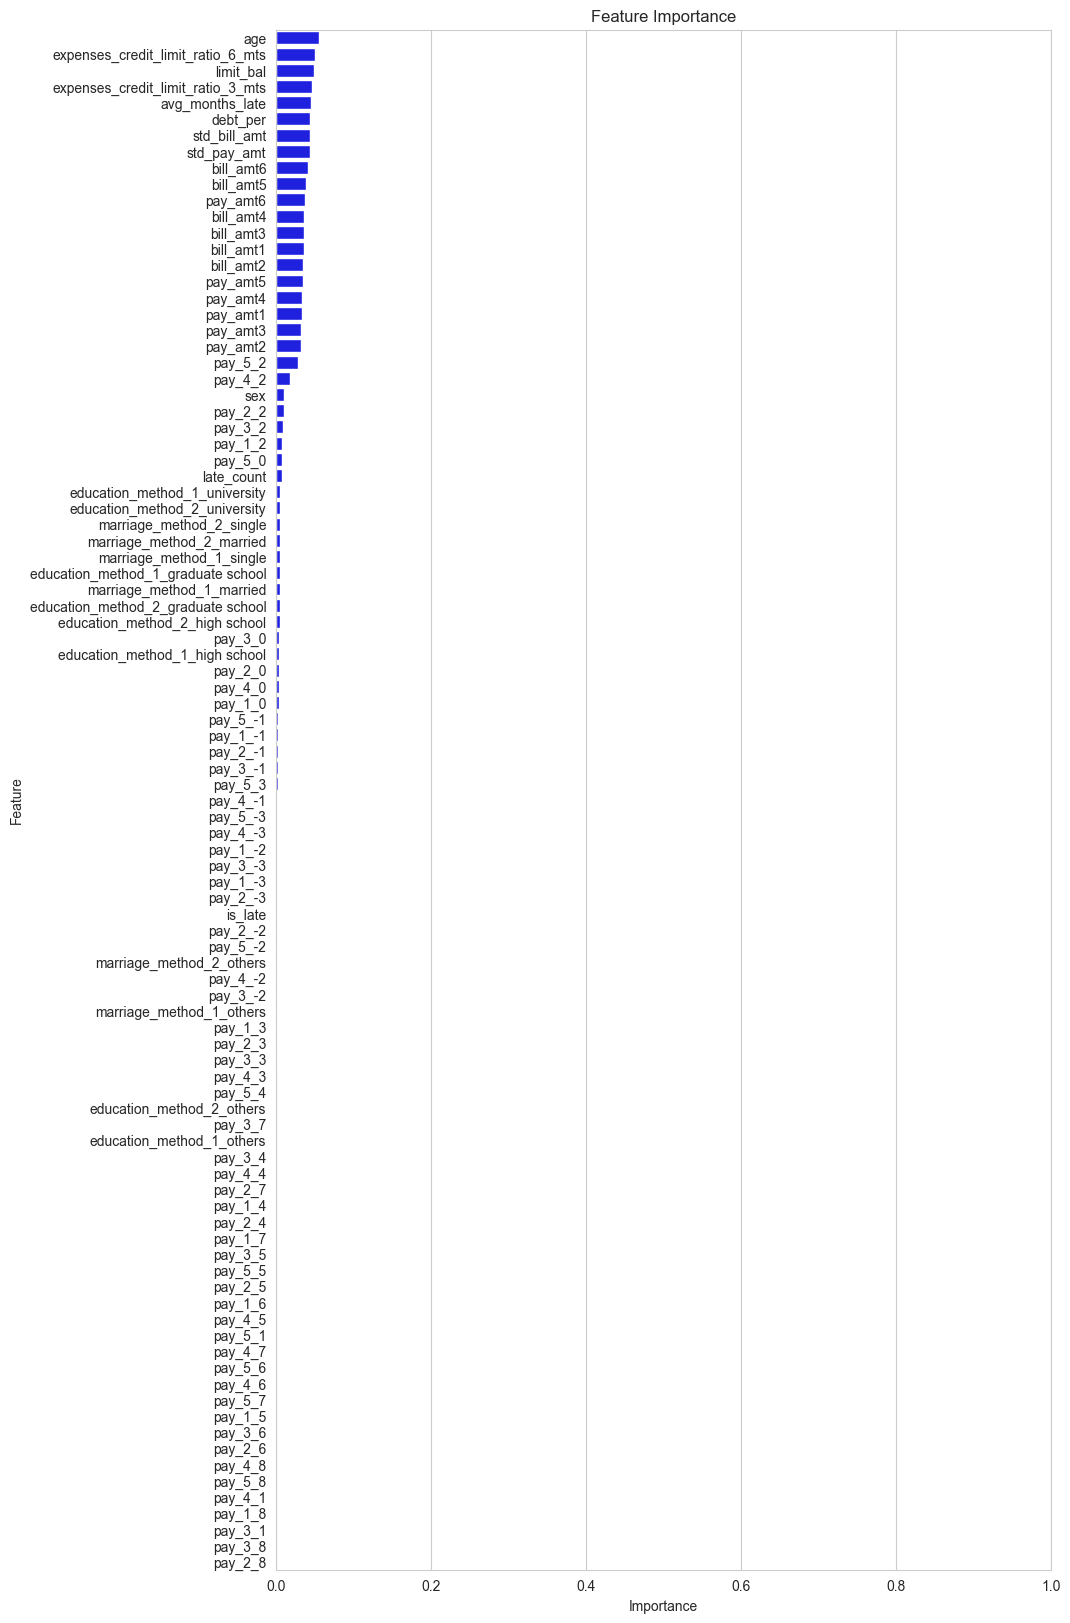

In [108]:
features_to_drop = set(features_to_drop)

colors = ['red' if feat in features_to_drop else 'blue' for feat in feature_importance_df['Feature']]

plt.figure(figsize=(10, 20))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette=colors, orient='h')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.xlim(0, 1)
plt.show()

For now, we will maintain a list of features for which we have observed higher accuracy or F1 score when excluding them from the model. Please note that we are only evaluating the Random Forest model at this stage, and we are not dropping any features based on these evaluations.
In the final stage, we will reassess our model by removing the features identified in the list and examine its performance.

## Creating a data set 
Since we want to test 3 different methods for completing missing values in 2 different columns, we will need 5 data sets which we will test on the following algorithms.
There are 2 methods with which we completed above (2*2=4) and the fifth will be the data for removing all the missing instances.

In [109]:
df_ed1_ma1=df.copy()
df_ed1_ma1=df_ed1_ma1.drop(['education', 'marriage','marriage_method_2','education_method_2'], axis=1)

df_ed1_ma2=df.copy()
df_ed1_ma2=df_ed1_ma2.drop(['education', 'marriage','marriage_method_1','education_method_2'], axis=1)

df_ed2_ma1=df.copy()
df_ed2_ma1=df_ed2_ma1.drop(['education', 'marriage','marriage_method_2','education_method_1'], axis=1)

df_ed2_ma2=df.copy()
df_ed2_ma2=df_ed2_ma2.drop(['education', 'marriage','marriage_method_1','education_method_1'], axis=1)

df_ed3_ma3=df[~df['education'].isna() & ~df['marriage'].isna()]
df_ed3_ma3=df_ed3_ma3.drop(['marriage_method_1', 'marriage_method_2', 'education_method_1','education_method_2'], axis=1)


## Handling categorical variables- completion

In [110]:
##df_ed1_ma1
dummies = pd.get_dummies(df_ed1_ma1['education_method_1'], prefix='education_method_1')
df_ed1_ma1 = pd.concat([df_ed1_ma1, dummies], axis=1)
df_ed1_ma1 = df_ed1_ma1.drop(['education_method_1'], axis=1)

dummies = pd.get_dummies(df_ed1_ma1['marriage_method_1'], prefix='marriage_method_1')
df_ed1_ma1 = pd.concat([df_ed1_ma1, dummies], axis=1)
df_ed1_ma1 = df_ed1_ma1.drop(['marriage_method_1'], axis=1)

X1 = df_ed1_ma1.drop(columns=['default']).values
y1 = df_ed1_ma1['default'].values

##df_ed1_ma2
dummies = pd.get_dummies(df_ed1_ma2['education_method_1'], prefix='education_method_1')
df_ed1_ma2 = pd.concat([df_ed1_ma2, dummies], axis=1)
df_ed1_ma2 = df_ed1_ma2.drop(['education_method_1'], axis=1)

dummies = pd.get_dummies(df_ed1_ma2['marriage_method_2'], prefix='marriage_method_2')
df_ed1_ma2 = pd.concat([df_ed1_ma2, dummies], axis=1)
df_ed1_ma2 = df_ed1_ma2.drop(['marriage_method_2'], axis=1)

X2 = df_ed1_ma2.drop(columns=['default']).values
y2 = df_ed1_ma2['default'].values

##df_ed2_ma1
dummies = pd.get_dummies(df_ed2_ma1['education_method_2'], prefix='education_method_2')
df_ed2_ma1 = pd.concat([df_ed2_ma1, dummies], axis=1)
df_ed2_ma1 = df_ed2_ma1.drop(['education_method_2'], axis=1)

dummies = pd.get_dummies(df_ed2_ma1['marriage_method_1'], prefix='marriage_method_1')
df_ed2_ma1 = pd.concat([df_ed2_ma1, dummies], axis=1)
df_ed2_ma1 = df_ed2_ma1.drop(['marriage_method_1'], axis=1)

X3 = df_ed2_ma1.drop(columns=['default']).values
y3 = df_ed2_ma1['default'].values


##df_ed2_ma2
dummies = pd.get_dummies(df_ed2_ma2['education_method_2'], prefix='education_method_2')
df_ed2_ma2 = pd.concat([df_ed2_ma2, dummies], axis=1)
df_ed2_ma2 = df_ed2_ma2.drop(['education_method_2'], axis=1)

dummies = pd.get_dummies(df_ed2_ma2['marriage_method_2'], prefix='marriage_method_2')
df_ed2_ma2 = pd.concat([df_ed2_ma2, dummies], axis=1)
df_ed2_ma2 = df_ed2_ma2.drop(['marriage_method_2'], axis=1)

X4 = df_ed2_ma2.drop(columns=['default']).values
y4 = df_ed2_ma2['default'].values

##df_ed3_ma3
dummies = pd.get_dummies(df_ed3_ma3['education'], prefix='education')
df_ed3_ma3 = pd.concat([df_ed3_ma3, dummies], axis=1)
df_ed3_ma3 = df_ed3_ma3.drop(['education'], axis=1)

dummies = pd.get_dummies(df_ed3_ma3['marriage'], prefix='marriage')
df_ed3_ma3 = pd.concat([df_ed3_ma3, dummies], axis=1)
df_ed3_ma3 = df_ed3_ma3.drop(['marriage'], axis=1)

X5 = df_ed3_ma3.drop(columns=['default']).values
y5 = df_ed3_ma3['default'].values

### Now we will repeat the process (with adjustment) for the last 2-month and the last 4-month time frame:

In [111]:
df1=df1.drop(['pay_1','pay_2','bill_amt1','bill_amt2','pay_amt1','pay_amt2',], axis=1)

#### add colunm that represents the % of debt

In [112]:
df1['cum_bill']=df1['bill_amt3']+df1['bill_amt4']+df1['bill_amt5']
df1['cum_pay']=df1['pay_amt4']+df1['pay_amt5']+df1['pay_amt6']
df1['debt_per']=(df1['cum_pay']/df1['cum_bill'])
df1['debt_per'] = np.where(np.logical_or(np.isinf(df1['debt_per']), np.isnan(df1['debt_per'])), 0, df1['debt_per'])

df1=df1.drop('cum_bill', axis=1)
df1=df1.drop('cum_pay', axis=1)

####  Adding is_late colunm  - Late at least once

In [113]:
df1['is_late'] = ~(((df1['pay_3'] == -1) | (df1['pay_3'] == -3) | (df1['pay_3'] == -2)) &
                  ((df1['pay_4'] == -1) | (df1['pay_4'] == -3) | (df1['pay_4'] == -2)) &
                  ((df1['pay_5'] == -1) | (df1['pay_5'] == -3) | (df1['pay_5'] == -2)))

df1['is_late'] = df1['is_late'].astype(int)

**add std for bill and pay amt**

In [114]:
df1['std_pay_amt'] = df1[['pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']].std(axis=1)
df1['std_bill_amt'] = df1[['bill_amt3', 'bill_amt4', 'bill_amt5']].std(axis=1)

**add late count (how many mothnes he is lated**

In [115]:
df1['late_count'] = 0

df1.loc[((df1['bill_amt3'] > df1['pay_amt4']) & (df1['bill_amt3'] != 0)), 'late_count'] += 1
df1.loc[((df1['bill_amt4'] > df1['pay_amt5']) & (df1['bill_amt4'] != 0)), 'late_count'] += 1
df1.loc[((df1['bill_amt5'] > df1['pay_amt6']) & (df1['bill_amt5'] != 0)), 'late_count'] += 1

**Average delays per cycle**

In [116]:
df1['avg_months_late'] = 0

df1.loc[(df1['pay_3'] >0), 'avg_months_late'] += df1['pay_3']
df1.loc[(df1['pay_4'] >0), 'avg_months_late'] += df1['pay_4']
df1.loc[(df1['pay_5'] >0), 'avg_months_late'] += df1['pay_5']

df1['avg_months_late']=df1['avg_months_late']/3

**create Ratio of expenses to credit limit 4 months**

In [117]:
df1['expenses_credit_limit_ratio_4_mts']=(df1['bill_amt3']+df1['bill_amt4']+df1['bill_amt5']+df1['bill_amt6'])/(4*df1['limit_bal'])

## Handling categorical variables

In [118]:
df1['sex'] = df1['sex'].replace({'female': 1, 'male': 0})

C:\Users\amitr\AppData\Local\Temp\ipykernel_19076\3446755007.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1['sex'] = df1['sex'].replace({'female': 1, 'male': 0})


It is true that pay_X contains numbers, but since the number is a whole number and in some cases also represents the category (partially paid, there were no charges, fully paid). We will refer to this variable as a categorical variable

In [119]:
dummies = pd.get_dummies(df1['pay_3'], prefix='pay_3')
df1 = pd.concat([df1, dummies], axis=1)
df1.drop('pay_3', axis=1, inplace=True)

In [120]:
dummies = pd.get_dummies(df1['pay_4'], prefix='pay_4')
df1 = pd.concat([df1, dummies], axis=1)
df1.drop('pay_4', axis=1, inplace=True)

In [121]:
dummies = pd.get_dummies(df1['pay_5'], prefix='pay_5')
df1 = pd.concat([df1, dummies], axis=1)
df1.drop('pay_5', axis=1, inplace=True)

## Creating a data set 
Since we want to test 3 different methods for completing missing values in 2 different columns, we will need 5 data sets which we will test on the following algorithms.
There are 2 methods with which we completed above (2*2=4) and the fifth will be the data for removing all the missing instances (we could have created 9 data sets for all combinations but we wanted to optimize times).

In [122]:
df_ed1_ma1_4mns=df1.copy()
df_ed1_ma1_4mns=df_ed1_ma1_4mns.drop(['education', 'marriage','marriage_method_2','education_method_2'], axis=1)

df_ed1_ma2_4mns=df1.copy()
df_ed1_ma2_4mns=df_ed1_ma2_4mns.drop(['education', 'marriage','marriage_method_1','education_method_2'], axis=1)

df_ed2_ma1_4mns=df1.copy()
df_ed2_ma1_4mns=df_ed2_ma1_4mns.drop(['education', 'marriage','marriage_method_2','education_method_1'], axis=1)

df_ed2_ma2_4mns=df1.copy()
df_ed2_ma2_4mns=df_ed2_ma2_4mns.drop(['education', 'marriage','marriage_method_1','education_method_1'], axis=1)

df_ed3_ma3_4mns=df1[~df1['education'].isna() & ~df1['marriage'].isna()]
df_ed3_ma3_4mns=df_ed3_ma3_4mns.drop(['marriage_method_1', 'marriage_method_2', 'education_method_1','education_method_2'], axis=1)


## Handling categorical variables- completion

In [123]:
##df_ed1_ma1
dummies = pd.get_dummies(df_ed1_ma1_4mns['education_method_1'], prefix='education_method_1')
df_ed1_ma1_4mns = pd.concat([df_ed1_ma1_4mns, dummies], axis=1)
df_ed1_ma1_4mns = df_ed1_ma1_4mns.drop(['education_method_1'], axis=1)

dummies = pd.get_dummies(df_ed1_ma1_4mns['marriage_method_1'], prefix='marriage_method_1')
df_ed1_ma1_4mns = pd.concat([df_ed1_ma1_4mns, dummies], axis=1)
df_ed1_ma1_4mns = df_ed1_ma1_4mns.drop(['marriage_method_1'], axis=1)

X1_4mns = df_ed1_ma1_4mns.drop(columns=['default']).values
y1_4mns = df_ed1_ma1_4mns['default'].values


##df_ed1_ma2
dummies = pd.get_dummies(df_ed1_ma2_4mns['education_method_1'], prefix='education_method_1')
df_ed1_ma2_4mns = pd.concat([df_ed1_ma2_4mns, dummies], axis=1)
df_ed1_ma2_4mns = df_ed1_ma2_4mns.drop(['education_method_1'], axis=1)

dummies = pd.get_dummies(df_ed1_ma2_4mns['marriage_method_2'], prefix='marriage_method_2')
df_ed1_ma2_4mns = pd.concat([df_ed1_ma2_4mns, dummies], axis=1)
df_ed1_ma2_4mns = df_ed1_ma2_4mns.drop(['marriage_method_2'], axis=1)

X2_4mns = df_ed1_ma2_4mns.drop(columns=['default']).values
y2_4mns = df_ed1_ma2_4mns['default'].values


##df_ed2_ma1
dummies = pd.get_dummies(df_ed2_ma1_4mns['education_method_2'], prefix='education_method_2')
df_ed2_ma1_4mns = pd.concat([df_ed2_ma1_4mns, dummies], axis=1)
df_ed2_ma1_4mns = df_ed2_ma1_4mns.drop(['education_method_2'], axis=1)

dummies = pd.get_dummies(df_ed2_ma1_4mns['marriage_method_1'], prefix='marriage_method_1')
df_ed2_ma1_4mns = pd.concat([df_ed2_ma1_4mns, dummies], axis=1)
df_ed2_ma1_4mns = df_ed2_ma1_4mns.drop(['marriage_method_1'], axis=1)

X3_4mns = df_ed2_ma1_4mns.drop(columns=['default']).values
y3_4mns = df_ed2_ma1_4mns['default'].values


##df_ed2_ma2
dummies = pd.get_dummies(df_ed2_ma2_4mns['education_method_2'], prefix='education_method_2')
df_ed2_ma2_4mns = pd.concat([df_ed2_ma2_4mns, dummies], axis=1)
df_ed2_ma2_4mns = df_ed2_ma2_4mns.drop(['education_method_2'], axis=1)

dummies = pd.get_dummies(df_ed2_ma2_4mns['marriage_method_2'], prefix='marriage_method_2')
df_ed2_ma2_4mns = pd.concat([df_ed2_ma2_4mns, dummies], axis=1)
df_ed2_ma2_4mns = df_ed2_ma2_4mns.drop(['marriage_method_2'], axis=1)

X4_4mns = df_ed2_ma2_4mns.drop(columns=['default']).values
y4_4mns = df_ed2_ma2_4mns['default'].values

##df_ed3_ma3
dummies = pd.get_dummies(df_ed3_ma3_4mns['education'], prefix='education')
df_ed3_ma3_4mns = pd.concat([df_ed3_ma3_4mns, dummies], axis=1)
df_ed3_ma3_4mns = df_ed3_ma3_4mns.drop(['education'], axis=1)

dummies = pd.get_dummies(df_ed3_ma3_4mns['marriage'], prefix='marriage')
df_ed3_ma3_4mns = pd.concat([df_ed3_ma3_4mns, dummies], axis=1)
df_ed3_ma3_4mns = df_ed3_ma3_4mns.drop(['marriage'], axis=1)

X5_4mns = df_ed3_ma3_4mns.drop(columns=['default']).values
y5_4mns = df_ed3_ma3_4mns['default'].values

In [124]:
df2=df2.drop(['pay_1','pay_2','pay_3','pay_4','bill_amt1','bill_amt2','bill_amt3','bill_amt4','pay_amt1','pay_amt2','pay_amt3','pay_amt4'], axis=1)

#### add colunm that represents the % of debt

In [125]:
df2['cum_bill']=df2['bill_amt5']
df2['cum_pay']=df2['pay_amt6']
df2['debt_per']=(df2['cum_pay']/df2['cum_bill'])
df2['debt_per'] = np.where(np.logical_or(np.isinf(df2['debt_per']), np.isnan(df2['debt_per'])), 0, df2['debt_per'])

df2=df2.drop('cum_bill', axis=1)
df2=df2.drop('cum_pay', axis=1)

####  Adding is_late colunm  - Late at least once

In [126]:
df2['is_late'] = ~(((df2['pay_5'] == -1) | (df2['pay_5'] == -3) | (df2['pay_5'] == -2)))

df2['is_late'] = df2['is_late'].astype(int)

**add std for pay amt**

In [127]:
df2['std_pay_amt'] = df2[['pay_amt5', 'pay_amt6']].std(axis=1)

**create Ratio of expenses to credit limit 4 months**

In [128]:
df2['expenses_credit_limit_ratio_2_mts']=(df2['bill_amt5']+df2['bill_amt6'])/(2*df2['limit_bal'])

## Handling categorical variables

In [129]:
df2['sex'] = df2['sex'].replace({'female': 1, 'male': 0})

C:\Users\amitr\AppData\Local\Temp\ipykernel_19076\1857284442.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2['sex'] = df2['sex'].replace({'female': 1, 'male': 0})


It is true that pay_X contains numbers, but since the number is a whole number and in some cases also represents the category (partially paid, there were no charges, fully paid). We will refer to this variable as a categorical variable

In [130]:
dummies = pd.get_dummies(df2['pay_5'], prefix='pay_5')
df2 = pd.concat([df2, dummies], axis=1)
df2.drop('pay_5', axis=1, inplace=True)

## Creating a data set 
Since we want to test 3 different methods for completing missing values in 2 different columns, we will need 5 data sets which we will test on the following algorithms.
There are 2 methods with which we completed above (2*2=4) and the fifth will be the data for removing all the missing instances (we could have created 9 data sets for all combinations but we wanted to optimize times).

In [131]:
df_ed1_ma1_2mns=df2.copy()
df_ed1_ma1_2mns=df_ed1_ma1_2mns.drop(['education', 'marriage','marriage_method_2','education_method_2'], axis=1)

df_ed1_ma2_2mns=df2.copy()
df_ed1_ma2_2mns=df_ed1_ma2_2mns.drop(['education', 'marriage','marriage_method_1','education_method_2'], axis=1)

df_ed2_ma1_2mns=df2.copy()
df_ed2_ma1_2mns=df_ed2_ma1_2mns.drop(['education', 'marriage','marriage_method_2','education_method_1'], axis=1)

df_ed2_ma2_2mns=df2.copy()
df_ed2_ma2_2mns=df_ed2_ma2_2mns.drop(['education', 'marriage','marriage_method_1','education_method_1'], axis=1)

df_ed3_ma3_2mns=df2[~df2['education'].isna() & ~df2['marriage'].isna()]
df_ed3_ma3_2mns=df_ed3_ma3_2mns.drop(['marriage_method_1', 'marriage_method_2', 'education_method_1','education_method_2'], axis=1)


## Handling categorical variables- completion

In [132]:
##df_ed1_ma1
dummies = pd.get_dummies(df_ed1_ma1_2mns['education_method_1'], prefix='education_method_1')
df_ed1_ma1_2mns = pd.concat([df_ed1_ma1_2mns, dummies], axis=1)
df_ed1_ma1_2mns = df_ed1_ma1_2mns.drop(['education_method_1'], axis=1)

dummies = pd.get_dummies(df_ed1_ma1_2mns['marriage_method_1'], prefix='marriage_method_1')
df_ed1_ma1_2mns = pd.concat([df_ed1_ma1_2mns, dummies], axis=1)
df_ed1_ma1_2mns = df_ed1_ma1_2mns.drop(['marriage_method_1'], axis=1)

X1_2mns = df_ed1_ma1_2mns.drop(columns=['default']).values
y1_2mns = df_ed1_ma1_2mns['default'].values


##df_ed1_ma2
dummies = pd.get_dummies(df_ed1_ma2_2mns['education_method_1'], prefix='education_method_1')
df_ed1_ma2_2mns = pd.concat([df_ed1_ma2_2mns, dummies], axis=1)
df_ed1_ma2_2mns = df_ed1_ma2_2mns.drop(['education_method_1'], axis=1)

dummies = pd.get_dummies(df_ed1_ma2_2mns['marriage_method_2'], prefix='marriage_method_2')
df_ed1_ma2_2mns = pd.concat([df_ed1_ma2_2mns, dummies], axis=1)
df_ed1_ma2_2mns = df_ed1_ma2_2mns.drop(['marriage_method_2'], axis=1)

X2_2mns = df_ed1_ma2_2mns.drop(columns=['default']).values
y2_2mns = df_ed1_ma2_2mns['default'].values


##df_ed2_ma1
dummies = pd.get_dummies(df_ed2_ma1_2mns['education_method_2'], prefix='education_method_2')
df_ed2_ma1_2mns = pd.concat([df_ed2_ma1_2mns, dummies], axis=1)
df_ed2_ma1_2mns = df_ed2_ma1_2mns.drop(['education_method_2'], axis=1)

dummies = pd.get_dummies(df_ed2_ma1_2mns['marriage_method_1'], prefix='marriage_method_1')
df_ed2_ma1_2mns = pd.concat([df_ed2_ma1_2mns, dummies], axis=1)
df_ed2_ma1_2mns = df_ed2_ma1_2mns.drop(['marriage_method_1'], axis=1)

X3_2mns = df_ed2_ma1_2mns.drop(columns=['default']).values
y3_2mns = df_ed2_ma1_2mns['default'].values


##df_ed2_ma2
dummies = pd.get_dummies(df_ed2_ma2_2mns['education_method_2'], prefix='education_method_2')
df_ed2_ma2_2mns = pd.concat([df_ed2_ma2_2mns, dummies], axis=1)
df_ed2_ma2_2mns = df_ed2_ma2_2mns.drop(['education_method_2'], axis=1)

dummies = pd.get_dummies(df_ed2_ma2_2mns['marriage_method_2'], prefix='marriage_method_2')
df_ed2_ma2_2mns = pd.concat([df_ed2_ma2_2mns, dummies], axis=1)
df_ed2_ma2_2mns = df_ed2_ma2_2mns.drop(['marriage_method_2'], axis=1)

X4_2mns = df_ed2_ma2_2mns.drop(columns=['default']).values
y4_2mns = df_ed2_ma2_2mns['default'].values

##df_ed3_ma3
dummies = pd.get_dummies(df_ed3_ma3_2mns['education'], prefix='education')
df_ed3_ma3_2mns = pd.concat([df_ed3_ma3_2mns, dummies], axis=1)
df_ed3_ma3_2mns = df_ed3_ma3_2mns.drop(['education'], axis=1)

dummies = pd.get_dummies(df_ed3_ma3_2mns['marriage'], prefix='marriage')
df_ed3_ma3_2mns = pd.concat([df_ed3_ma3_2mns, dummies], axis=1)
df_ed3_ma3_2mns = df_ed3_ma3_2mns.drop(['marriage'], axis=1)

X5_2mns = df_ed3_ma3_2mns.drop(columns=['default']).values
y5_2mns = df_ed3_ma3_2mns['default'].values

# Modling
Our approach involves applying various techniques to enhance the predictive performance of our models. We will explore different methods for normalizing the data, handling missing values, and addressing outliers, the impact of data imbalance. In addition, different feature selection methods will also be used and of course process of tuning hyperparameter parameters.

## Model Evaluation
From a business standpoint, it is crucial to consider the potential financial implications of misclassifications. If a customer is wrongly classified as not going into default when they actually do, we could risk losing the credit they take, leading to potential losses. On the other hand, if a customer is inaccurately classified as likely to default when they won't, we may take unnecessary actions like blocking credit or reducing their credit limit, resulting in lost commissions on transactions they could have made.
Therefore, all evaluation metrics are important to us in this context. Due to the imbalance in the target variable, we must exercise caution and not solely rely on metrics like recall or precision. So, we will utilize the F1 score, which strikes a balance between precision and recall, as well as the area under the ROC curve (AUC). The AUC considers also, בשונה מ F1 score, the false positive rate (צד אחר של ההזדמנויות שהוחמצו). By considering multiple metrics, we aim to develop a more robust and reliable model for our business needs.
## Prior model
Setting all data as "non default" - As observed in our data, the majority of instances correspond to a non-default state. Considering this distribution, we will set our benchmark value to 0, which represents the non-default category. By establishing this benchmark, we can compare the performance of our predictive models against the baseline of predicting all instances as non-default. This allows us to assess the effectiveness and accuracy of our models in predicting default cases, which are of particular interest in our analysis.

In [133]:
def get_benchmark_prediction(X, benchmark_value):
    return np.ones(len(X)) * benchmark_value

benchmark_value = 0  # non-default

X = df.drop(columns=['default']).values
y = df['default'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_train_pred = get_benchmark_prediction(X_train, benchmark_value)
y_test_pred = get_benchmark_prediction(X_test, benchmark_value)

train_acc_prior = accuracy_score(y_train, y_train_pred)
test_acc_prior = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc_prior:.4f}")
print(f"Testing Accuracy: {test_acc_prior:.4f}")

Training Accuracy: 0.7767
Testing Accuracy: 0.7854


## Useful Functions
Now we will define the functions that will be used later

### Models Summary Function
We would like to reuse the dictionaries and tables that we compiled and document the models we ran.

In [134]:
"""
General summary of the best model for each model type
"""

models_summery_final={'Model_type': [],
                    'Features_Selection_method': [],
                    'Scaler_method': [],
                    'education_method': [],
                    'marriage_method':[],
                    'features': [],
                    'hyper_parameters': [],
                    'Period':[],
                    'F1_score': [],
                    'Evaluation_methods':[]}
                

def update_models_general_summery(Modeltype,FeaturesSelectionmethod,Scalermethod,education_method,marriage_method,feat,hyperparameters,Period,F1,Evaluation):
    models_summery_final['Model_type'].append(Modeltype)
    models_summery_final['Features_Selection_method'].append(FeaturesSelectionmethod)
    models_summery_final['Scaler_method'].append(Scalermethod)
    models_summery_final['education_method'].append(education_method)
    models_summery_final['marriage_method'].append(marriage_method)
    models_summery_final['features'].append(feat)
    models_summery_final['hyper_parameters'].append(hyperparameters)
    models_summery_final['Period'].append(Period)
    models_summery_final['F1_score'].append(F1)
    models_summery_final['Evaluation_methods'].append(Evaluation)

"""
A sub-summary for each type of model according to the methods of selecting the features
"""
    
def create_feature_selection_method_summery(dic):
    dic['Model_type']=[]
    dic['Features_Selection_method']=[]
    dic['F1_score']=[]
    dic['recall']=[]
    dic['precision']=[]
    dic['accuracy']=[]
    dic['roc_auc']=[]
    dic['FPR']=[]
    dic['TPR']=[]
    return(dic)

def update_models_by_feature_selection_method_summery(cmpr_dic,Model_type,Features_Selection_method,F1_score,recall,precision,accuracy,roc_auc,FPR,TPR):
    cmpr_dic['Model_type'].append(Model_type)
    cmpr_dic['Features_Selection_method'].append(Features_Selection_method)
    cmpr_dic['F1_score'].append(F1_score)
    cmpr_dic['recall'].append(recall)
    cmpr_dic['precision'].append(precision)
    cmpr_dic['accuracy'].append(accuracy)
    cmpr_dic['roc_auc'].append(roc_auc)
    cmpr_dic['FPR'].append(FPR)
    cmpr_dic['TPR'].append(TPR)

"""
Sub-summary for each model type for comparison across time periods
"""
def create_period_summery(dic):
    dic['Model_type']=[]
    dic['Period']=[]
    dic['F1_score']=[]
    dic['recall']=[]
    dic['precision']=[]
    dic['accuracy']=[]
    dic['roc_auc']=[]
    dic['FPR']=[]
    dic['TPR']=[]
    return(dic)
    
def update_models_by_period_summery(cmpr_dic,Model_type,Period,F1_score,recall,precision,accuracy,roc_auc,FPR,TPR):
    cmpr_dic['Model_type'].append(Model_type)
    cmpr_dic['Period'].append(Period)
    cmpr_dic['F1_score'].append(F1_score)
    cmpr_dic['recall'].append(recall)
    cmpr_dic['precision'].append(precision)
    cmpr_dic['accuracy'].append(accuracy)
    cmpr_dic['roc_auc'].append(roc_auc)
    cmpr_dic['FPR'].append(FPR)
    cmpr_dic['TPR'].append(TPR)
    
def print_cmpr_dic(cmpr_dic):
    filtered_cmpr_dic = {key: value for key, value in cmpr_dic.items() if key not in ['FPR', 'TPR']}
    df = pd.DataFrame(filtered_cmpr_dic)
    numeric_columns = df.select_dtypes(include=np.number).columns
    max_indices = df[numeric_columns].idxmax()
    return df

def get_fpr_tpr_auc(cmpr_dic, index):
    fpr = cmpr_dic['FPR'][index]
    tpr = cmpr_dic['TPR'][index]
    roc = cmpr_dic['roc_auc'][index]
    return fpr, tpr, roc

### Features selection functions
In order to identify the optimal set of features for our model, we will employ the following methods:

1. Random Selection: This approach involves randomly selecting indices for a varying number of features. It allows us to explore different feature combinations and evaluate their impact on model performance. Random selection can be useful in discovering unexpected relationships or uncovering hidden patterns in the data.

2. Forward Selection: This method starts with an empty set of features and iteratively adds the most promising feature at each step. It evaluates the performance of the model with each added feature and continues until the optimal set of features is obtained. Forward selection is useful for progressively building a model by considering the most influential features.

3. Selection by Importances: This technique ranks the features based on their importance or relevance to the target variable. It utilizes Random Forest model. Features with higher importances are selected for the model. This method may helps to prioritize the most informative features and improve the model's predictive power (and also it run faster then the other methods).

By employing these three feature selection techniques, our aim is to identify the most relevant features that contribute significantly to the accuracy and effectiveness of our model. Each method brings its own advantages and insights, allowing us to explore different aspects of the data and optimize the performance of our model.






In [135]:
def random_selection(X):
    feature_indices = list(range(X.shape[1]))
    feature_combinations = []

    for i in range(0, 30):
        feat_num = random.choice(range(5, X.shape[1] + 1))
        selected_features = random.sample(feature_indices, feat_num)
        feature_combinations.append(tuple(selected_features))
    
    return feature_combinations

def forward_selection(model, num_features, x, y):
    selected_features = []
    num_features_original = x.shape[1]
    
    scaler=RobustScaler()
    
    indices = np.random.permutation(x.shape[0])
    
    idx_train, idx_val = indices[:int(0.8 * x.shape[0])], indices[int(0.8 * x.shape[0]):]
    
    X_train, X_val = x[idx_train], x[idx_val, :]
    y_train, y_val = y[idx_train], y[idx_val]
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    best_F1=0
    
    while len(selected_features) < num_features:
        best_feature = None
        best_accuracy = 0
        
        for feature in range(num_features_original):
            if feature in selected_features:
                continue  # Skip already selected features
            
            feature_subset = selected_features + [feature]
            
            model_clone = clone(model)
            model_clone.fit(X_train_scaled[:, feature_subset], y_train)
            
            y_pred = model_clone.predict(X_val_scaled[:, feature_subset])
            
            F1 = f1_score(y_val, y_pred, average='weighted')
            
            if F1 > best_F1:
                best_F1 = F1
                best_feature = feature
        
                selected_features.append(best_feature)
    
    return selected_features

def selection_by_importances(X, y, num_features):
    model = RandomForestClassifier()
    model.fit(X, y)
    
    importances = model.feature_importances_
    
    sorted_indices = importances.argsort()[::-1]
    
    top_feature_indices = sorted_indices[:num_features]
    
    return top_feature_indices



### Models

#### Generic Function

In [136]:
def print_model_summery(model_dic_summery):
    model_summery = pd.DataFrame(model_dic_summery)
    max_f1_index = model_summery['F1_score'].idxmax()

    def highlight_max_f1(row):
        color = 'background-color: green' if row.name == max_f1_index else ''
        return [color] * len(row)

    styled_df = model_summery.style.apply(highlight_max_f1, axis=1)


    return(styled_df)

In [138]:
"""
Since we have several types of data we use the following function to identify which data to use
"""

def identify_relevant_data(education_method,marriage_method,period):
    
    if period==6:
        if education_method==3 and marriage_method==3:
            return(X5,y5)

        if education_method==1:
            if marriage_method==1:
                return(X1,y1)
            else:
                return(X2,y2)

        if education_method==2:
            if marriage_method==1:
                return(X3,y3)
            else:
                return(X4,y4)
        else:
            raise ValueError("Invalid education method or marriage method")
    
    elif period==4:
        if education_method==3 and marriage_method==3:
            return(X5_4mns,y5_4mns)

        if education_method==1:
            if marriage_method==1:
                return(X1_4mns,y1_4mns)
            else:
                return(X2_4mns,y2_4mns)

        if education_method==2:
            if marriage_method==1:
                return(X3_4mns,y3_4mns)
            else:
                return(X4_4mns,y4_4mns)
        else:
            raise ValueError("Invalid education method or marriage method")
            
    elif period==2:
        if education_method==3 and marriage_method==3:
            return(X5_2mns,y5_2mns)

        if education_method==1:
            if marriage_method==1:
                return(X1_2mns,y1_2mns)
            else:
                return(X2_2mns,y2_2mns)

        if education_method==2:
            if marriage_method==1:
                return(X3_2mns,y3_2mns)
            else:
                return(X4_2mns,y4_2mns)
        else:
            raise ValueError("Invalid education method or marriage method")

In [139]:
"""
We use a function that prints the model's metrics and colors in green if we were able to achieve 
a higher accuracy than the prior model (in red if low)
"""

def Model_Performance_Metrics(dic_results, model_name):
    table = [[key, value] for key, value in dic_results.items()]
    headers = ["Metric", "Value"]
    table = tabulate(table, headers, tablefmt="grid")
    headline = "Performance Metrics for " + model_name
    table_with_headline = f"{headline}\n\n{table}"

    if dic_results['accuracy'] > test_acc_prior:
        inscription = '\033[92m- The model outperforms the prior model'  # Green color
        accuracy_color = '\033[92m'  # Green color
    elif dic_results['accuracy'] < test_acc_prior:
        inscription = '\033[91m- The model underperforms compared to the prior model'  # Red color
        accuracy_color = '\033[91m'  # Red color
    else:
        inscription = 'The model has the same result as the prior model'
        accuracy_color = ''  # No color formatting

    print(table_with_headline)
    print(f"Accuracy: {accuracy_color}{dic_results['accuracy']} {inscription}\033[0m")

#### Knn Model-
Our strategy for optimizing the K-Nearest Neighbors (KNN) model involved employing different feature selection methods and evaluating various combinations of model parameters.

We started by considering three feature selection techniques: random selection, forward selection, and selection by importances (as detailed above). 

Next, we defined a range of k values (we use odd number to avoid random selection and between 3-15 - we believe that above will lead to overfit and below to underfit) and p values to explore different numbers of neighbors and distance metrics. We used a combination of k and p values to define different parameter settings for the KNN model.

To evaluate each combination of features and model parameters, we implemented a 5-fold cross-validation approach (in addition also to overcome the imbalance in the data). The data was divided into training and validation sets, and the model was trained and evaluated on multiple folds. We calculated the weighted F1 score as the performance metric for each combination. We hope that the imbalance will be carried out by the Threshold tests.

Our goal was to identify the best-performing combination of feature selection method, number of neighbors (k), distance metric (p), and scaler. We initialized the best F1 score as 0 and iterated through the different combinations, keeping track of the best performing settings.

Overall, our strategy involved systematically exploring various feature combinations, model parameters, and scaling techniques to identify the configuration that yielded the highest F1 score. By considering different aspects of feature relevance and model optimization, we aimed to enhance the accuracy and effectiveness of our KNN model.

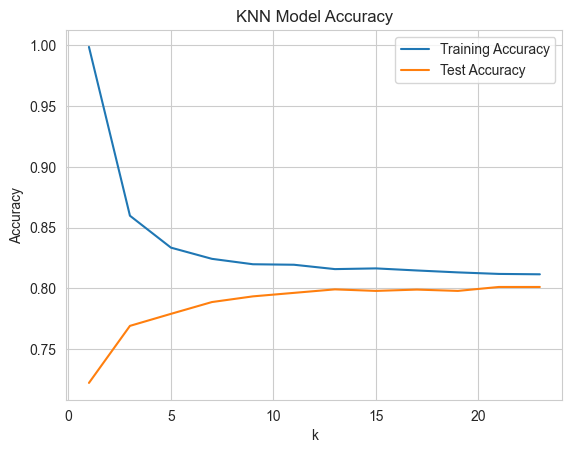

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X5, y5, test_size=0.2, random_state=42)

k_values = range(1, 24, 2)
train_accuracy = []
test_accuracy = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    model.fit(X_train_scaled, y_train)
    
    y_train_pred = model.predict(X_train_scaled)
    X_test_scaled = scaler.transform(X_test)
    y_test_pred = model.predict(X_test_scaled)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

plt.plot(k_values, train_accuracy, label='Training Accuracy')
plt.plot(k_values, test_accuracy, label='Test Accuracy')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('KNN Model Accuracy')
plt.legend()
plt.show()

It can be seen that from k=15 the improvement of the f1 is relatively low, therefore for the purpose of optimizing running times and calculation power we chose to run up to k=15.

In [141]:
def optimize_knn_model(X, y, feature_selection):
    """
    Optimize the K-Nearest Neighbors model with different hyperparameters and feature selections.

    Parameters:
        X (numpy array): Input feature matrix.
        y (numpy array): Target labels.
        feature_selection (function): The feature selection function to be used.

    Returns:
        tuple: A tuple containing the best hyperparameters and features for the KNN model, along with the best scaler
               and the corresponding F1 score.
    """
    scalers=[RobustScaler,StandardScaler,MinMaxScaler]
    
    k_range = range(3, 16, 2)
    p = [1,2]
    
    best_F1_score=0
    cum_F1_score=0

    if feature_selection==random_selection:
        feature_combinations=random_selection(X)
        k_p_features_combinations = list(product(k_range, feature_combinations, p))
        k_p_features_combinations = random.sample(k_p_features_combinations, 100)
    
        for com in k_p_features_combinations:
            k, feat, p = com
            
            for scaler1 in scalers:
                scaler = scaler1()

                for fold in range(5):
                    rel_X = X[:, list(feat)]
                    indices = np.random.permutation(rel_X.shape[0])
                    idx_train, idx_val = indices[:int(0.8 * rel_X.shape[0])], indices[int(0.8 * rel_X.shape[0]):]
                    X_train, X_val = rel_X[idx_train], rel_X[idx_val, :]
                    y_train, y_val = y[idx_train], y[idx_val]
                    X_train_scaled = scaler.fit_transform(X_train)
                    X_val_scaled = scaler.transform(X_val)
                    model = KNeighborsClassifier(n_neighbors=k,p=p)
                    model.fit(X_train_scaled, y_train)
                    y_pred = model.predict(X_val_scaled)
                    F1_tmp_score = f1_score(y_val, y_pred, average='weighted')
                    cum_F1_score += F1_tmp_score

                avg_F1_score=cum_F1_score/5

                if best_F1_score<avg_F1_score:
                    best_scaler=scaler1.__name__
                    best_k=k
                    best_features=feat
                    best_p=p
                    best_F1_score=avg_F1_score
                cum_F1_score=0

        return best_k,best_features,best_p,best_scaler,best_F1_score

    else:
        if feature_selection==forward_selection:
            feat_number=[5,10] ##as you can see below it take to long to run 15,20 so you take just 5,10
        if feature_selection==selection_by_importances:
            feat_number=[5,10,15,20]
        
        k_p_combinations = list(product(k_range, p))
        k_p_combinations = random.sample(k_p_combinations, 50)

        for feat_num in feat_number:
            if feature_selection==forward_selection:
                feat=feature_selection(KNeighborsClassifier(),feat_num, X , y)
            if feature_selection==selection_by_importances:
                feat= selection_by_importances(X, y,feat_num)
            
            for scaler1 in scalers:
                scaler = scaler1()

                for com in k_p_combinations:
                    k,p = com

                    for fold in range(5):
                        rel_X = X[:, feat]
                        indices = np.random.permutation(rel_X.shape[0])
                        idx_train, idx_val = indices[:int(0.8 * rel_X.shape[0])], indices[int(0.8 * rel_X.shape[0]):]
                        X_train, X_val = rel_X[idx_train], rel_X[idx_val, :]
                        y_train, y_val = y[idx_train], y[idx_val]
                        X_train_scaled = scaler.fit_transform(X_train)
                        X_val_scaled = scaler.transform(X_val)
                        model = KNeighborsClassifier(n_neighbors=k,p=p)
                        model.fit(X_train_scaled, y_train)
                        y_pred = model.predict(X_val_scaled)
                        F1_tmp_score = f1_score(y_val, y_pred, average='weighted')
                        cum_F1_score += F1_tmp_score

                    avg_F1_score=cum_F1_score/5

                    if best_F1_score<avg_F1_score:
                        best_scaler=scaler1.__name__
                        best_k=k
                        best_features=feat
                        best_p=p
                        best_F1_score=avg_F1_score
                    
                    cum_F1_score=0
        return best_k, best_features, best_p,best_scaler,best_F1_score

In [142]:
feat_number = [5, 10, 15, 20]

for feat_num in feat_number:
    # Suppress the FutureWarning
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    start_time = time.time()
    
    selected_features = forward_selection(KNeighborsClassifier(), feat_num, X3, y3)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print("Done", feat_num)
    print("Elapsed Time:", elapsed_time, "seconds")

Done 5
Elapsed Time: 51.397125005722046 seconds
Done 10
Elapsed Time: 85.5921516418457 seconds
Done 15
Elapsed Time: 55.29938101768494 seconds
Done 20
Elapsed Time: 51.88535928726196 seconds


In [128]:
def update_knn_summery(dic,education_method,marriage_method,best_k,best_selected_features,best_metric,best_scaler,F1):
    dic['education_method'].append(education_method)
    dic['marriage_method'].append(marriage_method)
    dic['best_k'].append(best_k)
    dic['best_selected_features'].append(best_selected_features)
    dic['best_p'].append(best_metric)
    dic['best_scaler'].append(best_scaler)
    dic['F1_score'].append(F1)

In [129]:
def Knn_Best_Parameters(knn_dic_summery):
    knn_summery = pd.DataFrame(knn_dic_summery)
    max_f1_index = knn_summery['F1_score'].idxmax()
    max_f1_row = knn_summery.iloc[max_f1_index]

    best_education_method = max_f1_row['education_method']
    best_marriage_method = max_f1_row['marriage_method']
    best_k = max_f1_row['best_k']
    best_selected_features = max_f1_row['best_selected_features']
    best_p = max_f1_row['best_p']
    best_scaler=max_f1_row['best_scaler']

    return(best_education_method,best_marriage_method,best_k,best_selected_features,best_p,best_scaler)

In [819]:
def knn_model_evaluation(best_education_method,best_marriage_method,best_k,best_selected_features,best_p,best_scaler,Period,selection_method=None,comparison_type=None,cmpr_dic=None):
    """
    Evaluate the K-Nearest Neighbors (KNN) model's performance on the dataset.

    Parameters:
        best_education_method (str): The best education method for filling missing values.
        best_marriage_method (str): The best marriage method for filling missing values.
        best_k (int): The best value of K (number of neighbors) for the KNN model.
        best_selected_features (list): The best selected features for training the model.
        best_p (int): The best value for the power parameter of the Minkowski distance metric.
        best_scaler (str): The name of the best data scaler for preprocessing.
        Period (int): The period of data used for evaluation.
        selection_method (function, optional): The feature selection method used. Defaults to None.
        comparison_type (function, optional): The comparison method used for updating summary results. Defaults to None.
        cmpr_dic (dict, optional): The dictionary used for comparison summary. Defaults to None.

    Returns:
        dict: A dictionary containing performance metrics (F1, recall, precision, and accuracy) of the KNN model.
    """
    X,y=identify_relevant_data(best_education_method, best_marriage_method,Period)
    
    scaler = eval(best_scaler)()

    total_weighted_f1 = 0
    weighted_recall = 0
    weighted_precision = 0
    weighted_accuracy = 0

    Knn_fpr = []
    Knn_tpr = []
    Knn_roc_auc=0

    for fold in range(5): 
        rel_X = X[:, best_selected_features]
        indices = np.random.permutation(rel_X.shape[0])
        idx_train, idx_val = indices[:int(0.7 * rel_X.shape[0])], indices[int(0.7 * rel_X.shape[0]):]
        X_train, X_val = rel_X[idx_train], rel_X[idx_val, :]
        y_train, y_val = y[idx_train], y[idx_val]

        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        KNN_best_model = KNeighborsClassifier(n_neighbors=best_k, p=best_p)
        KNN_best_model.fit(X_train_scaled, y_train)

        y_prob = KNN_best_model.predict_proba(X_val_scaled)
        y_pred = KNN_best_model.predict(X_val_scaled)

        total_weighted_f1 += f1_score(y_val, y_pred, average='weighted')
        weighted_recall += recall_score(y_val, y_pred, average='weighted')
        weighted_precision += precision_score(y_val, y_pred, average='weighted')
        weighted_accuracy += accuracy_score(y_val, y_pred)

        fpr, tpr, _ = roc_curve(y_val, y_prob[:, 1])
        Knn_roc_auc += roc_auc_score(y_val, y_prob[:, 1])

        Knn_fpr.append(fpr)
        Knn_tpr.append(tpr)


    weighted_f1 = total_weighted_f1 / 5
    weighted_recall /= 5
    weighted_precision /= 5
    weighted_accuracy /= 5

    Knn_fpr_tmp = np.linspace(0, 1, 100)
    Knn_tpr = np.mean([np.interp(Knn_fpr_tmp, fpr, tpr) for fpr, tpr in zip(Knn_fpr, Knn_tpr)], axis=0)
    Knn_fpr=Knn_fpr_tmp

    Knn_roc_auc = Knn_roc_auc / 5

    if comparison_type.__name__=='update_models_general_summery':
        update_models_general_summery('KNN',selection_method,best_scaler,best_education_method,best_marriage_method,best_selected_features,
                                     {'best_k':best_k,'best_p':best_p},Period,weighted_f1,
                                     {'recall':weighted_recall,'precision': weighted_precision,'accuracy': weighted_accuracy,
                                      'FPR':Knn_fpr,'TPR':Knn_tpr,'roc_auc':Knn_roc_auc})
    
    elif comparison_type.__name__=='update_models_by_period_summery':
        comparison_type(cmpr_dic,'KNN',Period,weighted_f1,weighted_recall,weighted_precision,weighted_accuracy,Knn_roc_auc,Knn_fpr,Knn_tpr)
    
    elif comparison_type.__name__=='update_models_by_feature_selection_method_summery':
        comparison_type(cmpr_dic,'KNN',selection_method,weighted_f1,weighted_recall,weighted_precision,weighted_accuracy,Knn_roc_auc,Knn_fpr,Knn_tpr)
    
    dic_results = {
        'F1': weighted_f1,
        'recall': weighted_recall,
        'precision': weighted_precision,
        'accuracy': weighted_accuracy
    }
    
    return(dic_results)

### Logistic Regression

Our objective is to identify the optimal combination of hyperparameters and features that maximizes the F1 score, a performance metric that effectively balances precision and recall. This approach is particularly important when dealing with imbalanced data, as it helps mitigate assessment challenges caused by uneven class distributions.

To facilitate a comprehensive analysis, we introduce a binary parameter that enables us to toggle the usage of the class_weighted parameter. By doing so, we can evaluate the impact of class imbalance on our models.

Furthermore, we define a range of hyperparameters for optimization, including n_iters (number of iterations), epss (convergence tolerance), penalties (regularization type), and thresholds (classification thresholds). Additionally, we incorporate a variety of feature scaling techniques, such as RobustScaler, StandardScaler, and MinMaxScaler, to standardize the input features.

Additionally, we incorporate three feature selection techniques: random selection, forward selection, and selection by importances, as discussed previously. For each technique, we generate combinations of hyperparameters, features, and penalties, selecting a subset of these combinations. Cross-validation with 5-fold is performed for each combination, calculating the average F1 score. The configuration with the best hyperparameters, features, penalty, scaler, and F1 score is then stored and returned.

By systematically exploring different combinations of hyperparameters and features, considering multiple scalers, and incorporating feature selection techniques, our strategy enables us to identify the optimal configuration for the logistic regression model that yields the highest F1 score for the given dataset.

In [498]:
def optimize_logistic_regression_model(X, y,feature_selection,imbalance=0):
    """
    Optimize the logistic regression model by tuning hyperparameters and selecting features.

    Parameters:
        X (numpy.ndarray): The input feature matrix.
        y (numpy.ndarray): The target labels.
        feature_selection (function): The method used for feature selection.
        imbalance (int, optional): The indicator for handling class imbalance. Set to 1 for balanced class weights, 0 otherwise. Defaults to 0.

    Returns:
        tuple: A tuple containing the best selected features, hyperparameters (n_iter, eps, penalty, threshold), best scaler, and F1 score of the optimized logistic regression model.
    """
    
    if imbalance==0:
        class_weighted=None
    else:
        class_weighted='balanced'
    
    n_iters = [1000, 2000, 5000]
    epss = [0.01, 0.001, 0.0001]
    penalties = ['l1', 'l2']
    thresholds = [0.40, 0.50, 0.60]
    
    thres_dic={}
    best_f1_score=0
    
    scalers=[RobustScaler,StandardScaler,MinMaxScaler]
    
    if feature_selection==random_selection:
        feature_combinations=random_selection(X)
        n_iters_epss_penalties_feature_combinations_combinations = list(product(n_iters,epss,penalties,feature_combinations))
        n_iters_epss_penalties_feature_combinations_combinations = random.sample(n_iters_epss_penalties_feature_combinations_combinations, 100)
        
        for com in n_iters_epss_penalties_feature_combinations_combinations:
            n_iter,eps,penalty,selected_features=com
            
            for threshold in thresholds:
                for scaler in scalers:
                    thres_dic[threshold,scaler.__name__]=0
                    
            for fold in range(5): 
                rel_X = X[:,selected_features]
                indices = np.random.permutation(rel_X.shape[0])
                idx_train, idx_val = indices[:int(0.7*rel_X.shape[0])], indices[int(0.7*rel_X.shape[0]):]
                X_train, X_val = rel_X[idx_train], rel_X[idx_val,:]
                y_train, y_val = y[idx_train], y[idx_val]

                model=LogisticRegression(max_iter=n_iter, tol=eps, solver='liblinear', penalty=penalty,class_weight=class_weighted)
                
                for scaler in scalers:
                    scaler1=scaler()
                    X_train = scaler1.fit_transform(X_train)
                    X_val = scaler1.transform(X_val)

                    model.fit(X_train, y_train)

                    y_prob = model.predict_proba(X_val)
                
                    for threshold in thresholds:
                        y_pred = (y_prob[:, 1] >= threshold).astype(int)  
                        thres_dic[threshold,scaler.__name__] += f1_score(y_val, y_pred, average='weighted')
            for threshold in thresholds:
                for scaler in scalers:
                    thres_dic[threshold,scaler.__name__] /=5
            
            threshold,scaler_best = max(thres_dic, key=thres_dic.get)
            F1_score=thres_dic[threshold,scaler_best]

            if F1_score > best_f1_score:
                best_scaler=scaler_best
                best_f1_score = F1_score
                best_features = selected_features
                best_n_iter = n_iter
                best_eps = eps
                best_penalty = penalty
                best_threshold = threshold
        return(best_features, best_n_iter, best_eps, best_penalty, best_threshold,best_scaler, best_f1_score)
    
   
    
    else:
         
        if feature_selection==forward_selection:
            feat_number=[5,10,15,20] ##as you can see below it take not too long to run
        if feature_selection==selection_by_importances:
            feat_number=[5,10,15,20]
        
        n_iters_epss_penalties_combinations = list(product(n_iters,epss,penalties))
        n_iters_epss_penalties_combinations = random.sample(n_iters_epss_penalties_combinations, 10)
        
        for feat_num in feat_number:
            if feature_selection==forward_selection:
                selected_features=feature_selection(KNeighborsClassifier(),feat_num, X , y)
            if feature_selection==selection_by_importances:
                selected_features= selection_by_importances(X, y,feat_num)

            for com in n_iters_epss_penalties_combinations:
                n_iter,eps,penalty=com

                for threshold in thresholds:
                    for scaler in scalers:
                        thres_dic[threshold,scaler.__name__]=0

                for fold in range(5): 
                    rel_X = X[:,selected_features]
                    indices = np.random.permutation(rel_X.shape[0])
                    idx_train, idx_val = indices[:int(0.7*rel_X.shape[0])], indices[int(0.7*rel_X.shape[0]):]
                    X_train, X_val = rel_X[idx_train], rel_X[idx_val,:]
                    y_train, y_val = y[idx_train], y[idx_val]

                    model=LogisticRegression(max_iter=n_iter, tol=eps, solver='liblinear', penalty=penalty,class_weight=class_weighted)

                    for scaler in scalers:
                        scaler1=scaler()
                        X_train = scaler1.fit_transform(X_train)
                        X_val = scaler1.transform(X_val)

                        model.fit(X_train, y_train)

                        y_prob = model.predict_proba(X_val)

                        for threshold in thresholds:
                            y_pred = (y_prob[:, 1] >= threshold).astype(int)  
                            thres_dic[threshold,scaler.__name__] += f1_score(y_val, y_pred, average='weighted')
                for threshold in thresholds:
                    for scaler in scalers:
                        thres_dic[threshold,scaler.__name__] /=5

                threshold,scaler_best = max(thres_dic, key=thres_dic.get)
                F1_score=thres_dic[threshold,scaler_best]

                if F1_score > best_f1_score:
                    best_scaler=scaler_best
                    best_f1_score = F1_score
                    best_features = list(selected_features)
                    best_n_iter = n_iter
                    best_eps = eps
                    best_penalty = penalty
                    best_threshold = threshold
            return(best_features, best_n_iter, best_eps, best_penalty, best_threshold,best_scaler, best_f1_score)

In [688]:
feat_number = [5, 10, 15, 20]

for feat_num in feat_number:
    # Suppress the FutureWarning
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    start_time = time.time()
    
    selected_features = forward_selection(LogisticRegression(max_iter=5000), feat_num,X3, y3)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print("Done", feat_num)
    print("Elapsed Time:", elapsed_time, "seconds")

Done 5
Elapsed Time: 6.113399982452393 seconds
Done 10
Elapsed Time: 4.633657932281494 seconds
Done 15
Elapsed Time: 8.268634796142578 seconds
Done 20
Elapsed Time: 6.24407696723938 seconds


In [310]:
def update_models_summery_LG(dic,education_method,marriage_method,selected_features,n_iter,eps,penalty,threshold,imbalance,scaler,F1):
    dic['education_method'].append(education_method)
    dic['marriage_method'].append(marriage_method)
    dic['selected_features'].append(selected_features)
    dic['n_iter'].append(n_iter)
    dic['eps'].append(eps)
    dic['penalty'].append(penalty)
    dic['threshold'].append(threshold)
    dic['imbalance'].append(imbalance)
    dic['scaler'].append(scaler)
    dic['F1_score'].append(F1)

In [311]:
def LG_Best_Parameters(LG_dic_summery):
    LG_summery = pd.DataFrame(LG_dic_summery)
    max_f1_index = LG_summery['F1_score'].idxmax()

    max_f1_row = LG_summery.iloc[max_f1_index]

    best_education_method = max_f1_row['education_method']
    best_marriage_method = max_f1_row['marriage_method']
    best_selected_features = max_f1_row['selected_features']
    best_n_iter = max_f1_row['n_iter']
    best_eps = max_f1_row['eps']
    best_penalty = max_f1_row['penalty']
    best_threshold = max_f1_row['threshold']
    best_imbalance = max_f1_row['imbalance']
    best_scaler=max_f1_row['scaler']
    return(best_education_method,best_marriage_method,best_selected_features,best_n_iter,best_eps,best_penalty,best_threshold,best_imbalance,best_scaler)

In [825]:
def LG_model_evaluation(best_education_method,best_marriage_method,best_selected_features,best_n_iter,best_eps,best_penalty,best_threshold,best_imbalance,best_scaler,Period,selection_method=None,comparison_type=None,cmpr_dic=None):
    
    """
    Evaluate the logistic regression model with the optimized hyperparameters and feature selection.

    Parameters:
        best_education_method (str): The selected method for handling missing education data.
        best_marriage_method (str): The selected method for handling missing marriage data.
        best_selected_features (list): The list of selected features.
        best_n_iter (int): The optimized number of iterations.
        best_eps (float): The optimized tolerance value.
        best_penalty (str): The optimized penalty method ('l1' or 'l2').
        best_threshold (float): The optimized threshold value for binary classification.
        best_imbalance (str): The indicator for handling class imbalance ('Regular' or 'balanced').
        best_scaler (str): The name of the selected scaler.
        Period (str): The time period of the data.
        selection_method (function, optional): The method used for feature selection. Defaults to None.
        comparison_type (function, optional): The method used for comparison and summary update. Defaults to None.
        cmpr_dic (dict, optional): The dictionary containing comparison results. Defaults to None.

    Returns:
        dict: A dictionary containing the evaluation results with F1 score, recall, precision, and accuracy.
    """

    X,y=identify_relevant_data(best_education_method, best_marriage_method,Period)
    
    scaler = eval(best_scaler)()

    total_weighted_f1 = 0
    weighted_recall = 0
    weighted_precision = 0
    weighted_accuracy = 0
    lg_fpr = []
    lg_tpr = []
    lg_roc_auc=0
        
    if best_imbalance=='Regular':
        class_weighted=None
    else:
        class_weighted='balanced'

    for fold in range(5):
        rel_X = X[:, best_selected_features]
        indices = np.random.permutation(rel_X.shape[0])
        idx_train, idx_val = indices[:int(0.7 * rel_X.shape[0])], indices[int(0.7 * rel_X.shape[0]):]
        X_train, X_val = rel_X[idx_train], rel_X[idx_val, :]
        y_train, y_val = y[idx_train], y[idx_val]

        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        best_LG = LogisticRegression(max_iter=best_n_iter, tol=best_eps, solver='liblinear', penalty=best_penalty,class_weight=class_weighted)

        best_LG.fit(X_train_scaled, y_train)

        y_prob = best_LG.predict_proba(X_val_scaled)
        y_pred = (y_prob[:, 1] >= best_threshold).astype(int)

        fpr, tpr, _ = roc_curve(y_val, y_prob[:, 1])
        lg_roc_auc += roc_auc_score(y_val, y_prob[:, 1])

        lg_fpr.append(fpr)
        lg_tpr.append(tpr)

        total_weighted_f1 += f1_score(y_val, y_pred, average='weighted')
        weighted_recall += recall_score(y_val, y_pred, average='weighted')
        weighted_precision += precision_score(y_val, y_pred, average='weighted')
        weighted_accuracy += accuracy_score(y_val, y_pred)

    weighted_f1 = total_weighted_f1 / 5
    weighted_recall /= 5
    weighted_precision /= 5
    weighted_accuracy /= 5

    lg_fpr_tmp = np.linspace(0, 1, 100)
    lg_tpr = np.mean([np.interp(lg_fpr_tmp, fpr, tpr) for fpr, tpr in zip(lg_fpr, lg_tpr)], axis=0)
    lg_fpr=lg_fpr_tmp

    lg_roc_auc = lg_roc_auc / 5
    
    if comparison_type.__name__=='update_models_general_summery':
        update_models_general_summery('LG',selection_method,best_scaler,best_education_method,best_marriage_method,best_selected_features,
                          {'n_iter':best_n_iter,'Eps':best_eps,'Penalty':best_penalty,'Threshold':best_threshold,'imbalance':best_imbalance},Period,weighted_f1,
                          {'recall':weighted_recall,'precision': weighted_precision,'accuracy': weighted_accuracy,
                          'FPR':lg_fpr,'TPR':lg_tpr,'roc_auc':lg_roc_auc})
    
    elif comparison_type.__name__=='update_models_by_period_summery':
        comparison_type(cmpr_dic,'LG',Period,weighted_f1,weighted_recall,weighted_precision,weighted_accuracy,lg_roc_auc,lg_fpr,lg_tpr)
    
    elif comparison_type.__name__=='update_models_by_feature_selection_method_summery':
        comparison_type(cmpr_dic,'LG',selection_method,weighted_f1,weighted_recall,weighted_precision,weighted_accuracy,lg_roc_auc,lg_fpr,lg_tpr)
        


    dic_results = {
        'F1': weighted_f1,
        'recall': weighted_recall,
        'precision': weighted_precision,
        'accuracy': weighted_accuracy
    }

    return(dic_results)

### Random Forest

Our objective is to optimize the performance of the random forest model by identifying the best combination of hyperparameters and features. To achieve this, we consider different scenarios regarding class imbalance in the target variable, as indicated by the imbalance parameter. If imbalance is set to 1, the class_weighted parameter is not applied, while setting it to 0 enables the use of the 'balanced' class weighting.

We start by defining a range of hyperparameters to be optimized, including the number of estimators (n_estimators), the criterion for splitting (criterion), the maximum depth of the tree (max_depth), the minimum number of samples required to split an internal node (min_samples_split), the minimum number of samples required to be at a leaf node (min_samples_leaf), and the maximum number of features to consider when looking for the best split (max_features).

Next, we introduce a set of scalers, including RobustScaler, StandardScaler, and MinMaxScaler, which are applied to the input features to standardize them.

Depending on the chosen feature selection technique (feature_selection), such as random selection, forward selection, or selection by importances, we generate combinations of hyperparameters, features, and penalties. For each combination, we perform 5-fold cross-validation and calculate the average F1 score as the performance metric. The configuration with the highest F1 score is stored as the best configuration.

Finally, we return the best combination of hyperparameters (best_n_estimators, best_criterion, best_max_depth, best_min_samples_split, best_min_samples_leaf, best_max_features), the list of selected features (best_select_features), the chosen scaler (best_scaler), and the highest F1 score achieved (best_f1_score).

This strategy enables us to systematically explore various combinations of hyperparameters and features, considering different scalers and feature selection techniques, ultimately identifying the optimal configuration for the random forest model that maximizes the F1 score for the given dataset.

In [668]:
def optimize_random_forest_model(X, y, feature_selection,imbalance=0):
    """
    Optimize the Random Forest model by tuning hyperparameters and selecting features.

    Parameters:
        X (numpy.ndarray): The input feature matrix.
        y (numpy.ndarray): The target labels.
        feature_selection (function): The method used for feature selection.
        imbalance (int, optional): Indicator for handling class imbalance. Defaults to 0.

    Returns:
        tuple: A tuple containing the best hyperparameters and selected features.
            - best_n_estimators (int): The optimized number of estimators.
            - best_criterion (str): The optimized criterion ('gini' or 'entropy').
            - best_max_depth (str or None): The optimized maximum depth.
            - best_min_samples_split (int): The optimized minimum samples for split.
            - best_min_samples_leaf (int): The optimized minimum samples for leaf.
            - best_max_features (str or float): The optimized maximum features.
            - best_select_features (list): The list of selected features.
            - best_scaler (str): The name of the selected scaler.
            - best_f1_score (float): The F1 score achieved by the best model.
    """

    if imbalance==0:
        class_weighted=None
    else:
        class_weighted='balanced'
    
    n_estimators = [50, 100, 200]
    criterion = ['gini', 'entropy']
    max_depth = [None, 5, 10]
    min_samples_split = [2, 10, 50]
    min_samples_leaf = [1, 5, 10]
    max_features = ['auto', 0.3, 0.5, 0.7]
    
    scalers=[RobustScaler,StandardScaler,MinMaxScaler]
    
    best_f1_score=0
        
    if feature_selection==random_selection:
        feature_combinations=random_selection(X)
        hyperparameter_combinations = list(itertools.product(n_estimators, criterion, max_depth,
                                                        min_samples_split, min_samples_leaf, max_features,feature_combinations))
        hyperparameter_combinations = random.sample(hyperparameter_combinations, 40)

        for hyperparameters in hyperparameter_combinations:
            n_estimator, crit, depth, split, leaf, feat,select_features = hyperparameters
            model = RandomForestClassifier(n_estimators=n_estimator, criterion=crit, max_depth=depth,
                                            min_samples_split=split, min_samples_leaf=leaf, max_features=feat,class_weight=class_weighted)

            for scaler1 in scalers:
                scaler = scaler1()
                F1_score=0
                
                for fold in range(5): 
                    rel_X = X[:, select_features]
                    indices = np.random.permutation(rel_X.shape[0])
                    idx_train, idx_val = indices[:int(0.7 * rel_X.shape[0])], indices[int(0.7 * rel_X.shape[0]):]
                    X_train, X_val = rel_X[idx_train], rel_X[idx_val, :]
                    y_train, y_val = y[idx_train], y[idx_val]

                    X_train = scaler.fit_transform(X_train)
                    X_val = scaler.transform(X_val)

                    model.fit(X_train, y_train)

                    y_pred = model.predict(X_val)
                    F1_score += f1_score(y_val, y_pred, average='weighted')

                F1_score/=5

                if F1_score > best_f1_score:
                    best_f1_score = F1_score
                    best_n_estimators = n_estimator
                    best_criterion = crit
                    best_scaler=scaler1.__name__
                    
                    if depth==None:
                        best_max_depth='None'
                    else:
                        best_max_depth = depth
                        
                    best_min_samples_split = split
                    best_min_samples_leaf = leaf
                    best_max_features = feat
                    best_select_features=select_features

        return best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,list(best_select_features),best_scaler,best_f1_score
    
    
    else:
        hyperparameter_combinations = list(itertools.product(n_estimators, criterion, max_depth,
                                                        min_samples_split, min_samples_leaf, max_features))
        hyperparameter_combinations = random.sample(hyperparameter_combinations, 40)

        if feature_selection==forward_selection:
            feat_number=[5] ##as you can see below it take to long to run 5,10 so you take just 15,20
        if feature_selection==selection_by_importances:
            feat_number=[5,10,15,20]

        for feat_num in feat_number:
            if feature_selection==forward_selection:
                select_features=feature_selection(KNeighborsClassifier(),feat_num, X , y)
            if feature_selection==selection_by_importances:
                select_features= selection_by_importances(X, y,feat_num)
                    
            for hyperparameters in hyperparameter_combinations:
                n_estimator, crit, depth, split, leaf, feat = hyperparameters
                model = RandomForestClassifier(n_estimators=n_estimator, criterion=crit, max_depth=depth,
                                                        min_samples_split=split, min_samples_leaf=leaf, max_features=feat,class_weight=class_weighted)

                for scaler1 in scalers:
                    scaler = scaler1()
                    F1_score=0

                    for fold in range(5): 
                        rel_X = X[:, select_features]
                        indices = np.random.permutation(rel_X.shape[0])
                        idx_train, idx_val = indices[:int(0.7 * rel_X.shape[0])], indices[int(0.7 * rel_X.shape[0]):]
                        X_train, X_val = rel_X[idx_train], rel_X[idx_val, :]
                        y_train, y_val = y[idx_train], y[idx_val]

                        X_train = scaler.fit_transform(X_train)
                        X_val = scaler.transform(X_val)

                        model.fit(X_train, y_train)

                        y_pred = model.predict(X_val)
                        F1_score += f1_score(y_val, y_pred, average='weighted')

                    F1_score/=5

                    if F1_score > best_f1_score:
                        best_f1_score = F1_score
                        best_n_estimators = n_estimator
                        best_criterion = crit
                        best_scaler=scaler1.__name__

                        if depth==None:
                            best_max_depth='None'
                        else:
                            best_max_depth = depth

                        best_min_samples_split = split
                        best_min_samples_leaf = leaf
                        best_max_features = feat
                        best_select_features=select_features

        return best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,list(best_select_features),best_scaler,best_f1_score

In [317]:
feat_number = [5, 10, 15, 20]

for feat_num in feat_number:
    # Suppress the FutureWarning
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    start_time = time.time()
    
    selected_features = forward_selection(RandomForestClassifier(), feat_num, X1, y1)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print("Done", feat_num)
    print("Elapsed Time:", elapsed_time, "seconds")


Done 5
Elapsed Time: 392.60246109962463 seconds
Done 10
Elapsed Time: 390.7408549785614 seconds
Done 15
Elapsed Time: 367.4458668231964 seconds
Done 20
Elapsed Time: 595.5274949073792 seconds


In [318]:
def update_models_summery_RF(dic,education_method,marriage_method,n_estimators,criterion,max_depth,min_samples_split,min_samples_leaf,max_features,select_features,imbalance,scaler,F1):
    dic['education_method'].append(education_method)
    dic['marriage_method'].append(marriage_method)
    dic['n_estimators'].append(n_estimators)
    dic['criterion'].append(criterion)
    dic['max_depth'].append(max_depth)
    dic['min_samples_split'].append(min_samples_split)
    dic['min_samples_leaf'].append(min_samples_leaf)
    dic['max_features'].append(max_features)
    dic['select_features'].append(select_features)
    dic['imbalance'].append(imbalance)
    dic['scaler'].append(scaler)
    dic['F1_score'].append(F1)

In [319]:
def RF_Best_Parameters(RF_dic_summery):

    RF_random_selection = pd.DataFrame(RF_dic_summery)

    max_f1_index = RF_random_selection['F1_score'].idxmax()
    max_f1_row = RF_random_selection.iloc[max_f1_index]

    best_education_method = max_f1_row['education_method']
    best_marriage_method = max_f1_row['marriage_method']
    best_n_estimators_RF = max_f1_row['n_estimators']
    best_criterion_RF = max_f1_row['criterion']
    best_max_depth_RF = max_f1_row['max_depth']
    best_min_samples_split_RF = max_f1_row['min_samples_split']
    best_min_samples_leaf_RF = max_f1_row['min_samples_leaf']
    best_max_features_RF = max_f1_row['max_features']
    best_select_features = max_f1_row['select_features']
    best_imbalance = max_f1_row['imbalance']
    best_scaler = max_f1_row['scaler']

    return(best_education_method,best_marriage_method,best_n_estimators_RF,best_criterion_RF,best_max_depth_RF,best_min_samples_split_RF,best_min_samples_leaf_RF,best_max_features_RF,best_select_features,best_imbalance,best_scaler)

In [772]:
def RF_model_evaluation(best_education_method,best_marriage_method,best_n_estimators_RF,best_criterion_RF,best_max_depth_RF,best_min_samples_split_RF,best_min_samples_leaf_RF,best_max_features_RF,best_select_features,best_imbalance,best_scaler,Period,selection_method,comparison_type,cmpr_dic=None):
    """
    Evaluate the Random Forest model using the best hyperparameters and selected features.

    Parameters:
        best_education_method (str): The selected education method.
        best_marriage_method (str): The selected marriage method.
        best_n_estimators_RF (int): The optimized number of estimators for Random Forest.
        best_criterion_RF (str): The optimized criterion for Random Forest.
        best_max_depth_RF (int or None): The optimized maximum depth for Random Forest.
        best_min_samples_split_RF (int): The optimized minimum samples required to split a node for Random Forest.
        best_min_samples_leaf_RF (int): The optimized minimum samples required to be at a leaf node for Random Forest.
        best_max_features_RF (str or float): The optimized number of features to consider when looking for the best split for Random Forest.
        best_select_features (list): The list of selected features for the model.
        best_imbalance (str): The method for handling class imbalance ('Regular' or 'balanced').
        best_scaler (str): The name of the selected scaler for feature scaling.
        Period (str): The time period for the evaluation.
        selection_method (function): The method used for feature selection.
        comparison_type (function): The method used for comparison.
        cmpr_dic (dict, optional): Dictionary for comparison results. Defaults to None.

    Returns:
        dict: A dictionary containing evaluation results:
            - 'F1' (float): The weighted F1 score.
            - 'recall' (float): The weighted recall score.
            - 'precision' (float): The weighted precision score.
            - 'accuracy' (float): The weighted accuracy score.
    """

    X,y=identify_relevant_data(best_education_method, best_marriage_method,Period)
    
    scaler = eval(best_scaler)()

    if best_imbalance=='Regular':
        class_weighted=None
    else:
        class_weighted='balanced'

    if best_max_depth_RF=='None':
        best_max_depth_RF=None

    total_weighted_f1 = 0
    weighted_recall = 0
    weighted_precision = 0
    weighted_accuracy = 0
    rf_fpr = []
    rf_tpr = []
    rf_roc_auc=0

    for fold in range(5):
        rel_X = X[:, best_select_features]
        indices = np.random.permutation(rel_X.shape[0])
        idx_train, idx_val = indices[:int(0.7 * rel_X.shape[0])], indices[int(0.7 * rel_X.shape[0]):]
        X_train, X_val = rel_X[idx_train], rel_X[idx_val, :]
        y_train, y_val = y[idx_train], y[idx_val]

        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        best_RF = RandomForestClassifier(n_estimators=best_n_estimators_RF,
                                         criterion=best_criterion_RF,
                                         max_depth=best_max_depth_RF,
                                         min_samples_split=best_min_samples_split_RF,
                                         min_samples_leaf=best_min_samples_leaf_RF,
                                         max_features=best_max_features_RF,
                                         class_weight=class_weighted)

        best_RF.fit(X_train_scaled, y_train)

        y_prob = best_RF.predict_proba(X_val_scaled)
        y_pred = best_RF.predict(X_val_scaled)

        fpr, tpr, _ = roc_curve(y_val, y_prob[:, 1])
        rf_roc_auc += roc_auc_score(y_val, y_prob[:, 1])

        rf_fpr.append(fpr)
        rf_tpr.append(tpr)
                
        total_weighted_f1 += f1_score(y_val, y_pred, average='weighted')
        weighted_recall += recall_score(y_val, y_pred, average='weighted')
        weighted_precision += precision_score(y_val, y_pred, average='weighted')
        weighted_accuracy += accuracy_score(y_val, y_pred)

    weighted_f1 = total_weighted_f1 / 5
    weighted_recall /= 5
    weighted_precision /= 5
    weighted_accuracy /= 5
    
    rf_fpr_tmp = np.linspace(0, 1, 100)
    rf_tpr = np.mean([np.interp(rf_fpr_tmp, fpr, tpr) for fpr, tpr in zip(rf_fpr, rf_tpr)], axis=0)
    rf_fpr=rf_fpr_tmp

    rf_roc_auc = rf_roc_auc / 5

    dic_results = {
        'F1': weighted_f1,
        'recall': weighted_recall,
        'precision': weighted_precision,
        'accuracy': weighted_accuracy
    }
    
    if comparison_type.__name__=='update_models_general_summery':
        update_models_general_summery('RF',selection_method,best_scaler,best_education_method,best_marriage_method,best_select_features,
                          {'n_estimators':best_n_estimators_RF,'criterion':best_criterion_RF,'max_depth':best_max_depth_RF,'min_samples_split':best_min_samples_split_RF,'min_samples_leaf':best_min_samples_leaf_RF,'max_features':best_max_features_RF,'imbalance':best_imbalance},Period,weighted_f1,
                          {'recall':weighted_recall,'precision': weighted_precision,'accuracy': weighted_accuracy,
                          'FPR':rf_tpr,'TPR':rf_fpr,'roc_auc':rf_roc_auc})
    
    elif comparison_type.__name__=='update_models_by_period_summery':
        comparison_type(cmpr_dic,'RF',Period,weighted_f1,weighted_recall,weighted_precision,weighted_accuracy,rf_roc_auc,rf_tpr,rf_fpr)
    
    elif comparison_type.__name__=='update_models_by_feature_selection_method_summery':
        comparison_type(cmpr_dic,'RF',selection_method,weighted_f1,weighted_recall,weighted_precision,weighted_accuracy,rf_roc_auc,rf_tpr,rf_fpr)
    
    return(dic_results)

# Knn Model-
## <font color='navy'>Investigating Model Performance by Period:</font>
## A Period of 6 Months-
### <font color='darkblue'>Investigating Model Performance by feature Selection Methods for a Period of 6 Months:</font>
### Feature Selection Method 1: Random Selection-

In [141]:
knn_random_selection_dic={'education_method': [],
                          'marriage_method': [],
                          'best_k': [],
                          'best_selected_features': [],
                          'best_p': [],
                          'best_scaler':[],
                          'F1_score': []}

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X1,y1,random_selection)
update_knn_summery(knn_random_selection_dic,1,1,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X2,y2,random_selection)
update_knn_summery(knn_random_selection_dic,1,2,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X3,y3,random_selection)
update_knn_summery(knn_random_selection_dic,2,1,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X4,y4,random_selection)
update_knn_summery(knn_random_selection_dic,2,2,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X5,y5,random_selection)
update_knn_summery(knn_random_selection_dic,3,3,best_k,best_features,best_p,best_scaler,best_F1_score)

In [142]:
print_model_summery(knn_random_selection_dic)

In [143]:
Knn_RS_best_education_method,Knn_RS_best_marriage_method,Knn_RS_best_k,Knn_RS_best_selected_features,Knn_RS_best_p,Knn_RS_best_scaler=Knn_Best_Parameters(knn_random_selection_dic)

#### Best Knn Model by random selection: Scores

In [144]:
Knn_feature_selection_cmpr={}
Knn_feature_selection_cmpr=create_feature_selection_method_summery(Knn_feature_selection_cmpr)

In [145]:
dic_results=knn_model_evaluation(Knn_RS_best_education_method,Knn_RS_best_marriage_method,Knn_RS_best_k,Knn_RS_best_selected_features,Knn_RS_best_p,Knn_RS_best_scaler,6,'Random Selection',update_models_by_feature_selection_method_summery,cmpr_dic=Knn_feature_selection_cmpr)

In [146]:
Model_Performance_Metrics(dic_results,'Knn with Random Selection')

Performance Metrics for Knn with Random Selection

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.777923 |
+-----------+----------+
| recall    | 0.803387 |
+-----------+----------+
| precision | 0.779243 |
+-----------+----------+
| accuracy  | 0.803387 |
+-----------+----------+
Accuracy: 0.8033874215326305 - The model outperforms the prior model


### Feature Selection Method 2: Forward Selection

In [147]:
knn_random_selection_dic={'education_method': [],
                          'marriage_method': [],
                          'best_k': [],
                          'best_selected_features': [],
                          'best_p': [],
                          'best_scaler':[],
                          'F1_score': []}

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X1,y1,forward_selection)
update_knn_summery(knn_random_selection_dic,1,1,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X2,y2,forward_selection)
update_knn_summery(knn_random_selection_dic,1,2,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X3,y3,forward_selection)
update_knn_summery(knn_random_selection_dic,2,1,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X4,y4,forward_selection)
update_knn_summery(knn_random_selection_dic,2,2,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X5,y5,forward_selection)
update_knn_summery(knn_random_selection_dic,3,3,best_k,best_features,best_p,best_scaler,best_F1_score)

In [148]:
print_model_summery(knn_random_selection_dic)

In [149]:
Knn_FS_best_education_method,Knn_FS_best_marriage_method,Knn_FS_best_k,Knn_FS_best_selected_features,Knn_FS_best_p,Knn_FS_best_scaler=Knn_Best_Parameters(knn_random_selection_dic)

#### Best Knn Model by forward selection: Scores

In [150]:
dic_results=knn_model_evaluation(Knn_FS_best_education_method,Knn_FS_best_marriage_method,Knn_FS_best_k,Knn_FS_best_selected_features,Knn_FS_best_p,Knn_FS_best_scaler,6,'forward Selection',update_models_by_feature_selection_method_summery,cmpr_dic=Knn_feature_selection_cmpr)

In [151]:
Model_Performance_Metrics(dic_results,'Knn with Forward Selection')

Performance Metrics for Knn with Forward Selection

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.777076 |
+-----------+----------+
| recall    | 0.800545 |
+-----------+----------+
| precision | 0.776229 |
+-----------+----------+
| accuracy  | 0.800545 |
+-----------+----------+
Accuracy: 0.8005448300367168 - The model outperforms the prior model


### Feature Selection Method 3: selection by importances

In [152]:
knn_random_selection_dic={'education_method': [],
                          'marriage_method': [],
                          'best_k': [],
                          'best_selected_features': [],
                          'best_p': [],
                          'best_scaler':[],
                          'F1_score': []}

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X1,y1,selection_by_importances)
update_knn_summery(knn_random_selection_dic,1,1,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X2,y2,selection_by_importances)
update_knn_summery(knn_random_selection_dic,1,2,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X3,y3,selection_by_importances)
update_knn_summery(knn_random_selection_dic,2,1,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X4,y4,selection_by_importances)
update_knn_summery(knn_random_selection_dic,2,2,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X5,y5,selection_by_importances)
update_knn_summery(knn_random_selection_dic,3,3,best_k,best_features,best_p,best_scaler,best_F1_score)

In [153]:
print_model_summery(knn_random_selection_dic)

In [154]:
Knn_IS_best_education_method,Knn_IS_best_marriage_method,Knn_IS_best_k,Knn_IS_best_selected_features,Knn_IS_best_p,Knn_IS_best_scaler=Knn_Best_Parameters(knn_random_selection_dic)

#### Best Knn Model with selection by importances: Scores

In [155]:
dic_results=knn_model_evaluation(Knn_IS_best_education_method,Knn_IS_best_marriage_method,Knn_IS_best_k,Knn_IS_best_selected_features,Knn_IS_best_p,Knn_IS_best_scaler,6,'selection by importances',update_models_by_feature_selection_method_summery,cmpr_dic=Knn_feature_selection_cmpr)

In [156]:
Model_Performance_Metrics(dic_results,'Knn with Selection by Importances')

Performance Metrics for Knn with Selection by Importances

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.772465 |
+-----------+----------+
| recall    | 0.7991   |
+-----------+----------+
| precision | 0.772725 |
+-----------+----------+
| accuracy  | 0.7991   |
+-----------+----------+
Accuracy: 0.799099846026294 - The model outperforms the prior model


### Comparison of feature selection methods for the best knn models

In [158]:
print_cmpr_dic(Knn_feature_selection_cmpr)

Model_type Features_Selection_method  F1_score    recall  precision  \
0        KNN          Random Selection  0.777923  0.803387   0.779243   
1        KNN         forward Selection  0.777076  0.800545   0.776229   
2        KNN  selection by importances  0.772465  0.799100   0.772725   

   accuracy   roc_auc  
0  0.803387  0.724559  
1  0.800545  0.714481  
2  0.799100  0.719492

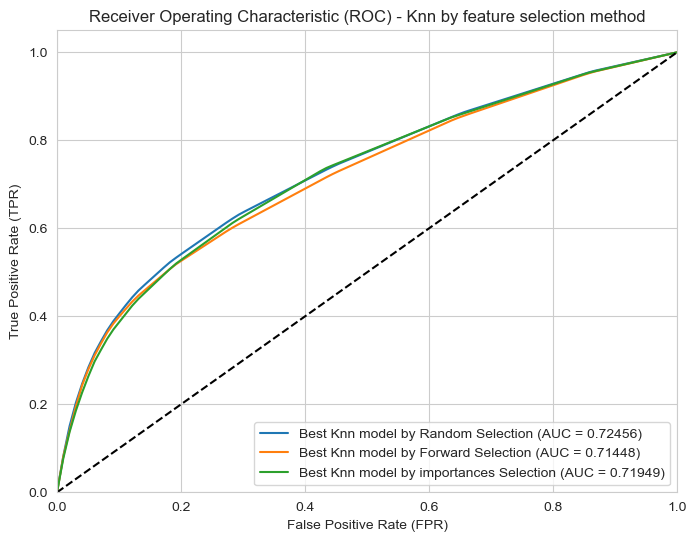

In [160]:
RS_fpr,RS_tpr,RS_roc_auc=get_fpr_tpr_auc(Knn_feature_selection_cmpr, 0)
FS_fpr,FS_tpr,FS_roc_auc=get_fpr_tpr_auc(Knn_feature_selection_cmpr, 1)
IS_fpr,IS_tpr,IS_roc_auc=get_fpr_tpr_auc(Knn_feature_selection_cmpr, 2)

# Plotting ROC curves
plt.figure(figsize=(8, 6))
plt.plot(RS_fpr,RS_tpr, label='Best Knn model by Random Selection (AUC = %0.5f)' % RS_roc_auc)
plt.plot(FS_fpr,FS_tpr, label='Best Knn model by Forward Selection (AUC = %0.5f)' % FS_roc_auc)
plt.plot(IS_fpr,IS_tpr, label='Best Knn model by importances Selection (AUC = %0.5f)' % IS_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) - Knn by feature selection method')
plt.legend(loc='lower right')
plt.show()

For a period of 6 months, a **random feature selection** was chosen since it gives the highest accuracy, auc and f1.

## Choose the Best Knn model of 6 months period

In [170]:
available_methods = ['Random Selection', 'Forward Selection', 'Selection by Importances']
print("Available feature selection methods:")
for i, method in enumerate(available_methods, 1):
    print(f"{i}. {method}")

selected_method = int(input("Enter the number corresponding to the selected feature selection method you want to use based on the analysis: "))

Knn_period_cmpr={}
Knn_period_cmpr=create_period_summery(Knn_period_cmpr)

if selected_method==1:
    knn_6mns_best_education_method=Knn_RS_best_education_method
    Knn_6mns_best_marriage_method=Knn_RS_best_marriage_method
    Knn_6mns_best_k=Knn_RS_best_k
    Knn_6mns_best_selected_features=Knn_RS_best_selected_features
    Knn_6mns_best_p=Knn_RS_best_p
    Knn_6mns_best_scaler=Knn_RS_best_scaler
    Knn_6mns_best_feature_selection_method='Random Selection'
    dic_results=knn_model_evaluation(Knn_RS_best_education_method,Knn_RS_best_marriage_method,Knn_RS_best_k,Knn_RS_best_selected_features,Knn_RS_best_p,Knn_RS_best_scaler,6,'Random Selection',update_models_by_period_summery,cmpr_dic=Knn_period_cmpr)
    
elif selected_method==2:
    knn_6mns_best_education_method=Knn_FS_best_education_method
    Knn_6mns_best_marriage_method=Knn_FS_best_marriage_method
    Knn_6mns_best_k=Knn_FS_best_k
    Knn_6mns_best_selected_features=Knn_FS_best_selected_features
    Knn_6mns_best_p=Knn_FS_best_p
    Knn_6mns_best_scaler=Knn_FS_best_scaler
    Knn_6mns_best_feature_selection_method='Forward Selection'
    dic_results=knn_model_evaluation(Knn_FS_best_education_method,Knn_FS_best_marriage_method,Knn_FS_best_k,Knn_FS_best_selected_features,Knn_FS_best_p,Knn_FS_best_scaler,6,'forward Selection',update_models_by_period_summery,cmpr_dic=Knn_period_cmpr)

elif selected_method==3:
    knn_6mns_best_education_method=Knn_IS_best_education_method
    Knn_6mns_best_marriage_method=Knn_IS_best_marriage_method
    Knn_6mns_best_k=Knn_IS_best_k
    Knn_6mns_best_selected_features=Knn_IS_best_selected_features
    Knn_6mns_best_p=Knn_IS_best_p
    Knn_6mns_best_scaler=Knn_IS_best_scaler
    Knn_6mns_best_feature_selection_method='Selection by Importances'
    dic_results=knn_model_evaluation(Knn_IS_best_education_method,Knn_IS_best_marriage_method,Knn_IS_best_k,Knn_IS_best_selected_features,Knn_IS_best_p,Knn_IS_best_scaler,6,'selection by importances',update_models_by_period_summery,cmpr_dic=Knn_period_cmpr)

Model_Performance_Metrics(dic_results,'Best Knn Model for a period of 6 months')

Available feature selection methods:
1. Random Selection
2. Forward Selection
3. Selection by Importances
Enter the number corresponding to the selected feature selection method you want to use based on the analysis: 1
Performance Metrics for Best Knn Model for a period of 6 months

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.771204 |
+-----------+----------+
| recall    | 0.797963 |
+-----------+----------+
| precision | 0.771756 |
+-----------+----------+
| accuracy  | 0.797963 |
+-----------+----------+
Accuracy: 0.7979628094279284 - The model outperforms the prior model


## A Period of 4 Months-
### <font color='darkblue'>Investigating Model Performance by feature Selection Methods for a Period of 4 Months:</font>
### Feature Selection Method 1: Random Selection-

In [172]:
knn_random_selection_dic={'education_method': [],
                          'marriage_method': [],
                          'best_k': [],
                          'best_selected_features': [],
                          'best_p': [],
                          'best_scaler':[],
                          'F1_score': []}

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X1_4mns,y1_4mns,random_selection)
update_knn_summery(knn_random_selection_dic,1,1,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X2_4mns,y2_4mns,random_selection)
update_knn_summery(knn_random_selection_dic,1,2,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X3_4mns,y3_4mns,random_selection)
update_knn_summery(knn_random_selection_dic,2,1,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X4_4mns,y4_4mns,random_selection)
update_knn_summery(knn_random_selection_dic,2,2,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X5_4mns,y5_4mns,random_selection)
update_knn_summery(knn_random_selection_dic,3,3,best_k,best_features,best_p,best_scaler,best_F1_score)

In [173]:
print_model_summery(knn_random_selection_dic)

In [174]:
Knn_RS_best_education_method_4mns,Knn_RS_best_marriage_method_4mns,Knn_RS_best_k_4mns,Knn_RS_best_selected_features_4mns,Knn_RS_best_p_4mns,Knn_RS_best_scaler_4mns=Knn_Best_Parameters(knn_random_selection_dic)

#### Best Knn Model by random selection: Scores

In [175]:
Knn_feature_selection_cmpr={}
Knn_feature_selection_cmpr=create_feature_selection_method_summery(Knn_feature_selection_cmpr)

In [176]:
dic_results=knn_model_evaluation(Knn_RS_best_education_method_4mns,Knn_RS_best_marriage_method_4mns,Knn_RS_best_k_4mns,Knn_RS_best_selected_features_4mns,Knn_RS_best_p_4mns,Knn_RS_best_scaler_4mns,4,'Random Selection',update_models_by_feature_selection_method_summery,cmpr_dic=Knn_feature_selection_cmpr)

In [177]:
Model_Performance_Metrics(dic_results,'Knn last 4 months with Random Selection')

Performance Metrics for Knn last 4 months with Random Selection

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.772053 |
+-----------+----------+
| recall    | 0.796873 |
+-----------+----------+
| precision | 0.771251 |
+-----------+----------+
| accuracy  | 0.796873 |
+-----------+----------+
Accuracy: 0.7968731493544948 - The model outperforms the prior model


### Feature Selection Method 2: Forward Selection

In [178]:
knn_random_selection_dic={'education_method': [],
                          'marriage_method': [],
                          'best_k': [],
                          'best_selected_features': [],
                          'best_p': [],
                          'best_scaler':[],
                          'F1_score': []}

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X1_4mns,y1_4mns,forward_selection)
update_knn_summery(knn_random_selection_dic,1,1,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X2_4mns,y2_4mns,forward_selection)
update_knn_summery(knn_random_selection_dic,1,2,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X3_4mns,y3_4mns,forward_selection)
update_knn_summery(knn_random_selection_dic,2,1,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X4_4mns,y4_4mns,forward_selection)
update_knn_summery(knn_random_selection_dic,2,2,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X5_4mns,y5_4mns,forward_selection)
update_knn_summery(knn_random_selection_dic,3,3,best_k,best_features,best_p,best_scaler,best_F1_score)

In [179]:
print_model_summery(knn_random_selection_dic)

In [180]:
Knn_FS_best_education_method_4mns,Knn_FS_best_marriage_method_4mns,Knn_FS_best_k_4mns,Knn_FS_best_selected_features_4mns,Knn_FS_best_p_4mns,Knn_FS_best_scaler_4mns=Knn_Best_Parameters(knn_random_selection_dic)

#### Best Knn Model by forward selection: Scores

In [181]:
dic_results=knn_model_evaluation(Knn_FS_best_education_method_4mns,Knn_FS_best_marriage_method_4mns,Knn_FS_best_k_4mns,Knn_FS_best_selected_features_4mns,Knn_FS_best_p_4mns,Knn_FS_best_scaler_4mns,4,'forward Selection',update_models_by_feature_selection_method_summery,cmpr_dic=Knn_feature_selection_cmpr)

In [182]:
Model_Performance_Metrics(dic_results,'Knn last 4 months with Forward Selection')

Performance Metrics for Knn last 4 months with Forward Selection

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.774057 |
+-----------+----------+
| recall    | 0.801469 |
+-----------+----------+
| precision | 0.77584  |
+-----------+----------+
| accuracy  | 0.801469 |
+-----------+----------+
Accuracy: 0.8014686722728888 - The model outperforms the prior model


### Feature Selection Method 3: selection by importances

In [192]:
knn_random_selection_dic={'education_method': [],
                          'marriage_method': [],
                          'best_k': [],
                          'best_selected_features': [],
                          'best_p': [],
                          'best_scaler':[],
                          'F1_score': []}

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X1_4mns,y1_4mns,selection_by_importances)
update_knn_summery(knn_random_selection_dic,1,1,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X2_4mns,y2_4mns,selection_by_importances)
update_knn_summery(knn_random_selection_dic,1,2,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X3_4mns,y3_4mns,selection_by_importances)
update_knn_summery(knn_random_selection_dic,2,1,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X4_4mns,y4_4mns,selection_by_importances)
update_knn_summery(knn_random_selection_dic,2,2,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X5_4mns,y5_4mns,selection_by_importances)
update_knn_summery(knn_random_selection_dic,3,3,best_k,best_features,best_p,best_scaler,best_F1_score)

In [193]:
print_model_summery(knn_random_selection_dic)

In [194]:
Knn_IS_best_education_method_4mns,Knn_IS_best_marriage_method_4mns,Knn_IS_best_k_4mns,Knn_IS_best_selected_features_4mns,Knn_IS_best_p_4mns,Knn_IS_best_scaler_4mns=Knn_Best_Parameters(knn_random_selection_dic)

#### Best Knn Model with selection by importances: Scores

In [195]:
dic_results=knn_model_evaluation(Knn_IS_best_education_method,Knn_IS_best_marriage_method,Knn_IS_best_k,Knn_IS_best_selected_features,Knn_IS_best_p,Knn_IS_best_scaler,4,'selection by importances',update_models_by_feature_selection_method_summery,cmpr_dic=Knn_feature_selection_cmpr)

In [196]:
Model_Performance_Metrics(dic_results,'Knn 4 last monthes with Selection by Importances')

Performance Metrics for Knn 4 last monthes with Selection by Importances

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.747229 |
+-----------+----------+
| recall    | 0.787943 |
+-----------+----------+
| precision | 0.753541 |
+-----------+----------+
| accuracy  | 0.787943 |
+-----------+----------+
Accuracy: 0.7879426744048323 - The model outperforms the prior model


### Comparison of feature selection methods for the best knn models

In [198]:
print_cmpr_dic(Knn_feature_selection_cmpr)

Model_type Features_Selection_method  F1_score    recall  precision  \
0        KNN          Random Selection  0.772053  0.796873   0.771251   
1        KNN         forward Selection  0.774057  0.801469   0.775840   
2        KNN  selection by importances  0.747229  0.787943   0.753541   

   accuracy   roc_auc  
0  0.796873  0.700570  
1  0.801469  0.703247  
2  0.787943  0.676554

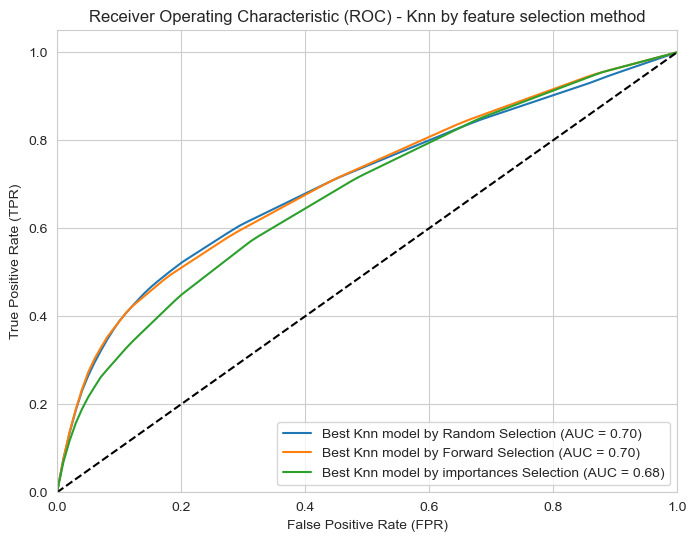

In [199]:
RS_fpr,RS_tpr,RS_roc_auc=get_fpr_tpr_auc(Knn_feature_selection_cmpr, 0)
FS_fpr,FS_tpr,FS_roc_auc=get_fpr_tpr_auc(Knn_feature_selection_cmpr, 1)
IS_fpr,IS_tpr,IS_roc_auc=get_fpr_tpr_auc(Knn_feature_selection_cmpr, 2)

# Plotting ROC curves
plt.figure(figsize=(8, 6))
plt.plot(RS_fpr,RS_tpr, label='Best Knn model by Random Selection (AUC = %0.2f)' % RS_roc_auc)
plt.plot(FS_fpr,FS_tpr, label='Best Knn model by Forward Selection (AUC = %0.2f)' % FS_roc_auc)
plt.plot(IS_fpr,IS_tpr, label='Best Knn model by importances Selection (AUC = %0.2f)' % IS_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) - Knn by feature selection method')
plt.legend(loc='lower right')
plt.show()

For a period of 4 months, a **Forward Selection** was chosen since it gives the highest accuracy, auc and f1.

In [200]:
available_methods = ['Random Selection', 'Forward Selection', 'Selection by Importances']
print("Available feature selection methods:")
for i, method in enumerate(available_methods, 1):
    print(f"{i}. {method}")

selected_method = int(input("Enter the number corresponding to the selected feature selection method you want to use based on the analysis: "))

if selected_method==1:
    Knn_4mns_best_education_method=Knn_RS_best_education_method_4mns
    Knn_4mns_best_marriage_method=Knn_RS_best_marriage_method_4mns
    Knn_4mns_best_k=Knn_RS_best_k_4mns
    Knn_4mns_best_selected_features=Knn_RS_best_selected_features_4mns
    Knn_4mns_best_p=Knn_RS_best_p_4mns
    Knn_4mns_best_scaler=Knn_RS_best_scaler_4mns
    Knn_4mns_best_feature_selection_method='Random Selection'
    dic_results=knn_model_evaluation(Knn_RS_best_education_method_4mns, Knn_RS_best_marriage_method_4mns, Knn_RS_best_k_4mns, Knn_RS_best_selected_features_4mns, Knn_RS_best_p_4mns, Knn_RS_best_scaler_4mns,4,'Random Selection',update_models_by_period_summery,cmpr_dic=Knn_period_cmpr)
    
elif selected_method==2:
    Knn_4mns_best_education_method=Knn_FS_best_education_method_4mns
    Knn_4mns_best_marriage_method=Knn_FS_best_marriage_method_4mns
    Knn_4mns_best_k=Knn_FS_best_k_4mns
    Knn_4mns_best_selected_features=Knn_FS_best_selected_features_4mns
    Knn_4mns_best_p=Knn_FS_best_p_4mns
    Knn_4mns_best_scaler=Knn_FS_best_scaler_4mns
    Knn_4mns_best_feature_selection_method='Forward Selection'
    dic_results=knn_model_evaluation(Knn_FS_best_education_method_4mns, Knn_FS_best_marriage_method_4mns, Knn_FS_best_k_4mns, Knn_FS_best_selected_features_4mns, Knn_FS_best_p_4mns, Knn_FS_best_scaler_4mns,4,'forward Selection',update_models_by_period_summery,cmpr_dic=Knn_period_cmpr)

elif selected_method==3:
    Knn_4mns_best_education_method=Knn_IS_best_education_method_4mns
    Knn_4mns_best_marriage_method=Knn_IS_best_marriage_method_4mns
    Knn_4mns_best_k=Knn_IS_best_k_4mns
    Knn_4mns_best_selected_features=Knn_IS_best_selected_features_4mns
    Knn_4mns_best_p=Knn_IS_best_p_4mns
    Knn_4mns_best_scaler=Knn_IS_best_scaler_4mns
    Knn_4mns_best_feature_selection_method='Selection by Importances'
    dic_results=knn_model_evaluation(Knn_IS_best_education_method_4mns, Knn_IS_best_marriage_method_4mns, Knn_IS_best_k_4mns, Knn_IS_best_selected_features_4mns, Knn_IS_best_p_4mns, Knn_IS_best_scaler_4mns, 4,'selection by importances',update_models_by_period_summery,cmpr_dic=Knn_period_cmpr)

Model_Performance_Metrics(dic_results,'Best Knn Model for a period of 4 months')

Available feature selection methods:
1. Random Selection
2. Forward Selection
3. Selection by Importances
Enter the number corresponding to the selected feature selection method you want to use based on the analysis: 2
Performance Metrics for Best Knn Model for a period of 4 months

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.771258 |
+-----------+----------+
| recall    | 0.797157 |
+-----------+----------+
| precision | 0.770415 |
+-----------+----------+
| accuracy  | 0.797157 |
+-----------+----------+
Accuracy: 0.7971574085040862 - The model outperforms the prior model


## A Period of 2 Months-
### <font color='darkblue'>Investigating Model Performance by feature Selection Methods for a Period of 6 Months:</font>
### Feature Selection Method 1: Random Selection-

In [202]:
knn_random_selection_dic={'education_method': [],
                          'marriage_method': [],
                          'best_k': [],
                          'best_selected_features': [],
                          'best_p': [],
                          'best_scaler':[],
                          'F1_score': []}

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X1_2mns,y1_2mns,random_selection)
update_knn_summery(knn_random_selection_dic,1,1,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X2_2mns,y2_2mns,random_selection)
update_knn_summery(knn_random_selection_dic,1,2,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X3_2mns,y3_2mns,random_selection)
update_knn_summery(knn_random_selection_dic,2,1,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X4_2mns,y4_2mns,random_selection)
update_knn_summery(knn_random_selection_dic,2,2,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X5_2mns,y5_2mns,random_selection)
update_knn_summery(knn_random_selection_dic,3,3,best_k,best_features,best_p,best_scaler,best_F1_score)

In [203]:
print_model_summery(knn_random_selection_dic)

In [204]:
Knn_RS_best_education_method_2mns,Knn_RS_best_marriage_method_2mns,Knn_RS_best_k_2mns,Knn_RS_best_selected_features_2mns,Knn_RS_best_p_2mns,Knn_RS_best_scaler_2mns=Knn_Best_Parameters(knn_random_selection_dic)

#### Best Knn Model by random selection: Scores

In [205]:
Knn_feature_selection_cmpr={}
Knn_feature_selection_cmpr=create_feature_selection_method_summery(Knn_feature_selection_cmpr)

In [206]:
dic_results=knn_model_evaluation(Knn_RS_best_education_method_2mns,Knn_RS_best_marriage_method_2mns,Knn_RS_best_k_2mns,Knn_RS_best_selected_features_2mns,Knn_RS_best_p_2mns,Knn_RS_best_scaler_2mns,2,'Random Selection',update_models_by_feature_selection_method_summery,cmpr_dic=Knn_feature_selection_cmpr)

In [207]:
Model_Performance_Metrics(dic_results,'Knn last 2 months with Random Selection')

Performance Metrics for Knn last 2 months with Random Selection

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.768182 |
+-----------+----------+
| recall    | 0.796759 |
+-----------+----------+
| precision | 0.769025 |
+-----------+----------+
| accuracy  | 0.796759 |
+-----------+----------+
Accuracy: 0.7967590925459127 - The model outperforms the prior model


### Feature Selection Method 2: Forward Selection

In [229]:
knn_random_selection_dic={'education_method': [],
                          'marriage_method': [],
                          'best_k': [],
                          'best_selected_features': [],
                          'best_p': [],
                          'best_scaler':[],
                          'F1_score': []}

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X1_2mns,y1_2mns,forward_selection)
update_knn_summery(knn_random_selection_dic,1,1,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X2_2mns,y2_2mns,forward_selection)
update_knn_summery(knn_random_selection_dic,1,2,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X1_2mns,y1_2mns,forward_selection)
update_knn_summery(knn_random_selection_dic,1,1,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X2_2mns,y2_2mns,forward_selection)
update_knn_summery(knn_random_selection_dic,1,2,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X2_2mns,y2_2mns,forward_selection)
update_knn_summery(knn_random_selection_dic,1,2,best_k,best_features,best_p,best_scaler,best_F1_score)

In [230]:
print_model_summery(knn_random_selection_dic)

In [231]:
Knn_FS_best_education_method_2mns,Knn_FS_best_marriage_method_2mns,Knn_FS_best_k_2mns,Knn_FS_best_selected_features_2mns,Knn_FS_best_p_2mns,Knn_FS_best_scaler_2mns=Knn_Best_Parameters(knn_random_selection_dic)

#### Best Knn Model by forward selection: Scores

In [232]:
dic_results=knn_model_evaluation(Knn_FS_best_education_method_2mns,Knn_FS_best_marriage_method_2mns,Knn_FS_best_k_2mns,Knn_FS_best_selected_features_2mns,Knn_FS_best_p_2mns,Knn_FS_best_scaler_2mns,2,'forward Selection',update_models_by_feature_selection_method_summery,cmpr_dic=Knn_feature_selection_cmpr)

In [233]:
Model_Performance_Metrics(dic_results,'Knn last 2 months with Forward Selection')

Performance Metrics for Knn last 2 months with Forward Selection

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.770457 |
+-----------+----------+
| recall    | 0.79891  |
+-----------+----------+
| precision | 0.771738 |
+-----------+----------+
| accuracy  | 0.79891  |
+-----------+----------+
Accuracy: 0.7989103399265665 - The model outperforms the prior model


### Feature Selection Method 3: Selection by Importances

In [241]:
knn_random_selection_dic={'education_method': [],
                          'marriage_method': [],
                          'best_k': [],
                          'best_selected_features': [],
                          'best_p': [],
                          'best_scaler':[],
                          'F1_score': []}

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X1_2mns,y1_2mns,selection_by_importances)
update_knn_summery(knn_random_selection_dic,1,1,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X2_2mns,y2_2mns,selection_by_importances)
update_knn_summery(knn_random_selection_dic,1,2,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X3_2mns,y3_2mns,selection_by_importances)
update_knn_summery(knn_random_selection_dic,2,1,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X4_2mns,y4_2mns,selection_by_importances)
update_knn_summery(knn_random_selection_dic,2,2,best_k,best_features,best_p,best_scaler,best_F1_score)

best_k, best_features, best_p,best_scaler,best_F1_score=optimize_knn_model(X5_2mns,y5_2mns,selection_by_importances)
update_knn_summery(knn_random_selection_dic,3,3,best_k,best_features,best_p,best_scaler,best_F1_score)

In [242]:
print_model_summery(knn_random_selection_dic)

In [243]:
Knn_IS_best_education_method_2mns,Knn_IS_best_marriage_method_2mns,Knn_IS_best_k_2mns,Knn_IS_best_selected_features_2mns,Knn_IS_best_p_2mns,Knn_IS_best_scaler_2mns=Knn_Best_Parameters(knn_random_selection_dic)

#### Best Knn Model with selection by importances: Scores

In [244]:
dic_results=knn_model_evaluation(Knn_IS_best_education_method_2mns,Knn_IS_best_marriage_method_2mns,Knn_IS_best_k_2mns,Knn_IS_best_selected_features_2mns,Knn_IS_best_p_2mns,Knn_IS_best_scaler_2mns,4,'selection by importances',update_models_by_feature_selection_method_summery,cmpr_dic=Knn_feature_selection_cmpr)

In [245]:
Model_Performance_Metrics(dic_results,'Knn with last 2 months Selection by Importances')

Performance Metrics for Knn with last 2 months Selection by Importances

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.765384 |
+-----------+----------+
| recall    | 0.795381 |
+-----------+----------+
| precision | 0.767797 |
+-----------+----------+
| accuracy  | 0.795381 |
+-----------+----------+
Accuracy: 0.7953807888191401 - The model outperforms the prior model


### Comparison of feature selection methods for the best knn models

In [251]:
print_cmpr_dic(Knn_feature_selection_cmpr)

Model_type Features_Selection_method  F1_score    recall  precision  \
0        KNN          Random Selection  0.768182  0.796759   0.769025   
1        KNN         forward Selection  0.770457  0.798910   0.771738   
2        KNN  selection by importances  0.765384  0.795381   0.767797   

   accuracy   roc_auc  
0  0.796759  0.705574  
1  0.798910  0.702136  
2  0.795381  0.709218

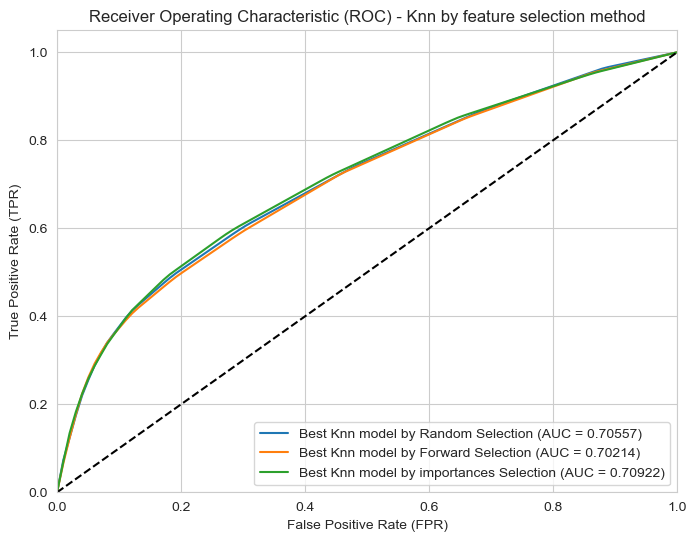

In [253]:
RS_fpr,RS_tpr,RS_roc_auc=get_fpr_tpr_auc(Knn_feature_selection_cmpr, 0)
FS_fpr,FS_tpr,FS_roc_auc=get_fpr_tpr_auc(Knn_feature_selection_cmpr, 1)
IS_fpr,IS_tpr,IS_roc_auc=get_fpr_tpr_auc(Knn_feature_selection_cmpr, 2)

# Plotting ROC curves
plt.figure(figsize=(8, 6))
plt.plot(RS_fpr,RS_tpr, label='Best Knn model by Random Selection (AUC = %0.5f)' % RS_roc_auc)
plt.plot(FS_fpr,FS_tpr, label='Best Knn model by Forward Selection (AUC = %0.5f)' % FS_roc_auc)
plt.plot(IS_fpr,IS_tpr, label='Best Knn model by importances Selection (AUC = %0.5f)' % IS_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) - Knn by feature selection method')
plt.legend(loc='lower right')
plt.show()

For a period of 2 months, **Selection by Importances** was chosen since it gives the highest accuracy, auc and f1.

In [254]:
available_methods = ['Random Selection', 'Forward Selection', 'Selection by Importances']
print("Available feature selection methods:")
for i, method in enumerate(available_methods, 1):
    print(f"{i}. {method}")

selected_method = int(input("Enter the number corresponding to the selected feature selection method you want to use based on the analysis: "))

if selected_method==1:
    Knn_2mns_best_education_method=Knn_RS_best_education_method_2mns
    Knn_2mns_best_marriage_method=Knn_RS_best_marriage_method_2mns
    Knn_2mns_best_k=Knn_RS_best_k_2mns
    Knn_2mns_best_selected_features=Knn_RS_best_selected_features_2mns
    Knn_2mns_best_feature_selection_method='Random Selection'
    Knn_2mns_best_p=Knn_RS_best_p_2mns
    Knn_2mns_best_scaler=Knn_RS_best_scaler_2mns
    dic_results=knn_model_evaluation(Knn_2mns_best_education_method, Knn_2mns_best_marriage_method, Knn_2mns_best_k, Knn_2mns_best_selected_features, Knn_2mns_best_p, Knn_2mns_best_scaler,2,Knn_2mns_best_feature_selection_method,update_models_by_period_summery,cmpr_dic=Knn_period_cmpr)
    
elif selected_method==2:
    Knn_2mns_best_education_method=Knn_FS_best_education_method_2mns
    Knn_2mns_best_marriage_method=Knn_FS_best_marriage_method_2mns
    Knn_2mns_best_k=Knn_FS_best_k_2mns
    Knn_2mns_best_selected_features=Knn_FS_best_selected_features_2mns
    Knn_2mns_best_p=Knn_FS_best_p_2mns
    Knn_2mns_best_feature_selection_method='Forward Selection'
    Knn_2mns_best_scaler=Knn_FS_best_scaler_2mns
    dic_results=knn_model_evaluation(Knn_2mns_best_education_method, Knn_2mns_best_marriage_method, Knn_2mns_best_k, Knn_2mns_best_selected_features, Knn_2mns_best_p, Knn_2mns_best_scaler,2,Knn_2mns_best_feature_selection_method,update_models_by_period_summery,cmpr_dic=Knn_period_cmpr)
    
elif selected_method==3:
    Knn_2mns_best_education_method=Knn_IS_best_education_method_2mns
    Knn_2mns_best_marriage_method=Knn_IS_best_marriage_method_2mns
    Knn_2mns_best_k=Knn_IS_best_k_2mns
    Knn_2mns_best_selected_features=Knn_IS_best_selected_features_2mns
    Knn_2mns_best_p=Knn_IS_best_p_2mns
    Knn_2mns_best_scaler=Knn_IS_best_scaler_2mns
    Knn_2mns_best_feature_selection_method='Selection by Importances'
    dic_results=knn_model_evaluation(Knn_2mns_best_education_method, Knn_2mns_best_marriage_method, Knn_2mns_best_k, Knn_2mns_best_selected_features, Knn_2mns_best_p, Knn_2mns_best_scaler,2,Knn_2mns_best_feature_selection_method,update_models_by_period_summery,cmpr_dic=Knn_period_cmpr)
    
Model_Performance_Metrics(dic_results,'Best Knn Model for a period of 2 months')

Available feature selection methods:
1. Random Selection
2. Forward Selection
3. Selection by Importances
Enter the number corresponding to the selected feature selection method you want to use based on the analysis: 3
Performance Metrics for Best Knn Model for a period of 2 months

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.760574 |
+-----------+----------+
| recall    | 0.793628 |
+-----------+----------+
| precision | 0.765242 |
+-----------+----------+
| accuracy  | 0.793628 |
+-----------+----------+
Accuracy: 0.79362785739666 - The model outperforms the prior model


## Comparing the Best Models For Each Time Period

In [255]:
print_cmpr_dic(Knn_period_cmpr)

Model_type  Period  F1_score    recall  precision  accuracy   roc_auc
0        KNN       6  0.771204  0.797963   0.771756  0.797963  0.717766
1        KNN       4  0.771258  0.797157   0.770415  0.797157  0.704626
2        KNN       2  0.760574  0.793628   0.765242  0.793628  0.701356

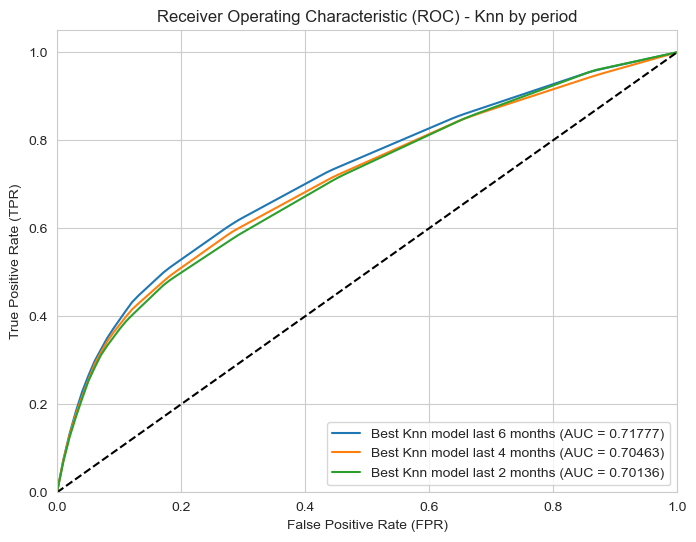

In [257]:
fpr_6mns,tpr_6mns,roc_auc_6mns=get_fpr_tpr_auc(Knn_period_cmpr, 0)
fpr_4mns,tpr_4mns,roc_auc_4mns=get_fpr_tpr_auc(Knn_period_cmpr, 1)
fpr_2mns,tpr_2mns,roc_auc_2mns=get_fpr_tpr_auc(Knn_period_cmpr, 2)

# Plotting ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_6mns,tpr_6mns, label='Best Knn model last 6 months (AUC = %0.5f)' % roc_auc_6mns)
plt.plot(fpr_4mns,tpr_4mns, label='Best Knn model last 4 months (AUC = %0.5f)' % roc_auc_4mns)
plt.plot(fpr_2mns,tpr_2mns, label='Best Knn model last 2 months (AUC = %0.5f)' % roc_auc_2mns)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) - Knn by period')
plt.legend(loc='lower right')
plt.show()

For the knn model we chose the **full data set (last 6 months)** since it gives the highest accuracy, auc and f1.

## Select the Best Knn Model:

In [259]:
available_methods = ['6 Months', '4 Months', '2 Months']
print("Available period frame:")
for i, method in enumerate(available_methods, 1):
    print(f"{i}. {method}")

selected_method = int(input("Enter the number corresponding to the period frame you want to use based on the analysis: "))

if selected_method==1:
    Knn_best_education_method=knn_6mns_best_education_method
    Knn_best_marriage_method=Knn_6mns_best_marriage_method
    Knn_best_k=Knn_6mns_best_k
    Knn_best_selected_features=Knn_6mns_best_selected_features
    Knn_best_p=Knn_6mns_best_p
    Knn_best_scaler=Knn_6mns_best_scaler
    knn_best_feature_selection_method=Knn_6mns_best_feature_selection_method
    dic_results=knn_model_evaluation(Knn_best_education_method, Knn_best_marriage_method, Knn_best_k, Knn_best_selected_features, Knn_best_p, Knn_best_scaler,6,knn_best_feature_selection_method,update_models_general_summery)
    
if selected_method==2:
    Knn_best_education_method=knn_4mns_best_education_method
    Knn_best_marriage_method=Knn_4mns_best_marriage_method
    Knn_best_k=Knn_4mns_best_k
    Knn_best_selected_features=Knn_4mns_best_selected_features
    Knn_best_p=Knn_4mns_best_p
    Knn_best_scaler=Knn_4mns_best_scaler
    knn_best_feature_selection_method=Knn_4mns_best_feature_selection_method
    dic_results=knn_model_evaluation(Knn_best_education_method, Knn_best_marriage_method, Knn_best_k, Knn_best_selected_features, Knn_best_p, Knn_best_scaler,4,knn_best_feature_selection_method,update_models_general_summery)
    
if selected_method==3:
    Knn_best_education_method=knn_2mns_best_education_method
    Knn_best_marriage_method=Knn_2mns_best_marriage_method
    Knn_best_k=Knn_2mns_best_k
    Knn_best_selected_features=Knn_2mns_best_selected_features
    Knn_best_p=Knn_2mns_best_p
    Knn_best_scaler=Knn_2mns_best_scaler
    knn_best_feature_selection_method=Knn_2mns_best_feature_selection_method
    dic_results=knn_model_evaluation(Knn_best_education_method, Knn_best_marriage_method, Knn_best_k, Knn_best_selected_features, Knn_best_p, Knn_best_scaler,2,knn_best_feature_selection_method,update_models_general_summery)

Model_Performance_Metrics(dic_results,'Best Knn Model')


Available period frame:
1. 6 Months
2. 4 Months
3. 2 Months
Enter the number corresponding to the period frame you want to use based on the analysis: 1
Performance Metrics for Best Knn Model

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.772789 |
+-----------+----------+
| recall    | 0.799574 |
+-----------+----------+
| precision | 0.774666 |
+-----------+----------+
| accuracy  | 0.799574 |
+-----------+----------+
Accuracy: 0.799573611275613 - The model outperforms the prior model


# Logistic Regression-
## <font color='navy'>Investigating Model Performance by Period:</font>
## A Period of 6 Months-
### <font color='darkblue'>Investigating Model Performance by feature Selection Methods for a Period of 6 Months:</font>
### Feature Selection Method 1: Random Selection-

In [ ]:
LG_random_selection_dic={'education_method': [],
                          'marriage_method': [],
                          'selected_features': [],
                          'n_iter': [],
                          'eps': [],
                          'penalty': [],
                          'threshold': [],
                          'imbalance':[],
                          'scaler':[],
                          'F1_score': []}

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X1,y1,random_selection)
update_models_summery_LG(LG_random_selection_dic,1,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X2,y2,random_selection)
update_models_summery_LG(LG_random_selection_dic,1,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X3,y3,random_selection)
update_models_summery_LG(LG_random_selection_dic,2,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X4,y4,random_selection)
update_models_summery_LG(LG_random_selection_dic,2,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X5,y5,random_selection)
update_models_summery_LG(LG_random_selection_dic,3,3,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X1,y1,random_selection,imbalance=1)
update_models_summery_LG(LG_random_selection_dic,1,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X2,y2,random_selection,imbalance=1)
update_models_summery_LG(LG_random_selection_dic,1,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X3,y3,random_selection,imbalance=1)
update_models_summery_LG(LG_random_selection_dic,2,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X4,y4,random_selection,imbalance=1)
update_models_summery_LG(LG_random_selection_dic,2,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X5,y5,random_selection,imbalance=1)
update_models_summery_LG(LG_random_selection_dic,3,3,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

In [451]:
print_model_summery(LG_random_selection_dic)

In [452]:
best_education_method_RS,best_marriage_method_RS,best_selected_features_RS,best_n_iter_RS,best_eps_RS,best_penalty_RS,best_threshold_RS,best_imbalance_RS,best_scaler_RS=LG_Best_Parameters(LG_random_selection_dic)

#### Best LG Model by random selection: Scores

In [459]:
LG_feature_selection_cmpr={}
LG_feature_selection_cmpr=create_feature_selection_method_summery(LG_feature_selection_cmpr)
dic_results=LG_model_evaluation(best_education_method_RS,best_marriage_method_RS,best_selected_features_RS,best_n_iter_RS,best_eps_RS,best_penalty_RS,best_threshold_RS,best_imbalance_RS,best_scaler_RS,6,'Random Selection',update_models_by_feature_selection_method_summery,cmpr_dic=LG_feature_selection_cmpr)

In [464]:
Model_Performance_Metrics(dic_results,'Logistic Regression 6 months with Random Selection')

Performance Metrics for Logistic Regression 6 months with Random Selection

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.787868 |
+-----------+----------+
| recall    | 0.80623  |
+-----------+----------+
| precision | 0.785489 |
+-----------+----------+
| accuracy  | 0.80623  |
+-----------+----------+
Accuracy: 0.8062300130285444 - The model outperforms the prior model


### Feature Selection Method 2: Forward Selection

In [482]:
LG_forward_selection_dic={'education_method': [],
                          'marriage_method': [],
                          'selected_features': [],
                          'n_iter': [],
                          'eps': [],
                          'penalty': [],
                          'threshold': [],
                          'imbalance':[],
                          'scaler':[],
                          'F1_score': []}

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X1,y1,forward_selection)
update_models_summery_LG(LG_forward_selection_dic,1,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X2,y2,forward_selection)
update_models_summery_LG(LG_forward_selection_dic,1,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X3,y3,forward_selection)
update_models_summery_LG(LG_forward_selection_dic,2,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X4,y4,forward_selection)
update_models_summery_LG(LG_forward_selection_dic,2,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X5,y5,forward_selection)
update_models_summery_LG(LG_forward_selection_dic,3,3,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X1,y1,forward_selection,imbalance=1)
update_models_summery_LG(LG_forward_selection_dic,1,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X2,y2,forward_selection,imbalance=1)
update_models_summery_LG(LG_forward_selection_dic,1,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X3,y3,forward_selection,imbalance=1)
update_models_summery_LG(LG_forward_selection_dic,2,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X4,y4,forward_selection,imbalance=1)
update_models_summery_LG(LG_forward_selection_dic,2,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X5,y5,forward_selection,imbalance=1)
update_models_summery_LG(LG_forward_selection_dic,3,3,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

In [483]:
print_model_summery(LG_forward_selection_dic)

In [484]:
best_education_method_FS,best_marriage_method_FS,best_selected_features_FS,best_n_iter_FS,best_eps_FS,best_penalty_FS,best_threshold_FS,best_imbalance_FS,best_scaler_FS=LG_Best_Parameters(LG_forward_selection_dic)

#### Best Logistic Regression Model by forward selection: Scores

In [485]:
dic_results=LG_model_evaluation(best_education_method_FS,best_marriage_method_FS,best_selected_features_FS,best_n_iter_FS,best_eps_FS,best_penalty_FS,best_threshold_FS,best_imbalance_FS,best_scaler_FS,6,'Forward Selection',update_models_by_feature_selection_method_summery,cmpr_dic=LG_feature_selection_cmpr)

In [486]:
Model_Performance_Metrics(dic_results,'Logistic Regresssion last 6 months with Forward Selection')

Performance Metrics for Logistic Regresssion last 6 months with Forward Selection

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.781495 |
+-----------+----------+
| recall    | 0.796759 |
+-----------+----------+
| precision | 0.777047 |
+-----------+----------+
| accuracy  | 0.796759 |
+-----------+----------+
Accuracy: 0.7967590925459127 - The model outperforms the prior model


### Feature Selection Method 3: selection by importances

In [499]:
LG_importances_selection_dic={'education_method': [],
                          'marriage_method': [],
                          'selected_features': [],
                          'n_iter': [],
                          'eps': [],
                          'penalty': [],
                          'threshold': [],
                          'imbalance':[],
                          'scaler':[],
                          'F1_score': []}

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X1,y1,selection_by_importances)
update_models_summery_LG(LG_importances_selection_dic,1,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X2,y2,selection_by_importances)
update_models_summery_LG(LG_importances_selection_dic,1,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X3,y3,selection_by_importances)
update_models_summery_LG(LG_importances_selection_dic,2,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X4,y4,selection_by_importances)
update_models_summery_LG(LG_importances_selection_dic,2,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X5,y5,selection_by_importances)
update_models_summery_LG(LG_importances_selection_dic,3,3,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X1,y1,selection_by_importances,imbalance=1)
update_models_summery_LG(LG_importances_selection_dic,1,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X2,y2,selection_by_importances,imbalance=1)
update_models_summery_LG(LG_importances_selection_dic,1,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X3,y3,selection_by_importances,imbalance=1)
update_models_summery_LG(LG_importances_selection_dic,2,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X4,y4,selection_by_importances,imbalance=1)
update_models_summery_LG(LG_importances_selection_dic,2,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X5,y5,selection_by_importances,imbalance=1)
update_models_summery_LG(LG_importances_selection_dic,3,3,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

In [500]:
print_model_summery(LG_importances_selection_dic)

In [501]:
best_education_method_IS,best_marriage_method_IS,best_selected_features_IS,best_n_iter_IS,best_eps_IS,best_penalty_IS,best_threshold_IS,best_imbalance_IS,best_scaler_IS=LG_Best_Parameters(LG_importances_selection_dic)

#### Best Logistic Regression Model with selection by importances: Scores

In [507]:
dic_results=LG_model_evaluation(best_education_method_IS,best_marriage_method_IS,best_selected_features_IS,best_n_iter_IS,best_eps_IS,best_penalty_IS,best_threshold_IS,best_imbalance_IS,best_scaler_IS,6,'selection by importances',update_models_by_feature_selection_method_summery,cmpr_dic=LG_feature_selection_cmpr)

In [508]:
Model_Performance_Metrics(dic_results,'Logistic Regresssion last 6 months with selection by importances')

Performance Metrics for Logistic Regresssion last 6 months with selection by importances

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.77116  |
+-----------+----------+
| recall    | 0.800971 |
+-----------+----------+
| precision | 0.776181 |
+-----------+----------+
| accuracy  | 0.800971 |
+-----------+----------+
Accuracy: 0.8009712187611038 - The model outperforms the prior model


### Comparison of feature selection methods for the best logistic regression models

In [515]:
print_cmpr_dic(LG_feature_selection_cmpr)

Model_type Features_Selection_method  F1_score    recall  precision  \
0         LG          Random Selection  0.787868  0.806230   0.785489   
1         LG         Forward Selection  0.781495  0.796759   0.777047   
2         LG  selection by importances  0.774954  0.802677   0.778467   

   accuracy   roc_auc  
0  0.806230  0.742286  
1  0.796759  0.737232  
2  0.802677  0.717371

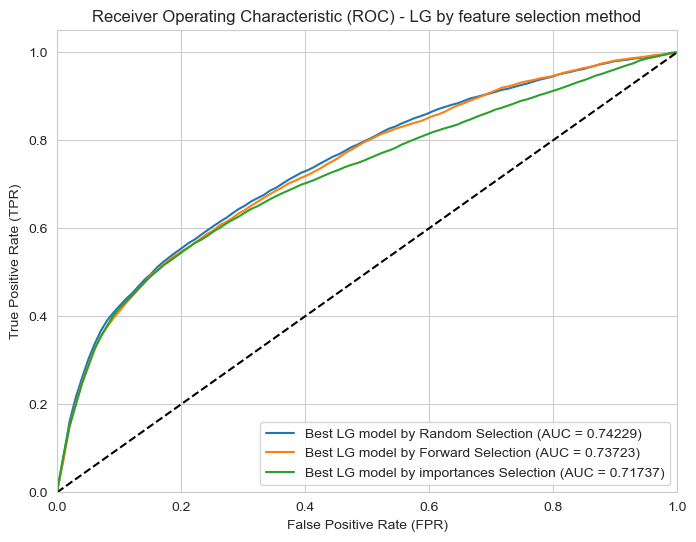

In [516]:
RS_fpr,RS_tpr,RS_roc_auc=get_fpr_tpr_auc(LG_feature_selection_cmpr, 0)
FS_fpr,FS_tpr,FS_roc_auc=get_fpr_tpr_auc(LG_feature_selection_cmpr, 1)
IS_fpr,IS_tpr,IS_roc_auc=get_fpr_tpr_auc(LG_feature_selection_cmpr, 2)

# Plotting ROC curves
plt.figure(figsize=(8, 6))
plt.plot(RS_fpr,RS_tpr, label='Best LG model by Random Selection (AUC = %0.5f)' % RS_roc_auc)
plt.plot(FS_fpr,FS_tpr, label='Best LG model by Forward Selection (AUC = %0.5f)' % FS_roc_auc)
plt.plot(IS_fpr,IS_tpr, label='Best LG model by importances Selection (AUC = %0.5f)' % IS_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) - LG by feature selection method')
plt.legend(loc='lower right')
plt.show()

For a period of 6 months, **Selection by Random Selection** was chosen since it gives the highest accuracy, auc and f1.

In [517]:
available_methods = ['Random Selection', 'Forward Selection', 'Selection by Importances']
print("Available feature selection methods:")
for i, method in enumerate(available_methods, 1):
    print(f"{i}. {method}")

selected_method = int(input("Enter the number corresponding to the selected feature selection method you want to use based on the analysis: "))

LG_period_cmpr={}
LG_period_cmpr=create_period_summery(LG_period_cmpr)

if selected_method==1:
    best_education_method_6mns=best_education_method_RS
    best_marriage_method_6mns=best_marriage_method_RS
    best_selected_features_6mns=best_selected_features_RS
    best_n_iter_6mns=best_n_iter_RS
    best_eps_6mns=best_eps_RS
    best_penalty_6mns=best_penalty_RS
    best_threshold_6mns=best_threshold_RS
    best_imbalance_6mns=best_imbalance_RS
    best_scaler_6mns=best_scaler_RS
    best_feature_selection_method_6mns='Forward Selection'
    
    dic_results=LG_model_evaluation(best_education_method_RS,best_marriage_method_RS,best_selected_features_RS,best_n_iter_RS,best_eps_RS,best_penalty_RS,best_threshold_RS,best_imbalance_RS,best_scaler_RS,6,'Random Selection',update_models_by_period_summery,cmpr_dic=LG_period_cmpr)    
    
if selected_method==2:
    best_education_method_6mns=best_education_method_FS
    best_marriage_method_6mns=best_marriage_method_FS
    best_selected_features_6mns=best_selected_features_FS
    best_n_iter_6mns=best_n_iter_FS
    best_eps_6mns=best_eps_FS
    best_penalty_6mns=best_penalty_FS
    best_threshold_6mns=best_threshold_FS
    best_imbalance_6mns=best_imbalance_FS
    best_scaler_6mns=best_scaler_FS
    best_feature_selection_method_6mns='Forward Selection'
    
    dic_results=LG_model_evaluation(best_education_method_FS,best_marriage_method_FS,best_selected_features_FS,best_n_iter_FS,best_eps_FS,best_penalty_FS,best_threshold_FS,best_imbalance_FS,best_scaler_FS,6,'Forward Selection',update_models_by_period_summery,cmpr_dic=LG_period_cmpr)

if selected_method==3:
    best_education_method_6mns=best_education_method_IS
    best_marriage_method_6mns=best_marriage_method_IS
    best_selected_features_6mns=best_selected_features_IS
    best_n_iter_6mns=best_n_iter_IS
    best_eps_6mns=best_eps_IS
    best_penalty_6mns=best_penalty_IS
    best_threshold_6mns=best_threshold_IS
    best_imbalance_6mns=best_imbalance_IS
    best_scaler_6mns=best_scaler_IS
    best_feature_selection_method_6mns='Selection by Importances'
    dic_results=LG_model_evaluation(best_education_method_IS,best_marriage_method_IS,best_selected_features_IS,best_n_iter_IS,best_eps_IS,best_penalty_IS,best_threshold_IS,best_imbalance_IS,best_scaler_IS,6,'Selection by Importances',update_models_by_period_summery,cmpr_dic=LG_period_cmpr)

    Model_Performance_Metrics(dic_results,'Best LG Model for a period of 6 months')

Available feature selection methods:
1. Random Selection
2. Forward Selection
3. Selection by Importances
Enter the number corresponding to the selected feature selection method you want to use based on the analysis: 1


## A Period of 4 Months-
### <font color='darkblue'>Investigating Model Performance by feature Selection Methods for a Period of 6 Months:</font>
### Feature Selection Method 1: Random Selection-

In [519]:
LG_random_selection_dic={'education_method': [],
                          'marriage_method': [],
                          'selected_features': [],
                          'n_iter': [],
                          'eps': [],
                          'penalty': [],
                          'threshold': [],
                          'imbalance':[],
                          'scaler':[],
                          'F1_score': []}

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X1_4mns,y1_4mns,random_selection)
update_models_summery_LG(LG_random_selection_dic,1,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X2_4mns,y2_4mns,random_selection)
update_models_summery_LG(LG_random_selection_dic,1,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X3_4mns,y3_4mns,random_selection)
update_models_summery_LG(LG_random_selection_dic,2,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X4_4mns,y4_4mns,random_selection)
update_models_summery_LG(LG_random_selection_dic,2,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X5_4mns,y5_4mns,random_selection)
update_models_summery_LG(LG_random_selection_dic,3,3,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X1_4mns,y1_4mns,random_selection,imbalance=1)
update_models_summery_LG(LG_random_selection_dic,1,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X2_4mns,y2_4mns,random_selection,imbalance=1)
update_models_summery_LG(LG_random_selection_dic,1,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X3_4mns,y3_4mns,random_selection,imbalance=1)
update_models_summery_LG(LG_random_selection_dic,2,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X4_4mns,y4_4mns,random_selection,imbalance=1)
update_models_summery_LG(LG_random_selection_dic,2,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X5_4mns,y5_4mns,random_selection,imbalance=1)
update_models_summery_LG(LG_random_selection_dic,3,3,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

In [520]:
print_model_summery(LG_random_selection_dic)

In [521]:
best_education_method_RS,best_marriage_method_RS,best_selected_features_RS,best_n_iter_RS,best_eps_RS,best_penalty_RS,best_threshold_RS,best_imbalance_RS,best_scaler_RS=LG_Best_Parameters(LG_random_selection_dic)

#### Best LG Model by random selection: Scores

In [522]:
LG_feature_selection_cmpr={}
LG_feature_selection_cmpr=create_feature_selection_method_summery(LG_feature_selection_cmpr)

In [523]:
dic_results=LG_model_evaluation(best_education_method_RS,best_marriage_method_RS,best_selected_features_RS,best_n_iter_RS,best_eps_RS,best_penalty_RS,best_threshold_RS,best_imbalance_RS,best_scaler_RS,4,'Random Selection',update_models_by_feature_selection_method_summery,cmpr_dic=LG_feature_selection_cmpr)

In [524]:
Model_Performance_Metrics(dic_results,'Logistic Regression 4 months with Random Selection')

Performance Metrics for Logistic Regression 4 months with Random Selection

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.783475 |
+-----------+----------+
| recall    | 0.79178  |
+-----------+----------+
| precision | 0.778481 |
+-----------+----------+
| accuracy  | 0.79178  |
+-----------+----------+
Accuracy: 0.7917801729243161 - The model outperforms the prior model


### Feature Selection Method 2: Forward Selection

In [525]:
LG_forward_selection_dic={'education_method': [],
                          'marriage_method': [],
                          'selected_features': [],
                          'n_iter': [],
                          'eps': [],
                          'penalty': [],
                          'threshold': [],
                          'imbalance':[],
                          'scaler':[],
                          'F1_score': []}

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X1_4mns,y1_4mns,forward_selection)
update_models_summery_LG(LG_forward_selection_dic,1,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X2_4mns,y2_4mns,forward_selection)
update_models_summery_LG(LG_forward_selection_dic,1,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X3_4mns,y3_4mns,forward_selection)
update_models_summery_LG(LG_forward_selection_dic,2,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X4_4mns,y4_4mns,forward_selection)
update_models_summery_LG(LG_forward_selection_dic,2,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X5_4mns,y5_4mns,forward_selection)
update_models_summery_LG(LG_forward_selection_dic,3,3,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X1_4mns,y1_4mns,forward_selection,imbalance=1)
update_models_summery_LG(LG_forward_selection_dic,1,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X2_4mns,y2_4mns,forward_selection,imbalance=1)
update_models_summery_LG(LG_forward_selection_dic,1,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X3_4mns,y3_4mns,forward_selection,imbalance=1)
update_models_summery_LG(LG_forward_selection_dic,2,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X4_4mns,y4_4mns,forward_selection,imbalance=1)
update_models_summery_LG(LG_forward_selection_dic,2,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X5_4mns,y5_4mns,forward_selection,imbalance=1)
update_models_summery_LG(LG_forward_selection_dic,3,3,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

In [526]:
print_model_summery(LG_forward_selection_dic)

In [527]:
best_education_method_FS,best_marriage_method_FS,best_selected_features_FS,best_n_iter_FS,best_eps_FS,best_penalty_FS,best_threshold_FS,best_imbalance_FS,best_scaler_FS=LG_Best_Parameters(LG_forward_selection_dic)

#### Best Logistic Regression Model by forward selection: Scores

In [528]:
dic_results=LG_model_evaluation(best_education_method_FS,best_marriage_method_FS,best_selected_features_FS,best_n_iter_FS,best_eps_FS,best_penalty_FS,best_threshold_FS,best_imbalance_FS,best_scaler_FS,4,'Forward Selection',update_models_by_feature_selection_method_summery,cmpr_dic=LG_feature_selection_cmpr)

In [529]:
Model_Performance_Metrics(dic_results,'Logistic Regresssion last 4 months with Forward Selection')

Performance Metrics for Logistic Regresssion last 4 months with Forward Selection

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.779643 |
+-----------+----------+
| recall    | 0.79981  |
+-----------+----------+
| precision | 0.777652 |
+-----------+----------+
| accuracy  | 0.79981  |
+-----------+----------+
Accuracy: 0.7998104939002724 - The model outperforms the prior model


### Feature Selection Method 3: selection by importances

In [530]:
LG_importances_selection_dic={'education_method': [],
                          'marriage_method': [],
                          'selected_features': [],
                          'n_iter': [],
                          'eps': [],
                          'penalty': [],
                          'threshold': [],
                          'imbalance':[],
                          'scaler':[],
                          'F1_score': []}

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X1_4mns,y1_4mns,selection_by_importances)
update_models_summery_LG(LG_importances_selection_dic,1,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X2_4mns,y2_4mns,selection_by_importances)
update_models_summery_LG(LG_importances_selection_dic,1,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X3_4mns,y3_4mns,selection_by_importances)
update_models_summery_LG(LG_importances_selection_dic,2,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X4_4mns,y4_4mns,selection_by_importances)
update_models_summery_LG(LG_importances_selection_dic,2,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X5_4mns,y5_4mns,selection_by_importances)
update_models_summery_LG(LG_importances_selection_dic,3,3,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X1_4mns,y1_4mns,selection_by_importances,imbalance=1)
update_models_summery_LG(LG_importances_selection_dic,1,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X2_4mns,y2_4mns,selection_by_importances,imbalance=1)
update_models_summery_LG(LG_importances_selection_dic,1,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X3_4mns,y3_4mns,selection_by_importances,imbalance=1)
update_models_summery_LG(LG_importances_selection_dic,2,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X4_4mns,y4_4mns,selection_by_importances,imbalance=1)
update_models_summery_LG(LG_importances_selection_dic,2,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X5_4mns,y5_4mns,selection_by_importances,imbalance=1)
update_models_summery_LG(LG_importances_selection_dic,3,3,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

In [531]:
print_model_summery(LG_importances_selection_dic)

In [532]:
best_education_method_IS,best_marriage_method_IS,best_selected_features_IS,best_n_iter_IS,best_eps_IS,best_penalty_IS,best_threshold_IS,best_imbalance_IS,best_scaler_IS=LG_Best_Parameters(LG_importances_selection_dic)

#### Best Logistic Regression Model with selection by importances: Scores

In [533]:
dic_results=LG_model_evaluation(best_education_method_IS,best_marriage_method_IS,best_selected_features_IS,best_n_iter_IS,best_eps_IS,best_penalty_IS,best_threshold_IS,best_imbalance_IS,best_scaler_IS,4,'selection by importances',update_models_by_feature_selection_method_summery,cmpr_dic=LG_feature_selection_cmpr)

In [534]:
Model_Performance_Metrics(dic_results,'Logistic Regresssion last 4 months with selection by importances')

Performance Metrics for Logistic Regresssion last 4 months with selection by importances

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.712004 |
+-----------+----------+
| recall    | 0.730072 |
+-----------+----------+
| precision | 0.700352 |
+-----------+----------+
| accuracy  | 0.730072 |
+-----------+----------+
Accuracy: 0.7300722492005212 - The model underperforms compared to the prior model


### Comparison of feature selection methods for the best logistic regression models

In [536]:
print_cmpr_dic(LG_feature_selection_cmpr)

Model_type Features_Selection_method  F1_score    recall  precision  \
0         LG          Random Selection  0.783475  0.791780   0.778481   
1         LG         Forward Selection  0.779643  0.799810   0.777652   
2         LG  selection by importances  0.712004  0.730072   0.700352   

   accuracy   roc_auc  
0  0.791780  0.738933  
1  0.799810  0.724179  
2  0.730072  0.629372

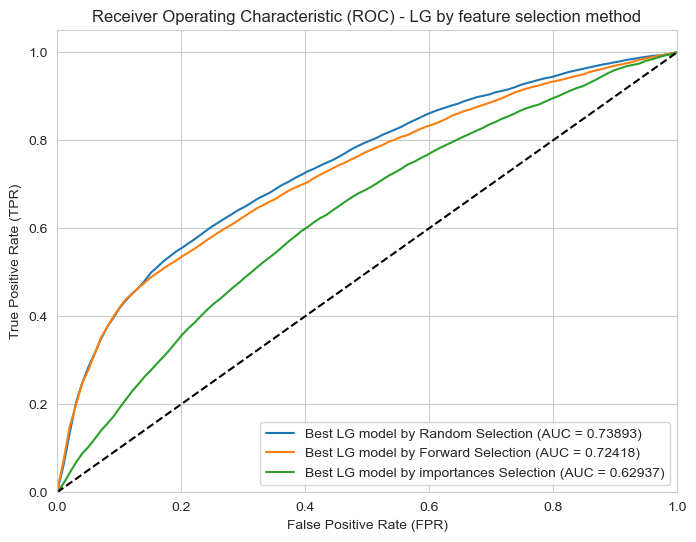

In [537]:
RS_fpr,RS_tpr,RS_roc_auc=get_fpr_tpr_auc(LG_feature_selection_cmpr, 0)
FS_fpr,FS_tpr,FS_roc_auc=get_fpr_tpr_auc(LG_feature_selection_cmpr, 1)
IS_fpr,IS_tpr,IS_roc_auc=get_fpr_tpr_auc(LG_feature_selection_cmpr, 2)

# Plotting ROC curves
plt.figure(figsize=(8, 6))
plt.plot(RS_fpr,RS_tpr, label='Best LG model by Random Selection (AUC = %0.5f)' % RS_roc_auc)
plt.plot(FS_fpr,FS_tpr, label='Best LG model by Forward Selection (AUC = %0.5f)' % FS_roc_auc)
plt.plot(IS_fpr,IS_tpr, label='Best LG model by importances Selection (AUC = %0.5f)' % IS_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) - LG by feature selection method')
plt.legend(loc='lower right')
plt.show()

For a period of 4 months, **Selection by Random Selection** was chosen since it gives the highest accuracy, auc and f1.

In [538]:
available_methods = ['Random Selection', 'Forward Selection', 'Selection by Importances']
print("Available feature selection methods:")
for i, method in enumerate(available_methods, 1):
    print(f"{i}. {method}")

selected_method = int(input("Enter the number corresponding to the selected feature selection method you want to use based on the analysis: "))

if selected_method==1:
    best_education_method_4mns=best_education_method_RS
    best_marriage_method_4mns=best_marriage_method_RS
    best_selected_features_4mns=best_selected_features_RS
    best_n_iter_4mns=best_n_iter_RS
    best_eps_4mns=best_eps_RS
    best_penalty_4mns=best_penalty_RS
    best_threshold_4mns=best_threshold_RS
    best_imbalance_4mns=best_imbalance_RS
    best_scaler_4mns=best_scaler_RS
    best_feature_selection_method_4mns='Forward Selection'
    
    dic_results=LG_model_evaluation(best_education_method_RS,best_marriage_method_RS,best_selected_features_RS,best_n_iter_RS,best_eps_RS,best_penalty_RS,best_threshold_RS,best_imbalance_RS,best_scaler_RS,4,'Random Selection',update_models_by_period_summery,cmpr_dic=LG_period_cmpr)    
    
if selected_method==2:
    best_education_method_4mns=best_education_method_FS
    best_marriage_method_4mns=best_marriage_method_FS
    best_selected_features_4mns=best_selected_features_FS
    best_n_iter_4mns=best_n_iter_FS
    best_eps_4mns=best_eps_FS
    best_penalty_4mns=best_penalty_FS
    best_threshold_4mns=best_threshold_FS
    best_imbalance_4mns=best_imbalance_FS
    best_scaler_4mns=best_scaler_FS
    best_feature_selection_method_4mns='Forward Selection'
    
    dic_results=LG_model_evaluation(best_education_method_FS,best_marriage_method_FS,best_selected_features_FS,best_n_iter_FS,best_eps_FS,best_penalty_FS,best_threshold_FS,best_imbalance_FS,best_scaler_FS,4,'Forward Selection',update_models_by_period_summery,cmpr_dic=LG_period_cmpr)

if selected_method==3:
    best_education_method_4mns=best_education_method_IS
    best_marriage_method_4mns=best_marriage_method_IS
    best_selected_features_4mns=best_selected_features_IS
    best_n_iter_4mns=best_n_iter_IS
    best_eps_4mns=best_eps_IS
    best_penalty_4mns=best_penalty_IS
    best_threshold_4mns=best_threshold_IS
    best_imbalance_4mns=best_imbalance_IS
    best_scaler_4mns=best_scaler_IS
    best_feature_selection_method_4mns='Selection by Importances'
    dic_results=LG_model_evaluation(best_education_method_IS,best_marriage_method_IS,best_selected_features_IS,best_n_iter_IS,best_eps_IS,best_penalty_IS,best_threshold_IS,best_imbalance_IS,best_scaler_IS,4,'Selection by Importances',update_models_by_period_summery,cmpr_dic=LG_period_cmpr)

    Model_Performance_Metrics(dic_results,'Best LG Model for a period of 4 months')

Available feature selection methods:
1. Random Selection
2. Forward Selection
3. Selection by Importances
Enter the number corresponding to the selected feature selection method you want to use based on the analysis: 1


## A Period of 2 Months-
### <font color='darkblue'>Investigating Model Performance by feature Selection Methods for a Period of 6 Months:</font>
### Feature Selection Method 1: Random Selection-

In [539]:
LG_random_selection_dic={'education_method': [],
                          'marriage_method': [],
                          'selected_features': [],
                          'n_iter': [],
                          'eps': [],
                          'penalty': [],
                          'threshold': [],
                          'imbalance':[],
                          'scaler':[],
                          'F1_score': []}

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X1_2mns,y1_2mns,random_selection)
update_models_summery_LG(LG_random_selection_dic,1,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X2_2mns,y2_2mns,random_selection)
update_models_summery_LG(LG_random_selection_dic,1,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X3_2mns,y3_2mns,random_selection)
update_models_summery_LG(LG_random_selection_dic,2,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X4_2mns,y4_2mns,random_selection)
update_models_summery_LG(LG_random_selection_dic,2,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X5_2mns,y5_2mns,random_selection)
update_models_summery_LG(LG_random_selection_dic,3,3,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X1_2mns,y1_2mns,random_selection,imbalance=1)
update_models_summery_LG(LG_random_selection_dic,1,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X2_2mns,y2_2mns,random_selection,imbalance=1)
update_models_summery_LG(LG_random_selection_dic,1,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X3_2mns,y3_2mns,random_selection,imbalance=1)
update_models_summery_LG(LG_random_selection_dic,2,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X4_2mns,y4_2mns,random_selection,imbalance=1)
update_models_summery_LG(LG_random_selection_dic,2,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X5_2mns,y5_2mns,random_selection,imbalance=1)
update_models_summery_LG(LG_random_selection_dic,3,3,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

In [540]:
print_model_summery(LG_random_selection_dic)

In [541]:
best_education_method_RS,best_marriage_method_RS,best_selected_features_RS,best_n_iter_RS,best_eps_RS,best_penalty_RS,best_threshold_RS,best_imbalance_RS,best_scaler_RS=LG_Best_Parameters(LG_random_selection_dic)

#### Best LG Model by random selection: Scores

In [542]:
LG_feature_selection_cmpr={}
LG_feature_selection_cmpr=create_feature_selection_method_summery(LG_feature_selection_cmpr)

In [543]:
dic_results=LG_model_evaluation(best_education_method_RS,best_marriage_method_RS,best_selected_features_RS,best_n_iter_RS,best_eps_RS,best_penalty_RS,best_threshold_RS,best_imbalance_RS,best_scaler_RS,2,'Random Selection',update_models_by_feature_selection_method_summery,cmpr_dic=LG_feature_selection_cmpr)

In [544]:
Model_Performance_Metrics(dic_results,'Logistic Regression 2 months with Random Selection')

Performance Metrics for Logistic Regression 2 months with Random Selection

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.78656  |
+-----------+----------+
| recall    | 0.802582 |
+-----------+----------+
| precision | 0.782681 |
+-----------+----------+
| accuracy  | 0.802582 |
+-----------+----------+
Accuracy: 0.8025820206087884 - The model outperforms the prior model


### Feature Selection Method 2: Forward Selection

In [545]:
LG_forward_selection_dic={'education_method': [],
                          'marriage_method': [],
                          'selected_features': [],
                          'n_iter': [],
                          'eps': [],
                          'penalty': [],
                          'threshold': [],
                          'imbalance':[],
                          'scaler':[],
                          'F1_score': []}

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X1_2mns,y1_2mns,forward_selection)
update_models_summery_LG(LG_forward_selection_dic,1,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X2_2mns,y2_2mns,forward_selection)
update_models_summery_LG(LG_forward_selection_dic,1,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X3_2mns,y3_2mns,forward_selection)
update_models_summery_LG(LG_forward_selection_dic,2,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X4_2mns,y4_2mns,forward_selection)
update_models_summery_LG(LG_forward_selection_dic,2,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X5_2mns,y5_2mns,forward_selection)
update_models_summery_LG(LG_forward_selection_dic,3,3,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X1_2mns,y1_2mns,forward_selection,imbalance=1)
update_models_summery_LG(LG_forward_selection_dic,1,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X2_2mns,y2_2mns,forward_selection,imbalance=1)
update_models_summery_LG(LG_forward_selection_dic,1,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X3_2mns,y3_2mns,forward_selection,imbalance=1)
update_models_summery_LG(LG_forward_selection_dic,2,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X4_2mns,y4_2mns,forward_selection,imbalance=1)
update_models_summery_LG(LG_forward_selection_dic,2,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X5_2mns,y5_2mns,forward_selection,imbalance=1)
update_models_summery_LG(LG_forward_selection_dic,3,3,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

In [546]:
print_model_summery(LG_forward_selection_dic)

In [547]:
best_education_method_FS,best_marriage_method_FS,best_selected_features_FS,best_n_iter_FS,best_eps_FS,best_penalty_FS,best_threshold_FS,best_imbalance_FS,best_scaler_FS=LG_Best_Parameters(LG_forward_selection_dic)

#### Best Logistic Regression Model by forward selection: Scores

In [548]:
dic_results=LG_model_evaluation(best_education_method_FS,best_marriage_method_FS,best_selected_features_FS,best_n_iter_FS,best_eps_FS,best_penalty_FS,best_threshold_FS,best_imbalance_FS,best_scaler_FS,2,'Forward Selection',update_models_by_feature_selection_method_summery,cmpr_dic=LG_feature_selection_cmpr)

In [549]:
Model_Performance_Metrics(dic_results,'Logistic Regresssion last 2 months with Forward Selection')

Performance Metrics for Logistic Regresssion last 2 months with Forward Selection

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.783573 |
+-----------+----------+
| recall    | 0.800782 |
+-----------+----------+
| precision | 0.780303 |
+-----------+----------+
| accuracy  | 0.800782 |
+-----------+----------+
Accuracy: 0.8007817126613762 - The model outperforms the prior model


### Feature Selection Method 3: selection by importances

In [550]:
LG_importances_selection_dic={'education_method': [],
                          'marriage_method': [],
                          'selected_features': [],
                          'n_iter': [],
                          'eps': [],
                          'penalty': [],
                          'threshold': [],
                          'imbalance':[],
                          'scaler':[],
                          'F1_score': []}

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X1_2mns,y1_2mns,selection_by_importances)
update_models_summery_LG(LG_importances_selection_dic,1,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X2_2mns,y2_2mns,selection_by_importances)
update_models_summery_LG(LG_importances_selection_dic,1,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X3_2mns,y3_2mns,selection_by_importances)
update_models_summery_LG(LG_importances_selection_dic,2,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X4_2mns,y4_2mns,selection_by_importances)
update_models_summery_LG(LG_importances_selection_dic,2,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X5_2mns,y5_2mns,selection_by_importances)
update_models_summery_LG(LG_importances_selection_dic,3,3,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'Regular',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X1_2mns,y1_2mns,selection_by_importances,imbalance=1)
update_models_summery_LG(LG_importances_selection_dic,1,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X2_2mns,y2_2mns,selection_by_importances,imbalance=1)
update_models_summery_LG(LG_importances_selection_dic,1,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X3_2mns,y3_2mns,selection_by_importances,imbalance=1)
update_models_summery_LG(LG_importances_selection_dic,2,1,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X4_2mns,y4_2mns,selection_by_importances,imbalance=1)
update_models_summery_LG(LG_importances_selection_dic,2,2,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,best_scaler,Best_f1_score=optimize_logistic_regression_model(X5_2mns,y5_2mns,selection_by_importances,imbalance=1)
update_models_summery_LG(LG_importances_selection_dic,3,3,selected_features_LG, best_n_iter_LG, best_eps_LG, best_penalty_LG, best_threshold_LG,'weighted',best_scaler,Best_f1_score)

In [551]:
print_model_summery(LG_importances_selection_dic)

In [552]:
best_education_method_IS,best_marriage_method_IS,best_selected_features_IS,best_n_iter_IS,best_eps_IS,best_penalty_IS,best_threshold_IS,best_imbalance_IS,best_scaler_IS=LG_Best_Parameters(LG_importances_selection_dic)

#### Best Logistic Regression Model with selection by importances: Scores

In [553]:
dic_results=LG_model_evaluation(best_education_method_IS,best_marriage_method_IS,best_selected_features_IS,best_n_iter_IS,best_eps_IS,best_penalty_IS,best_threshold_IS,best_imbalance_IS,best_scaler_IS,2,'selection by importances',update_models_by_feature_selection_method_summery,cmpr_dic=LG_feature_selection_cmpr)

In [554]:
Model_Performance_Metrics(dic_results,'Logistic Regresssion last 2 months with selection by importances')

Performance Metrics for Logistic Regresssion last 2 months with selection by importances

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.701936 |
+-----------+----------+
| recall    | 0.730712 |
+-----------+----------+
| precision | 0.686228 |
+-----------+----------+
| accuracy  | 0.730712 |
+-----------+----------+
Accuracy: 0.7307118322871018 - The model underperforms compared to the prior model


### Comparison of feature selection methods for the best logistic regression models

In [555]:
print_cmpr_dic(LG_feature_selection_cmpr)

Model_type Features_Selection_method  F1_score    recall  precision  \
0         LG          Random Selection  0.786560  0.802582   0.782681   
1         LG         Forward Selection  0.783573  0.800782   0.780303   
2         LG  selection by importances  0.701936  0.730712   0.686228   

   accuracy   roc_auc  
0  0.802582  0.727880  
1  0.800782  0.718512  
2  0.730712  0.620625

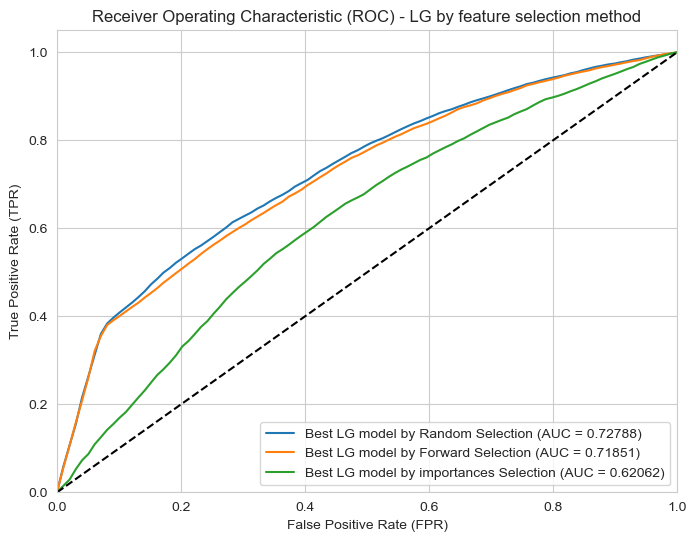

In [556]:
RS_fpr,RS_tpr,RS_roc_auc=get_fpr_tpr_auc(LG_feature_selection_cmpr, 0)
FS_fpr,FS_tpr,FS_roc_auc=get_fpr_tpr_auc(LG_feature_selection_cmpr, 1)
IS_fpr,IS_tpr,IS_roc_auc=get_fpr_tpr_auc(LG_feature_selection_cmpr, 2)

# Plotting ROC curves
plt.figure(figsize=(8, 6))
plt.plot(RS_fpr,RS_tpr, label='Best LG model by Random Selection (AUC = %0.5f)' % RS_roc_auc)
plt.plot(FS_fpr,FS_tpr, label='Best LG model by Forward Selection (AUC = %0.5f)' % FS_roc_auc)
plt.plot(IS_fpr,IS_tpr, label='Best LG model by importances Selection (AUC = %0.5f)' % IS_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) - LG by feature selection method')
plt.legend(loc='lower right')
plt.show()

For a period of 2 months, **Selection by Random Selection** was chosen since it gives the highest accuracy, auc and f1.

In [557]:
available_methods = ['Random Selection', 'Forward Selection', 'Selection by Importances']
print("Available feature selection methods:")
for i, method in enumerate(available_methods, 1):
    print(f"{i}. {method}")

selected_method = int(input("Enter the number corresponding to the selected feature selection method you want to use based on the analysis: "))

if selection==1:
    best_education_method_2mns=best_education_method_RS
    best_marriage_method_2mns=best_marriage_method_RS
    best_selected_features_2mns=best_selected_features_RS
    best_n_iter_2mns=best_n_iter_RS
    best_eps_2mns=best_eps_RS
    best_penalty_2mns=best_penalty_RS
    best_threshold_2mns=best_threshold_RS
    best_imbalance_2mns=best_imbalance_RS
    best_scaler_2mns=best_scaler_RS
    best_feature_selection_method_2mns='Forward Selection'
    dic_results=LG_model_evaluation(best_education_method_RS,best_marriage_method_RS,best_selected_features_RS,best_n_iter_RS,best_eps_RS,best_penalty_RS,best_threshold_RS,best_imbalance_RS,best_scaler_RS,2,'Random Selection',update_models_by_period_summery,cmpr_dic=LG_period_cmpr)    
    
if selection==2:
    best_education_method_2mns=best_education_method_FS
    best_marriage_method_2mns=best_marriage_method_FS
    best_selected_features_2mns=best_selected_features_FS
    best_n_iter_2mns=best_n_iter_FS
    best_eps_2mns=best_eps_FS
    best_penalty_2mns=best_penalty_FS
    best_threshold_2mns=best_threshold_FS
    best_imbalance_2mns=best_imbalance_FS
    best_scaler_2mns=best_scaler_FS
    best_feature_selection_method_2mns='Forward Selection'
    dic_results=LG_model_evaluation(best_education_method_FS,best_marriage_method_FS,best_selected_features_FS,best_n_iter_FS,best_eps_FS,best_penalty_FS,best_threshold_FS,best_imbalance_FS,best_scaler_FS,2,'Forward Selection',update_models_by_period_summery,cmpr_dic=LG_period_cmpr)

if selection==3:
    best_education_method_2mns=best_education_method_IS
    best_marriage_method_2mns=best_marriage_method_IS
    best_selected_features_2mns=best_selected_features_IS
    best_n_iter_2mns=best_n_iter_IS
    best_eps_2mns=best_eps_IS
    best_penalty_2mns=best_penalty_IS
    best_threshold_2mns=best_threshold_IS
    best_imbalance_2mns=best_imbalance_IS
    best_scaler_2mns=best_scaler_IS
    best_feature_selection_method_2mns='Selection by Importances'
    dic_results=LG_model_evaluation(best_education_method_IS,best_marriage_method_IS,best_selected_features_IS,best_n_iter_IS,best_eps_IS,best_penalty_IS,best_threshold_IS,best_imbalance_IS,best_scaler_IS,2,'Selection by Importances',update_models_by_period_summery,cmpr_dic=LG_period_cmpr)
    
Model_Performance_Metrics(dic_results,'Best LG Model for a period of 2 months')

Available feature selection methods:
1. Random Selection
2. Forward Selection
3. Selection by Importances
Enter the number corresponding to the selected feature selection method you want to use based on the analysis: 1
Performance Metrics for Best LG Model for a period of 2 months

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.787892 |
+-----------+----------+
| recall    | 0.80379  |
+-----------+----------+
| precision | 0.784157 |
+-----------+----------+
| accuracy  | 0.80379  |
+-----------+----------+
Accuracy: 0.8037901219945518 - The model outperforms the prior model


## Comparing the Best Models For Each Time Period

In [558]:
print_cmpr_dic(LG_period_cmpr)

Model_type  Period  F1_score    recall  precision  accuracy   roc_auc
0         LG       6  0.785861  0.804856   0.783948  0.804856  0.744371
1         LG       4  0.783161  0.791306   0.778325  0.791306  0.739543
2         LG       2  0.787892  0.803790   0.784157  0.803790  0.728646

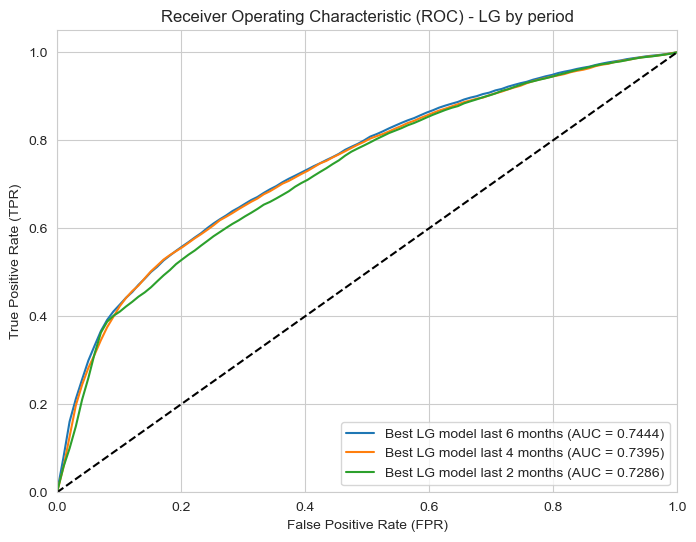

In [781]:
fpr_6mns,tpr_6mns,roc_auc_6mns=get_fpr_tpr_auc(LG_period_cmpr, 0)
fpr_4mns,tpr_4mns,roc_auc_4mns=get_fpr_tpr_auc(LG_period_cmpr, 1)
fpr_2mns,tpr_2mns,roc_auc_2mns=get_fpr_tpr_auc(LG_period_cmpr, 2)

# Plotting ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_6mns,tpr_6mns, label='Best LG model last 6 months (AUC = %0.4f)' % roc_auc_6mns)
plt.plot(fpr_4mns,tpr_4mns, label='Best LG model last 4 months (AUC = %0.4f)' % roc_auc_4mns)
plt.plot(fpr_2mns,tpr_2mns, label='Best LG model last 2 months (AUC = %0.4f)' % roc_auc_2mns)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) - LG by period')
plt.legend(loc='lower right')
plt.show()

Period of the last 6 months was chosen since it gives the highest accuracy, auc and f1.

## Select the Best Logistic Regression Model:

In [575]:
available_methods = ['6 Months', '4 Months', '2 Months']
print("Available period frame:")
for i, method in enumerate(available_methods, 1):
    print(f"{i}. {method}")

selected_method = int(input("Enter the number corresponding to the period frame you want to use based on the analysis: "))

if selected_method==1:
    LG_best_education_method=best_education_method_6mns
    LG_best_marriage_method=best_marriage_method_6mns
    LG_best_selected_features=best_selected_features_6mns
    LG_best_n_iter=best_n_iter_6mns
    LG_best_eps=best_eps_6mns
    LG_best_penalty=best_penalty_6mns
    LG_best_threshold=best_threshold_6mns
    LG_best_imbalance=best_imbalance_6mns
    LG_best_scaler=best_scaler_6mns
    LG_best_feature_selection_method=best_feature_selection_method_6mns
    dic_results=LG_model_evaluation(LG_best_education_method,LG_best_marriage_method,LG_best_selected_features,LG_best_n_iter,LG_best_eps,LG_best_penalty,LG_best_threshold,LG_best_imbalance,LG_best_scaler,6,LG_best_feature_selection_method,comparison_type=update_models_general_summery)
    
if selected_method==2:
    LG_best_education_method=best_education_method_4mns
    LG_best_marriage_method=best_marriage_method_4mns
    LG_best_selected_features=best_selected_features_4mns
    LG_best_n_iter=best_n_iter_4mns
    LG_best_eps=best_eps_4mns
    LG_best_penalty=best_penalty_4mns
    LG_best_threshold=best_threshold_4mns
    LG_best_imbalance=best_imbalance_4mns
    LG_best_scaler=best_scaler_4mns
    LG_best_feature_selection_method=best_feature_selection_method_4mns
    dic_results=LG_model_evaluation(LG_best_education_method,LG_best_marriage_method,LG_best_selected_features,LG_best_n_iter,LG_best_eps,LG_best_penalty,LG_best_threshold,LG_best_imbalance,LG_best_scaler,4,LG_best_feature_selection_method,comparison_type=update_models_general_summery)
    
if selected_method==3:
    LG_best_education_method=best_education_method_2mns
    LG_best_marriage_method=best_marriage_method_2mns
    LG_best_selected_features=best_selected_features_2mns
    LG_best_n_iter=best_n_iter_2mns
    LG_best_eps=best_eps_2mns
    LG_best_penalty=best_penalty_2mns
    LG_best_threshold=best_threshold_2mns
    LG_best_imbalance=best_imbalance_2mns
    LG_best_scaler=best_scaler_2mns
    LG_best_feature_selection_method=best_feature_selection_method_2mns
    dic_results=LG_model_evaluation(LG_best_education_method,LG_best_marriage_method,LG_best_selected_features,LG_best_n_iter,LG_best_eps,LG_best_penalty,LG_best_threshold,LG_best_imbalance,LG_best_scaler,2,LG_best_feature_selection_method,comparison_type=update_models_general_summery)

Model_Performance_Metrics(dic_results,'Best LG Model')

Available period frame:
1. 6 Months
2. 4 Months
3. 2 Months
Enter the number corresponding to the period frame you want to use based on the analysis: 1
<function update_models_general_summery at 0x7fc5a174f4c0>
Performance Metrics for Best LG Model

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.781568 |
+-----------+----------+
| recall    | 0.800924 |
+-----------+----------+
| precision | 0.77915  |
+-----------+----------+
| accuracy  | 0.800924 |
+-----------+----------+
Accuracy: 0.8009238422361719 - The model outperforms the prior model


# Random Forest model-
## <font color='navy'>Investigating Model Performance by Period:</font>
## A Period of 6 Months-
### <font color='darkblue'>Investigating Model Performance by feature Selection Methods for a Period of 6 Months:</font>
### Feature Selection Method 1: Random Selection-

In [321]:
RF_random_selection_dic={'education_method': [],
                          'marriage_method': [],
                          'n_estimators': [],
                          'criterion': [],
                          'max_depth': [],
                          'min_samples_split': [],
                          'min_samples_leaf': [],
                          'max_features':[],
                          'select_features':[],
                          'imbalance':[],
                          'scaler':[],
                          'F1_score': []}

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X1,y1,random_selection)
update_models_summery_RF(RF_random_selection_dic,1,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X2,y2,random_selection)
update_models_summery_RF(RF_random_selection_dic,1,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X3,y3,random_selection)
update_models_summery_RF(RF_random_selection_dic,2,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X4,y4,random_selection)
update_models_summery_RF(RF_random_selection_dic,2,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X5,y5,random_selection)
update_models_summery_RF(RF_random_selection_dic,3,3,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X1,y1,random_selection,imbalance=1)
update_models_summery_RF(RF_random_selection_dic,1,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X2,y2,random_selection,imbalance=1)
update_models_summery_RF(RF_random_selection_dic,1,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X3,y3,random_selection,imbalance=1)
update_models_summery_RF(RF_random_selection_dic,2,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X4,y4,random_selection,imbalance=1)
update_models_summery_RF(RF_random_selection_dic,2,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X5,y5,random_selection,imbalance=1)
update_models_summery_RF(RF_random_selection_dic,3,3,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

In [322]:
print_model_summery(RF_random_selection_dic)

In [323]:
best_education_method_RS, best_marriage_method_RS, best_n_estimators_RS, best_criterion_RS, best_max_depth_RS, best_min_samples_split_RS, best_min_samples_leaf_RS, best_max_features_RS, best_select_features_RS, best_imbalance_RS, best_scaler_RS = RF_Best_Parameters(RF_random_selection_dic)

#### Best Random Forest Model by random selection: Scores

In [715]:
RF_feature_selection_cmpr={}
RF_feature_selection_cmpr=create_feature_selection_method_summery(RF_feature_selection_cmpr)

In [716]:
dic_results=RF_model_evaluation(best_education_method_RS, best_marriage_method_RS, best_n_estimators_RS, best_criterion_RS, best_max_depth_RS, best_min_samples_split_RS, best_min_samples_leaf_RS, best_max_features_RS, best_select_features_RS, best_imbalance_RS, best_scaler_RS,6,'Random Selection',update_models_by_feature_selection_method_summery,cmpr_dic=RF_feature_selection_cmpr)

update_models_by_feature_selection_method_summery


In [717]:
Model_Performance_Metrics(dic_results,'Random Forest last 6 months with Random Selection')

Performance Metrics for Random Forest last 6 months with Random Selection

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.777852 |
+-----------+----------+
| recall    | 0.803245 |
+-----------+----------+
| precision | 0.779254 |
+-----------+----------+
| accuracy  | 0.803245 |
+-----------+----------+
Accuracy: 0.8032452919578349 - The model outperforms the prior model


### Feature Selection Method 2: Forward Selection Selection-

In [339]:
RF_random_selection_dic={'education_method': [],
                          'marriage_method': [],
                          'n_estimators': [],
                          'criterion': [],
                          'max_depth': [],
                          'min_samples_split': [],
                          'min_samples_leaf': [],
                          'max_features':[],
                          'select_features':[],
                          'imbalance':[],
                          'scaler':[],
                          'F1_score': []}

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X1,y1,forward_selection)
update_models_summery_RF(RF_random_selection_dic,1,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X2,y2,forward_selection)
update_models_summery_RF(RF_random_selection_dic,1,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X3,y3,forward_selection)
update_models_summery_RF(RF_random_selection_dic,2,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X4,y4,forward_selection)
update_models_summery_RF(RF_random_selection_dic,2,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X5,y5,forward_selection)
update_models_summery_RF(RF_random_selection_dic,3,3,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X1,y1,forward_selection,imbalance=1)
update_models_summery_RF(RF_random_selection_dic,1,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X2,y2,forward_selection,imbalance=1)
update_models_summery_RF(RF_random_selection_dic,1,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X3,y3,forward_selection,imbalance=1)
update_models_summery_RF(RF_random_selection_dic,2,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X4,y4,forward_selection,imbalance=1)
update_models_summery_RF(RF_random_selection_dic,2,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X5,y5,forward_selection,imbalance=1)
update_models_summery_RF(RF_random_selection_dic,3,3,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

In [340]:
print_model_summery(RF_random_selection_dic)

In [341]:
best_education_method_FS, best_marriage_method_FS, best_n_estimators_FS, best_criterion_FS, best_max_depth_FS, best_min_samples_split_FS, best_min_samples_leaf_FS, best_max_features_FS, best_select_features_FS, best_imbalance_FS, best_scaler_FS = RF_Best_Parameters(RF_random_selection_dic)

#### Best Random Forest  Model by Forward selection: Scores

In [718]:
dic_results=RF_model_evaluation(best_education_method_FS, best_marriage_method_FS, best_n_estimators_FS, best_criterion_FS, best_max_depth_FS, best_min_samples_split_FS, best_min_samples_leaf_FS, best_max_features_FS, best_select_features_FS, best_imbalance_FS, best_scaler_FS,6,'Forward Selection',update_models_by_feature_selection_method_summery,cmpr_dic=RF_feature_selection_cmpr)

update_models_by_feature_selection_method_summery


In [719]:
Model_Performance_Metrics(dic_results,'Random Forest last 6 months with Forward Selection')

Performance Metrics for Random Forest last 6 months with Forward Selection

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.779365 |
+-----------+----------+
| recall    | 0.805733 |
+-----------+----------+
| precision | 0.782336 |
+-----------+----------+
| accuracy  | 0.805733 |
+-----------+----------+
Accuracy: 0.8057325595167594 - The model outperforms the prior model


### Feature Selection Method 3: Selection by Importances-

In [349]:
RF_random_selection_dic={'education_method': [],
                          'marriage_method': [],
                          'n_estimators': [],
                          'criterion': [],
                          'max_depth': [],
                          'min_samples_split': [],
                          'min_samples_leaf': [],
                          'max_features':[],
                          'select_features':[],
                          'imbalance':[],
                          'scaler':[],
                          'F1_score': []}

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X1,y1,selection_by_importances)
update_models_summery_RF(RF_random_selection_dic,1,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X2,y2,selection_by_importances)
update_models_summery_RF(RF_random_selection_dic,1,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X3,y3,selection_by_importances)
update_models_summery_RF(RF_random_selection_dic,2,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X4,y4,selection_by_importances)
update_models_summery_RF(RF_random_selection_dic,2,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X5,y5,selection_by_importances)
update_models_summery_RF(RF_random_selection_dic,3,3,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X1,y1,selection_by_importances,imbalance=1)
update_models_summery_RF(RF_random_selection_dic,1,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X2,y2,selection_by_importances,imbalance=1)
update_models_summery_RF(RF_random_selection_dic,1,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X3,y3,selection_by_importances,imbalance=1)
update_models_summery_RF(RF_random_selection_dic,2,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X4,y4,selection_by_importances,imbalance=1)
update_models_summery_RF(RF_random_selection_dic,2,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X5,y5,selection_by_importances,imbalance=1)
update_models_summery_RF(RF_random_selection_dic,3,3,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

In [350]:
print_model_summery(RF_random_selection_dic)

In [351]:
best_education_method_IS, best_marriage_method_IS, best_n_estimators_IS, best_criterion_IS, best_max_depth_IS, best_min_samples_split_IS, best_min_samples_leaf_IS, best_max_features_IS, best_select_features_IS, best_imbalance_IS, best_scaler_IS = RF_Best_Parameters(RF_random_selection_dic)

#### Best Random Forest Model by importences selection: Scores

In [720]:
dic_results=RF_model_evaluation(best_education_method_IS, best_marriage_method_IS, best_n_estimators_IS, best_criterion_IS, best_max_depth_IS, best_min_samples_split_IS, best_min_samples_leaf_IS, best_max_features_IS, best_select_features_IS, best_imbalance_IS, best_scaler_IS,6,'Selection by Importances',update_models_by_feature_selection_method_summery,cmpr_dic=RF_feature_selection_cmpr)

update_models_by_feature_selection_method_summery


In [721]:
Model_Performance_Metrics(dic_results,'Random Forest last 6 months with Selection by Importances')

Performance Metrics for Random Forest last 6 months with Selection by Importances

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.767821 |
+-----------+----------+
| recall    | 0.761009 |
+-----------+----------+
| precision | 0.777065 |
+-----------+----------+
| accuracy  | 0.761009 |
+-----------+----------+
Accuracy: 0.7610091199810494 - The model underperforms compared to the prior model


### Comparison of feature selection methods for the best Ramdom forest models

In [722]:
print_cmpr_dic(RF_feature_selection_cmpr)

Model_type Features_Selection_method  F1_score    recall  precision  \
0         RF          Random Selection  0.777852  0.803245   0.779254   
1         RF         Forward Selection  0.779365  0.805733   0.782336   
2         RF  Selection by Importances  0.767821  0.761009   0.777065   

   accuracy   roc_auc  
0  0.803245  0.739279  
1  0.805733  0.749313  
2  0.761009  0.754451

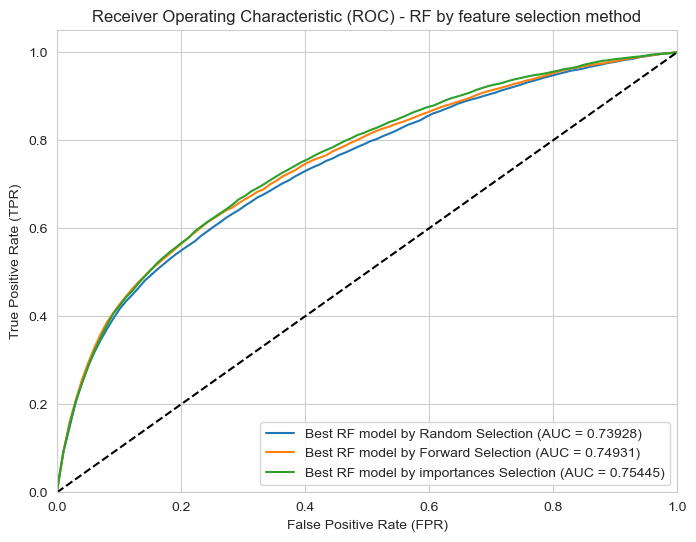

In [723]:
RS_tpr,RS_fpr,RS_roc_auc=get_fpr_tpr_auc(RF_feature_selection_cmpr, 0)
FS_tpr,FS_fpr,FS_roc_auc=get_fpr_tpr_auc(RF_feature_selection_cmpr, 1)
IS_tpr,IS_fpr,IS_roc_auc=get_fpr_tpr_auc(RF_feature_selection_cmpr, 2)

# Plotting ROC curves
plt.figure(figsize=(8, 6))
plt.plot(RS_fpr,RS_tpr, label='Best RF model by Random Selection (AUC = %0.5f)' % RS_roc_auc)
plt.plot(FS_fpr,FS_tpr, label='Best RF model by Forward Selection (AUC = %0.5f)' % FS_roc_auc)
plt.plot(IS_fpr,IS_tpr, label='Best RF model by importances Selection (AUC = %0.5f)' % IS_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) - RF by feature selection method')
plt.legend(loc='lower right')
plt.show()

For a period of 6 months, **Selection by Forward Selection** was chosen since it gives the highest accuracy and f1.

In [731]:
available_methods = ['Random Selection', 'Forward Selection', 'Selection by Importances']
print("Available feature selection methods:")
for i, method in enumerate(available_methods, 1):
    print(f"{i}. {method}")

selected_method = int(input("Enter the number corresponding to the selected feature selection method you want to use based on the analysis: "))

RF_period_cmpr={}
RF_period_cmpr=create_period_summery(RF_period_cmpr)

if selected_method==1:
    best_education_method_6mns = best_education_method_FS
    best_marriage_method_6mns = best_marriage_method_FS
    best_n_estimators_6mns = best_n_estimators_FS
    best_criterion_6mns = best_criterion_FS
    best_max_depth_6mns = best_max_depth_FS
    best_min_samples_split_6mns = best_min_samples_split_FS
    best_min_samples_leaf_6mns = best_min_samples_leaf_FS
    best_max_features_6mns = best_max_features_FS
    best_select_features_6mns = best_select_features_FS
    best_imbalance_6mns = best_imbalance_FS
    best_scaler_6mns = best_scaler_FS
    best_feature_selection_method_6mns='Random Selection'
    
    dic_results = RF_model_evaluation(best_education_method_6mns, best_marriage_method_6mns, best_n_estimators_6mns, best_criterion_6mns, best_max_depth_6mns, best_min_samples_split_6mns, best_min_samples_leaf_6mns, best_max_features_6mns, best_select_features_6mns, best_imbalance_6mns, best_scaler_6mns, 6, 'Random Selection', update_models_by_period_summery, cmpr_dic=RF_period_cmpr)
    
if selected_method==2:
    best_education_method_6mns = best_education_method_RS
    best_marriage_method_6mns = best_marriage_method_RS
    best_n_estimators_6mns = best_n_estimators_RS
    best_criterion_6mns = best_criterion_RS
    best_max_depth_6mns = best_max_depth_RS
    best_min_samples_split_6mns = best_min_samples_split_RS
    best_min_samples_leaf_6mns = best_min_samples_leaf_RS
    best_max_features_6mns = best_max_features_RS
    best_select_features_6mns = best_select_features_RS
    best_imbalance_6mns = best_imbalance_RS
    best_scaler_6mns = best_scaler_RS
    best_feature_selection_method_6mns='Forward Selection'
    
    dic_results = RF_model_evaluation(best_education_method_6mns, best_marriage_method_6mns, best_n_estimators_6mns, best_criterion_6mns, best_max_depth_6mns, best_min_samples_split_6mns, best_min_samples_leaf_6mns, best_max_features_6mns, best_select_features_6mns, best_imbalance_6mns, best_scaler_6mns, 6, 'Forward Selection', update_models_by_period_summery, cmpr_dic=RF_period_cmpr)

if selected_method==3:
    best_education_method_6mns = best_education_method_IS
    best_marriage_method_6mns = best_marriage_method_IS
    best_n_estimators_6mns = best_n_estimators_IS
    best_criterion_6mns = best_criterion_IS
    best_max_depth_6mns = best_max_depth_IS
    best_min_samples_split_6mns = best_min_samples_split_IS
    best_min_samples_leaf_6mns = best_min_samples_leaf_IS
    best_max_features_6mns = best_max_features_IS
    best_select_features_6mns = best_select_features_IS
    best_imbalance_6mns = best_imbalance_IS
    best_scaler_6mns = best_scaler_IS
    best_feature_selection_method_6mns='Selection by Importances'
    dic_results = RF_model_evaluation(best_education_method_6mns, best_marriage_method_6mns, best_n_estimators_6mns, best_criterion_6mns, best_max_depth_6mns, best_min_samples_split_6mns, best_min_samples_leaf_6mns, best_max_features_6mns, best_select_features_6mns, best_imbalance_6mns, best_scaler_6mns, 6, 'Selection by Importances', update_models_by_period_summery, cmpr_dic=RF_period_cmpr)
    
Model_Performance_Metrics(dic_results,'Best RF Model for a period of 6 months')

Available feature selection methods:
1. Random Selection
2. Forward Selection
3. Selection by Importances
Enter the number corresponding to the selected feature selection method you want to use based on the analysis: 2
update_models_by_period_summery
done
Performance Metrics for Best RF Model for a period of 6 months

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.776434 |
+-----------+----------+
| recall    | 0.802393 |
+-----------+----------+
| precision | 0.778355 |
+-----------+----------+
| accuracy  | 0.802393 |
+-----------+----------+
Accuracy: 0.8023925145090608 - The model outperforms the prior model


## A Period of 4 Months-
### <font color='darkblue'>Investigating Model Performance by feature Selection Methods for a Period of 6 Months:</font>
### Feature Selection Method 1: Random Selection-

In [641]:
RF_forward_selection_dic={'education_method': [],
                          'marriage_method': [],
                          'n_estimators': [],
                          'criterion': [],
                          'max_depth': [],
                          'min_samples_split': [],
                          'min_samples_leaf': [],
                          'max_features':[],
                          'select_features':[],
                          'imbalance':[],
                          'scaler':[],
                          'F1_score': []}

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X1_4mns,y1_4mns,random_selection)
update_models_summery_RF(RF_random_selection_dic,1,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X2_4mns,y2_4mns,random_selection)
update_models_summery_RF(RF_random_selection_dic,1,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X3_4mns,y3_4mns,random_selection)
update_models_summery_RF(RF_random_selection_dic,2,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X4_4mns,y4_4mns,random_selection)
update_models_summery_RF(RF_random_selection_dic,2,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X5_4mns,y5_4mns,random_selection)
update_models_summery_RF(RF_random_selection_dic,3,3,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X1_4mns,y1_4mns,random_selection,imbalance=1)
update_models_summery_RF(RF_random_selection_dic,1,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X2_4mns,y2_4mns,random_selection,imbalance=1)
update_models_summery_RF(RF_random_selection_dic,1,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X3_4mns,y3_4mns,random_selection,imbalance=1)
update_models_summery_RF(RF_random_selection_dic,2,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X4_4mns,y4_4mns,random_selection,imbalance=1)
update_models_summery_RF(RF_random_selection_dic,2,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X5_4mns,y5_4mns,random_selection,imbalance=1)
update_models_summery_RF(RF_random_selection_dic,3,3,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

In [642]:
print_model_summery(RF_random_selection_dic)

In [643]:
best_education_method_RS, best_marriage_method_RS, best_n_estimators_RS, best_criterion_RS, best_max_depth_RS, best_min_samples_split_RS, best_min_samples_leaf_RS, best_max_features_RS, best_select_features_RS, best_imbalance_RS, best_scaler_RS = RF_Best_Parameters(RF_random_selection_dic)

#### Best Random Forest Model by random selection: Scores

In [655]:
RF_feature_selection_cmpr={}
RF_feature_selection_cmpr=create_feature_selection_method_summery(RF_feature_selection_cmpr)

In [656]:
dic_results=RF_model_evaluation(best_education_method_RS, best_marriage_method_RS, best_n_estimators_RS, best_criterion_RS, best_max_depth_RS, best_min_samples_split_RS, best_min_samples_leaf_RS, best_max_features_RS, best_select_features_RS, best_imbalance_RS, best_scaler_RS,4,'Random Selection',update_models_by_feature_selection_method_summery,cmpr_dic=RF_feature_selection_cmpr)

In [657]:
Model_Performance_Metrics(dic_results,'Random Forest last 4 months with Random Selection')

Performance Metrics for Random Forest last 4 months with Random Selection

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.775169 |
+-----------+----------+
| recall    | 0.801445 |
+-----------+----------+
| precision | 0.777101 |
+-----------+----------+
| accuracy  | 0.801445 |
+-----------+----------+
Accuracy: 0.8014449840104229 - The model outperforms the prior model


### Feature Selection Method 2: Forward Selection Selection-

In [658]:
RF_forward_selection_dic={'education_method': [],
                          'marriage_method': [],
                          'n_estimators': [],
                          'criterion': [],
                          'max_depth': [],
                          'min_samples_split': [],
                          'min_samples_leaf': [],
                          'max_features':[],
                          'select_features':[],
                          'imbalance':[],
                          'scaler':[],
                          'F1_score': []}

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X1_4mns,y1_4mns,forward_selection)
update_models_summery_RF(RF_forward_selection_dic,1,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X2_4mns,y2_4mns,forward_selection)
update_models_summery_RF(RF_forward_selection_dic,1,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X3_4mns,y3_4mns,forward_selection)
update_models_summery_RF(RF_forward_selection_dic,2,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X4_4mns,y4_4mns,forward_selection)
update_models_summery_RF(RF_forward_selection_dic,2,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X5_4mns,y5_4mns,forward_selection)
update_models_summery_RF(RF_forward_selection_dic,3,3,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X1_4mns,y1_4mns,forward_selection,imbalance=1)
update_models_summery_RF(RF_forward_selection_dic,1,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X2_4mns,y2_4mns,forward_selection,imbalance=1)
update_models_summery_RF(RF_forward_selection_dic,1,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X3_4mns,y3_4mns,forward_selection,imbalance=1)
update_models_summery_RF(RF_forward_selection_dic,2,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X4_4mns,y4_4mns,forward_selection,imbalance=1)
update_models_summery_RF(RF_forward_selection_dic,2,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X5_4mns,y5_4mns,forward_selection,imbalance=1)
update_models_summery_RF(RF_forward_selection_dic,3,3,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

In [659]:
print_model_summery(RF_forward_selection_dic)

In [660]:
best_education_method_FS, best_marriage_method_FS, best_n_estimators_FS, best_criterion_FS, best_max_depth_FS, best_min_samples_split_FS, best_min_samples_leaf_FS, best_max_features_FS, best_select_features_FS, best_imbalance_FS, best_scaler_FS = RF_Best_Parameters(RF_forward_selection_dic)

#### Best Random Forest Model by Forward Selection: Scores

In [661]:
dic_results=RF_model_evaluation(best_education_method_FS, best_marriage_method_FS, best_n_estimators_FS, best_criterion_FS, best_max_depth_FS, best_min_samples_split_FS, best_min_samples_leaf_FS, best_max_features_FS, best_select_features_FS, best_imbalance_FS, best_scaler_FS,4,'Forward Selection',update_models_by_feature_selection_method_summery,cmpr_dic=RF_feature_selection_cmpr)

In [662]:
Model_Performance_Metrics(dic_results,'Random Forest last 4 months with Forward Selection')

Performance Metrics for Random Forest last 4 months with Forward Selection

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.769896 |
+-----------+----------+
| recall    | 0.764586 |
+-----------+----------+
| precision | 0.776903 |
+-----------+----------+
| accuracy  | 0.764586 |
+-----------+----------+
Accuracy: 0.7645860476134075 - The model underperforms compared to the prior model


### Feature Selection Method 3: Selection by Importances-

In [663]:
RF_importances_selection_dic={'education_method': [],
                          'marriage_method': [],
                          'n_estimators': [],
                          'criterion': [],
                          'max_depth': [],
                          'min_samples_split': [],
                          'min_samples_leaf': [],
                          'max_features':[],
                          'select_features':[],
                          'imbalance':[],
                          'scaler':[],
                          'F1_score': []}

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X1_4mns,y1_4mns,selection_by_importances)
update_models_summery_RF(RF_importances_selection_dic,1,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X2_4mns,y2_4mns,selection_by_importances)
update_models_summery_RF(RF_importances_selection_dic,1,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X3_4mns,y3_4mns,selection_by_importances)
update_models_summery_RF(RF_importances_selection_dic,2,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X4_4mns,y4_4mns,selection_by_importances)
update_models_summery_RF(RF_importances_selection_dic,2,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X5_4mns,y5_4mns,selection_by_importances)
update_models_summery_RF(RF_importances_selection_dic,3,3,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X1_4mns,y1_4mns,selection_by_importances,imbalance=1)
update_models_summery_RF(RF_importances_selection_dic,1,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X2_4mns,y2_4mns,selection_by_importances,imbalance=1)
update_models_summery_RF(RF_importances_selection_dic,1,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X3_4mns,y3_4mns,selection_by_importances,imbalance=1)
update_models_summery_RF(RF_importances_selection_dic,2,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X4_4mns,y4_4mns,selection_by_importances,imbalance=1)
update_models_summery_RF(RF_importances_selection_dic,2,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X5_4mns,y5_4mns,selection_by_importances,imbalance=1)
update_models_summery_RF(RF_importances_selection_dic,3,3,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

In [653]:
print_model_summery(RF_importances_selection_dic)

In [654]:
best_education_method_IS, best_marriage_method_IS, best_n_estimators_IS, best_criterion_IS, best_max_depth_IS, best_min_samples_split_IS, best_min_samples_leaf_IS, best_max_features_IS, best_select_features_IS, best_imbalance_IS, best_scaler_IS = RF_Best_Parameters(RF_importances_selection_dic)

#### Best Random Forest Model by Importances selection: Scores

In [664]:
dic_results=RF_model_evaluation(best_education_method_IS, best_marriage_method_IS, best_n_estimators_IS, best_criterion_IS, best_max_depth_IS, best_min_samples_split_IS, best_min_samples_leaf_IS, best_max_features_IS, best_select_features_IS, best_imbalance_IS, best_scaler_IS,4,'Selection by Importances',update_models_by_feature_selection_method_summery,cmpr_dic=RF_feature_selection_cmpr)

In [665]:
Model_Performance_Metrics(dic_results,'Random Forest last 4 months with Selection by Importances')

Performance Metrics for Random Forest last 4 months with Selection by Importances

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.77233  |
+-----------+----------+
| recall    | 0.802321 |
+-----------+----------+
| precision | 0.777356 |
+-----------+----------+
| accuracy  | 0.802321 |
+-----------+----------+
Accuracy: 0.8023214497216629 - The model outperforms the prior model


### Comparison of feature selection methods for the best Random Forest models

In [666]:
print_cmpr_dic(RF_feature_selection_cmpr)

Model_type Features_Selection_method  F1_score    recall  precision  \
0         RF          Random Selection  0.775169  0.801445   0.777101   
1         RF         Forward Selection  0.769896  0.764586   0.776903   
2         RF  Selection by Importances  0.772330  0.802321   0.777356   

   accuracy   roc_auc  
0  0.801445  0.742817  
1  0.764586  0.758036  
2  0.802321  0.741707

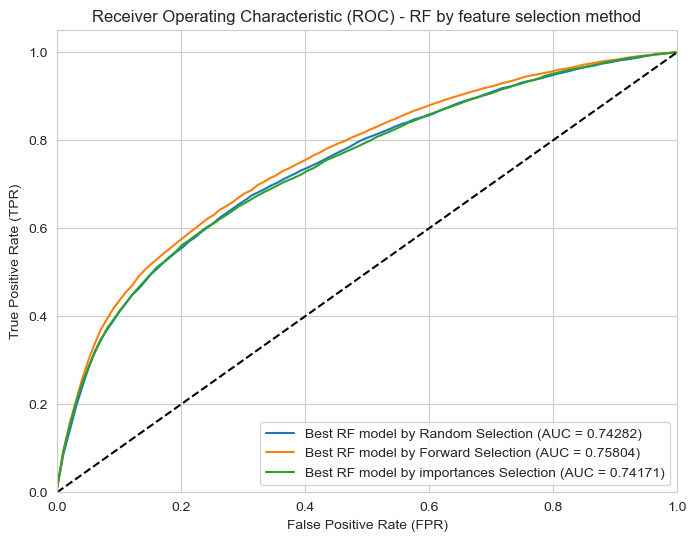

In [667]:
RS_tpr,RS_fpr,RS_roc_auc=get_fpr_tpr_auc(RF_feature_selection_cmpr, 0)
FS_tpr,FS_fpr,FS_roc_auc=get_fpr_tpr_auc(RF_feature_selection_cmpr, 1)
IS_tpr,IS_fpr,IS_roc_auc=get_fpr_tpr_auc(RF_feature_selection_cmpr, 2)

# Plotting ROC curves
plt.figure(figsize=(8, 6))
plt.plot(RS_fpr,RS_tpr, label='Best RF model by Random Selection (AUC = %0.5f)' % RS_roc_auc)
plt.plot(FS_fpr,FS_tpr, label='Best RF model by Forward Selection (AUC = %0.5f)' % FS_roc_auc)
plt.plot(IS_fpr,IS_tpr, label='Best RF model by importances Selection (AUC = %0.5f)' % IS_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) - RF by feature selection method')
plt.legend(loc='lower right')
plt.show()

For a period of 4 months, **Selection by Random Selection** which yields higher accuracy than the prior model and the highest f1.

In [735]:
available_methods = ['Random Selection', 'Forward Selection', 'Selection by Importances']
print("Available feature selection methods:")
for i, method in enumerate(available_methods, 1):
    print(f"{i}. {method}")

selected_method = int(input("Enter the number corresponding to the selected feature selection method you want to use based on the analysis: "))

if selected_method==1:
    best_education_method_4mns = best_education_method_RS
    best_marriage_method_4mns = best_marriage_method_RS
    best_n_estimators_4mns = best_n_estimators_RS
    best_criterion_4mns = best_criterion_RS
    best_max_depth_4mns = best_max_depth_RS
    best_min_samples_split_4mns = best_min_samples_split_RS
    best_min_samples_leaf_4mns = best_min_samples_leaf_RS
    best_max_features_4mns = best_max_features_RS
    best_select_features_4mns = best_select_features_RS
    best_imbalance_4mns = best_imbalance_RS
    best_scaler_4mns = best_scaler_RS
    best_feature_selection_method_4mns='Random Selection'
    
    dic_results = RF_model_evaluation(best_education_method_4mns, best_marriage_method_4mns, best_n_estimators_4mns, best_criterion_4mns, best_max_depth_4mns, best_min_samples_split_4mns, best_min_samples_leaf_4mns, best_max_features_4mns, best_select_features_4mns, best_imbalance_4mns, best_scaler_4mns, 4, 'Random Selection', update_models_by_period_summery, cmpr_dic=RF_period_cmpr)
    
if selected_method==2:
    best_education_method_4mns = best_education_method_FS
    best_marriage_method_4mns = best_marriage_method_FS
    best_n_estimators_4mns = best_n_estimators_FS
    best_criterion_4mns = best_criterion_FS
    best_max_depth_4mns = best_max_depth_FS
    best_min_samples_split_4mns = best_min_samples_split_FS
    best_min_samples_leaf_4mns = best_min_samples_leaf_FS
    best_max_features_4mns = best_max_features_FS
    best_select_features_4mns = best_select_features_FS
    best_imbalance_4mns = best_imbalance_FS
    best_scaler_4mns = best_scaler_FS
    best_feature_selection_method_4mns='Forward Selection'
    
    dic_results = RF_model_evaluation(best_education_method_4mns, best_marriage_method_4mns, best_n_estimators_4mns, best_criterion_4mns, best_max_depth_4mns, best_min_samples_split_4mns, best_min_samples_leaf_4mns, best_max_features_4mns, best_select_features_4mns, best_imbalance_4mns, best_scaler_4mns, 4, 'Forward Selection', update_models_by_period_summery, cmpr_dic=RF_period_cmpr)

if selected_method==3:
    best_education_method_4mns = best_education_method_IS
    best_marriage_method_4mns = best_marriage_method_IS
    best_n_estimators_4mns = best_n_estimators_IS
    best_criterion_4mns = best_criterion_IS
    best_max_depth_4mns = best_max_depth_IS
    best_min_samples_split_4mns = best_min_samples_split_IS
    best_min_samples_leaf_4mns = best_min_samples_leaf_IS
    best_max_features_4mns = best_max_features_IS
    best_select_features_4mns = best_select_features_IS
    best_imbalance_4mns = best_imbalance_IS
    best_scaler_4mns = best_scaler_IS
    best_feature_selection_method_4mns='Selection by Importances'
    
    dic_results = RF_model_evaluation(best_education_method_4mns, best_marriage_method_4mns, best_n_estimators_4mns, best_criterion_4mns, best_max_depth_4mns, best_min_samples_split_4mns, best_min_samples_leaf_4mns, best_max_features_4mns, best_select_features_4mns, best_imbalance_4mns, best_scaler_4mns, 4, 'Selection by Importances', update_models_by_period_summery, cmpr_dic=RF_period_cmpr)

Model_Performance_Metrics(dic_results, 'Best RF Model for a period of 4 months')


Available feature selection methods:
1. Random Selection
2. Forward Selection
3. Selection by Importances
Enter the number corresponding to the selected feature selection method you want to use based on the analysis: 1
update_models_by_period_summery
done
Performance Metrics for Best RF Model for a period of 4 months

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.770585 |
+-----------+----------+
| recall    | 0.796897 |
+-----------+----------+
| precision | 0.772078 |
+-----------+----------+
| accuracy  | 0.796897 |
+-----------+----------+
Accuracy: 0.7968968376169607 - The model outperforms the prior model


## A Period of 2 Months-
### <font color='darkblue'>Investigating Model Performance by feature Selection Methods for a Period of 6 Months:</font>
### Feature Selection Method 1: Random Selection-

In [670]:
RF_random_selection_dic={'education_method': [],
                          'marriage_method': [],
                          'n_estimators': [],
                          'criterion': [],
                          'max_depth': [],
                          'min_samples_split': [],
                          'min_samples_leaf': [],
                          'max_features':[],
                          'select_features':[],
                          'imbalance':[],
                          'scaler':[],
                          'F1_score': []}

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X1_2mns,y1_2mns,random_selection)
update_models_summery_RF(RF_random_selection_dic,1,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X2_2mns,y2_2mns,random_selection)
update_models_summery_RF(RF_random_selection_dic,1,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X3_2mns,y3_2mns,random_selection)
update_models_summery_RF(RF_random_selection_dic,2,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X4_2mns,y4_2mns,random_selection)
update_models_summery_RF(RF_random_selection_dic,2,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X5_2mns,y5_2mns,random_selection)
update_models_summery_RF(RF_random_selection_dic,3,3,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X1_2mns,y1_2mns,random_selection,imbalance=1)
update_models_summery_RF(RF_random_selection_dic,1,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X2_2mns,y2_2mns,random_selection,imbalance=1)
update_models_summery_RF(RF_random_selection_dic,1,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X3_2mns,y3_2mns,random_selection,imbalance=1)
update_models_summery_RF(RF_random_selection_dic,2,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X4_2mns,y4_2mns,random_selection,imbalance=1)
update_models_summery_RF(RF_random_selection_dic,2,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X5_2mns,y5_2mns,random_selection,imbalance=1)
update_models_summery_RF(RF_random_selection_dic,3,3,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

In [671]:
print_model_summery(RF_random_selection_dic)

In [672]:
best_education_method_RS, best_marriage_method_RS, best_n_estimators_RS, best_criterion_RS, best_max_depth_RS, best_min_samples_split_RS, best_min_samples_leaf_RS, best_max_features_RS, best_select_features_RS, best_imbalance_RS, best_scaler_RS = RF_Best_Parameters(RF_random_selection_dic)

#### Best Random Forest Model by random selection: Scores

In [673]:
RF_feature_selection_cmpr={}
RF_feature_selection_cmpr=create_feature_selection_method_summery(RF_feature_selection_cmpr)

In [674]:
dic_results=RF_model_evaluation(best_education_method_RS, best_marriage_method_RS, best_n_estimators_RS, best_criterion_RS, best_max_depth_RS, best_min_samples_split_RS, best_min_samples_leaf_RS, best_max_features_RS, best_select_features_RS, best_imbalance_RS, best_scaler_RS,2,'Random Selection',update_models_by_feature_selection_method_summery,cmpr_dic=RF_feature_selection_cmpr)

In [675]:
Model_Performance_Metrics(dic_results,'Random Forest last 2 months with Random Selection')

Performance Metrics for Random Forest last 2 months with Random Selection

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.77888  |
+-----------+----------+
| recall    | 0.801445 |
+-----------+----------+
| precision | 0.778381 |
+-----------+----------+
| accuracy  | 0.801445 |
+-----------+----------+
Accuracy: 0.8014449840104229 - The model outperforms the prior model


### Feature Selection Method 2: Forward Selection Selection-

In [676]:
RF_forward_selection_dic={'education_method': [],
                          'marriage_method': [],
                          'n_estimators': [],
                          'criterion': [],
                          'max_depth': [],
                          'min_samples_split': [],
                          'min_samples_leaf': [],
                          'max_features':[],
                          'select_features':[],
                          'imbalance':[],
                          'scaler':[],
                          'F1_score': []}

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X1_2mns,y1_2mns,forward_selection)
update_models_summery_RF(RF_forward_selection_dic,1,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X2_2mns,y2_2mns,forward_selection)
update_models_summery_RF(RF_forward_selection_dic,1,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X3_2mns,y3_2mns,forward_selection)
update_models_summery_RF(RF_forward_selection_dic,2,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X4_2mns,y4_2mns,forward_selection)
update_models_summery_RF(RF_forward_selection_dic,2,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X5_2mns,y5_2mns,forward_selection)
update_models_summery_RF(RF_forward_selection_dic,3,3,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X1_2mns,y1_2mns,forward_selection,imbalance=1)
update_models_summery_RF(RF_forward_selection_dic,1,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X2_2mns,y2_2mns,forward_selection,imbalance=1)
update_models_summery_RF(RF_forward_selection_dic,1,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X3_2mns,y3_2mns,forward_selection,imbalance=1)
update_models_summery_RF(RF_forward_selection_dic,2,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X4_2mns,y4_2mns,forward_selection,imbalance=1)
update_models_summery_RF(RF_forward_selection_dic,2,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X5_2mns,y5_2mns,forward_selection,imbalance=1)
update_models_summery_RF(RF_forward_selection_dic,3,3,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

In [677]:
print_model_summery(RF_forward_selection_dic)

In [678]:
best_education_method_FS, best_marriage_method_FS, best_n_estimators_FS, best_criterion_FS, best_max_depth_FS, best_min_samples_split_FS, best_min_samples_leaf_FS, best_max_features_FS, best_select_features_FS, best_imbalance_FS, best_scaler_FS = RF_Best_Parameters(RF_forward_selection_dic)

#### Best random forest Model by forward selection: Scores

In [679]:
dic_results=RF_model_evaluation(best_education_method_FS, best_marriage_method_FS, best_n_estimators_FS, best_criterion_FS, best_max_depth_FS, best_min_samples_split_FS, best_min_samples_leaf_FS, best_max_features_FS, best_select_features_FS, best_imbalance_FS, best_scaler_FS,2,'Forward Selection',update_models_by_feature_selection_method_summery,cmpr_dic=RF_feature_selection_cmpr)

In [680]:
Model_Performance_Metrics(dic_results,'Random Forest last 2 months with Forward Selection')

Performance Metrics for Random Forest last 2 months with Forward Selection

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.775786 |
+-----------+----------+
| recall    | 0.802487 |
+-----------+----------+
| precision | 0.778289 |
+-----------+----------+
| accuracy  | 0.802487 |
+-----------+----------+
Accuracy: 0.8024872675589245 - The model outperforms the prior model


### Feature Selection Method 3: Selection by Importances-

In [681]:
RF_importances_selection_dic={'education_method': [],
                          'marriage_method': [],
                          'n_estimators': [],
                          'criterion': [],
                          'max_depth': [],
                          'min_samples_split': [],
                          'min_samples_leaf': [],
                          'max_features':[],
                          'select_features':[],
                          'imbalance':[],
                          'scaler':[],
                          'F1_score': []}

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X1_2mns,y1_2mns,selection_by_importances)
update_models_summery_RF(RF_importances_selection_dic,1,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X2_2mns,y2_2mns,selection_by_importances)
update_models_summery_RF(RF_importances_selection_dic,1,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X3_2mns,y3_2mns,selection_by_importances)
update_models_summery_RF(RF_importances_selection_dic,2,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X4_2mns,y4_2mns,selection_by_importances)
update_models_summery_RF(RF_importances_selection_dic,2,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X5_2mns,y5_2mns,selection_by_importances)
update_models_summery_RF(RF_importances_selection_dic,3,3,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'Regular',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X1_2mns,y1_2mns,selection_by_importances,imbalance=1)
update_models_summery_RF(RF_importances_selection_dic,1,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X2_2mns,y2_2mns,selection_by_importances,imbalance=1)
update_models_summery_RF(RF_importances_selection_dic,1,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X3_2mns,y3_2mns,selection_by_importances,imbalance=1)
update_models_summery_RF(RF_importances_selection_dic,2,1,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X4_2mns,y4_2mns,selection_by_importances,imbalance=1)
update_models_summery_RF(RF_importances_selection_dic,2,2,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,best_scaler,best_f1_score=optimize_random_forest_model(X5_2mns,y5_2mns,selection_by_importances,imbalance=1)
update_models_summery_RF(RF_importances_selection_dic,3,3,best_n_estimators,best_criterion,best_max_depth,best_min_samples_split,best_min_samples_leaf,best_max_features,best_select_features,'weighted',best_scaler,best_f1_score)

In [682]:
print_model_summery(RF_importances_selection_dic)

In [683]:
best_education_method_IS, best_marriage_method_IS, best_n_estimators_IS, best_criterion_IS, best_max_depth_IS, best_min_samples_split_IS, best_min_samples_leaf_IS, best_max_features_IS, best_select_features_IS, best_imbalance_IS, best_scaler_IS = RF_Best_Parameters(RF_importances_selection_dic)

#### Best random forest Model by importances selection : Scores

In [684]:
dic_results=RF_model_evaluation(best_education_method_IS, best_marriage_method_IS, best_n_estimators_IS, best_criterion_IS, best_max_depth_IS, best_min_samples_split_IS, best_min_samples_leaf_IS, best_max_features_IS, best_select_features_IS, best_imbalance_IS, best_scaler_IS,2,'Selection by Importances',update_models_by_feature_selection_method_summery,cmpr_dic=RF_feature_selection_cmpr)

In [685]:
Model_Performance_Metrics(dic_results,'Random Forest last 2 months with Selection by Importances')

Performance Metrics for Random Forest last 2 months with Selection by Importances

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.776059 |
+-----------+----------+
| recall    | 0.803601 |
+-----------+----------+
| precision | 0.77917  |
+-----------+----------+
| accuracy  | 0.803601 |
+-----------+----------+
Accuracy: 0.803600615894824 - The model outperforms the prior model


### Comparison of feature selection methods for the best Random Forest models

In [686]:
print_cmpr_dic(RF_feature_selection_cmpr)

Model_type Features_Selection_method  F1_score    recall  precision  \
0         RF          Random Selection  0.778880  0.801445   0.778381   
1         RF         Forward Selection  0.775786  0.802487   0.778289   
2         RF  Selection by Importances  0.776059  0.803601   0.779170   

   accuracy   roc_auc  
0  0.801445  0.714801  
1  0.802487  0.733067  
2  0.803601  0.740302

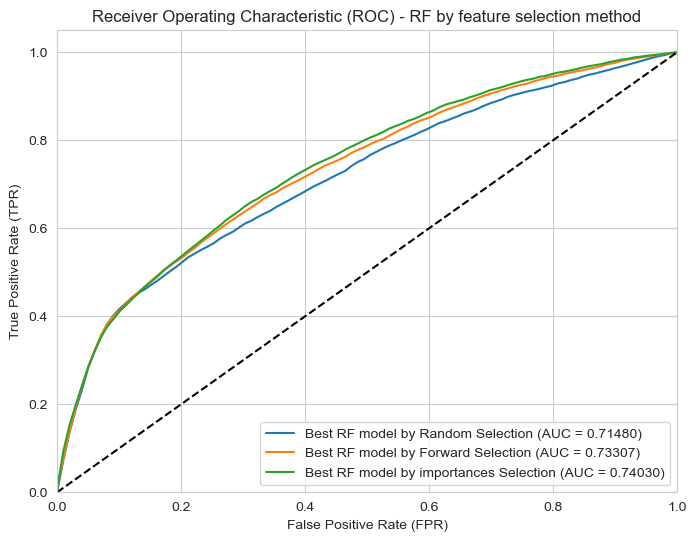

In [689]:
RS_tpr,RS_fpr,RS_roc_auc=get_fpr_tpr_auc(RF_feature_selection_cmpr, 0)
FS_tpr,FS_fpr,FS_roc_auc=get_fpr_tpr_auc(RF_feature_selection_cmpr, 1)
IS_tpr,IS_fpr,IS_roc_auc=get_fpr_tpr_auc(RF_feature_selection_cmpr, 2)

# Plotting ROC curves
plt.figure(figsize=(8, 6))
plt.plot(RS_fpr,RS_tpr, label='Best RF model by Random Selection (AUC = %0.5f)' % RS_roc_auc)
plt.plot(FS_fpr,FS_tpr, label='Best RF model by Forward Selection (AUC = %0.5f)' % FS_roc_auc)
plt.plot(IS_fpr,IS_tpr, label='Best RF model by importances Selection (AUC = %0.5f)' % IS_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) - RF by feature selection method')
plt.legend(loc='lower right')
plt.show()

For a period of 2 months, **Selection by importances Selection** which yields higher accuracy than the prior model and the highest AUC.

In [759]:
available_methods = ['Random Selection', 'Forward Selection', 'Selection by Importances']
print("Available feature selection methods:")
for i, method in enumerate(available_methods, 1):
    print(f"{i}. {method}")

selected_method = int(input("Enter the number corresponding to the selected feature selection method you want to use based on the analysis: "))

if selected_method==1:
    best_education_method_2mns = best_education_method_FS
    best_marriage_method_2mns = best_marriage_method_FS
    best_n_estimators_2mns = best_n_estimators_FS
    best_criterion_2mns = best_criterion_FS
    best_max_depth_2mns = best_max_depth_FS
    best_min_samples_split_2mns = best_min_samples_split_FS
    best_min_samples_leaf_2mns = best_min_samples_leaf_FS
    best_max_features_2mns = best_max_features_FS
    best_select_features_2mns = best_select_features_FS
    best_imbalance_2mns = best_imbalance_FS
    best_scaler_2mns = best_scaler_FS
    best_feature_selection_method_2mns='Random Selection'
    
    dic_results = RF_model_evaluation(best_education_method_2mns, best_marriage_method_2mns, best_n_estimators_2mns, best_criterion_2mns, best_max_depth_2mns, best_min_samples_split_2mns, best_min_samples_leaf_4mns, best_max_features_2mns, best_select_features_2mns, best_imbalance_2mns, best_scaler_2mns, 2, 'Random Selection', update_models_by_period_summery, cmpr_dic=RF_period_cmpr)
    
if selected_method==2:
    best_education_method_2mns = best_education_method_RS
    best_marriage_method_2mns = best_marriage_method_RS
    best_n_estimators_2mns = best_n_estimators_RS
    best_criterion_2mns = best_criterion_RS
    best_max_depth_2mns = best_max_depth_RS
    best_min_samples_split_2mns = best_min_samples_split_RS
    best_min_samples_leaf_2mns = best_min_samples_leaf_RS
    best_max_features_2mns = best_max_features_RS
    best_select_features_2mns = best_select_features_RS
    best_imbalance_2mns = best_imbalance_RS
    best_scaler_2mns = best_scaler_RS
    best_feature_selection_method_2mns='Forward Selection'
    
    dic_results = RF_model_evaluation(best_education_method_2mns, best_marriage_method_2mns, best_n_estimators_2mns, best_criterion_2mns, best_max_depth_2mns, best_min_samples_split_2mns, best_min_samples_leaf_4mns, best_max_features_2mns, best_select_features_2mns, best_imbalance_2mns, best_scaler_2mns, 2, 'Forward Selection', update_models_by_period_summery, cmpr_dic=RF_period_cmpr)

if selected_method==3:
    best_education_method_2mns = best_education_method_IS
    best_marriage_method_2mns = best_marriage_method_IS
    best_n_estimators_2mns = best_n_estimators_IS
    best_criterion_2mns = best_criterion_IS
    best_max_depth_2mns = best_max_depth_IS
    best_min_samples_split_2mns = best_min_samples_split_IS
    best_min_samples_leaf_2mns = best_min_samples_leaf_IS
    best_max_features_2mns = best_max_features_IS
    best_select_features_2mns = best_select_features_IS
    best_imbalance_2mns = best_imbalance_IS
    best_scaler_2mns = best_scaler_IS
    best_feature_selection_method_2mns='Selection by Importances'
    
    dic_results = RF_model_evaluation(best_education_method_2mns, best_marriage_method_2mns, best_n_estimators_2mns, best_criterion_2mns, best_max_depth_2mns, best_min_samples_split_2mns, best_min_samples_leaf_4mns, best_max_features_2mns, best_select_features_2mns, best_imbalance_2mns, best_scaler_2mns, 2, 'Selection by Importances', update_models_by_period_summery, cmpr_dic=RF_period_cmpr)

Model_Performance_Metrics(dic_results, 'Best RF Model for a period of 2 months')


Available feature selection methods:
1. Random Selection
2. Forward Selection
3. Selection by Importances
Enter the number corresponding to the selected feature selection method you want to use based on the analysis: 3
Performance Metrics for Best RF Model for a period of 2 months

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.773951 |
+-----------+----------+
| recall    | 0.803008 |
+-----------+----------+
| precision | 0.779602 |
+-----------+----------+
| accuracy  | 0.803008 |
+-----------+----------+
Accuracy: 0.8030084093331753 - The model outperforms the prior model


## Comparing the Best Models For Each Time Period

In [763]:
print_cmpr_dic(RF_period_cmpr)

Model_type  Period  F1_score    recall  precision  accuracy   roc_auc
0         RF       6  0.776434  0.802393   0.778355  0.802393  0.742020
1         RF       4  0.770585  0.796897   0.772078  0.796897  0.738086
2         RF       2  0.773951  0.803008   0.779602  0.803008  0.740939

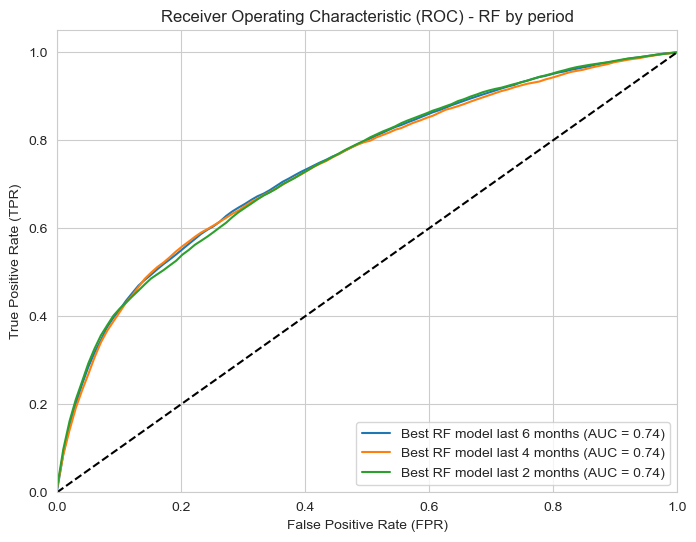

In [780]:
tpr_6mns,fpr_6mns,roc_auc_6mns=get_fpr_tpr_auc(RF_period_cmpr, 0)
tpr_4mns,fpr_4mns,roc_auc_4mns=get_fpr_tpr_auc(RF_period_cmpr, 1)
tpr_2mns,fpr_2mns,roc_auc_2mns=get_fpr_tpr_auc(RF_period_cmpr, 2)

# Plotting ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_6mns,tpr_6mns, label='Best RF model last 6 months (AUC = %0.2f)' % roc_auc_6mns)
plt.plot(fpr_4mns,tpr_4mns, label='Best RF model last 4 months (AUC = %0.2f)' % roc_auc_4mns)
plt.plot(fpr_2mns,tpr_2mns, label='Best RF model last 2 months (AUC = %0.2f)' % roc_auc_2mns)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) - RF by period')
plt.legend(loc='lower right')
plt.show()

Period of the last 6 months was chosen since it gives the highest f1 score

# Select the Best Random Forest Model:

In [773]:
available_methods = ['6 Months', '4 Months', '2 Months']
print("Available period frame:")
for i, method in enumerate(available_methods, 1):
    print(f"{i}. {method}")

selected_method = int(input("Enter the number corresponding to the period frame you want to use based on the analysis: "))


if selected_method==1:
    RF_best_education_method = best_education_method_6mns
    RF_best_marriage_method = best_marriage_method_6mns
    RF_best_n_estimators = best_n_estimators_6mns
    RF_best_criterion = best_criterion_6mns
    RF_best_max_depth = best_max_depth_6mns
    RF_best_min_samples_split = best_min_samples_split_6mns
    RF_best_min_samples_leaf = best_min_samples_leaf_6mns
    RF_best_max_features = best_max_features_6mns
    RF_best_select_features = best_select_features_6mns
    RF_best_imbalance = best_imbalance_6mns
    RF_best_scaler = best_scaler_6mns
    RF_best_feature_selection_method = best_feature_selection_method_6mns
    dic_results = RF_model_evaluation(RF_best_education_method, RF_best_marriage_method, RF_best_n_estimators, RF_best_criterion, RF_best_max_depth, RF_best_min_samples_split, RF_best_min_samples_leaf, RF_best_max_features, RF_best_select_features, RF_best_imbalance, RF_best_scaler, 6, RF_best_feature_selection_method, update_models_general_summery)
    
if selected_method==2:
    RF_best_education_method = best_education_method_4mns
    RF_best_marriage_method = best_marriage_method_4mns
    RF_best_n_estimators = best_n_estimators_4mns
    RF_best_criterion = best_criterion_4mns
    RF_best_max_depth = best_max_depth_4mns
    RF_best_min_samples_split = best_min_samples_split_4mns
    RF_best_min_samples_leaf = best_min_samples_leaf_4mns
    RF_best_max_features = best_max_features_4mns
    RF_best_select_features = best_select_features_4mns
    RF_best_imbalance = best_imbalance_4mns
    RF_best_scaler = best_scaler_4mns
    RF_best_feature_selection_method = best_feature_selection_method_4mns
    dic_results = RF_model_evaluation(RF_best_education_method, RF_best_marriage_method, RF_best_n_estimators, RF_best_criterion, RF_best_max_depth, RF_best_min_samples_split, RF_best_min_samples_leaf, RF_best_max_features, RF_best_select_features, RF_best_imbalance, RF_best_scaler, 4, RF_best_feature_selection_method, update_models_general_summery)

if selected_method==3:
    RF_best_education_method = best_education_method_2mns
    RF_best_marriage_method = best_marriage_method_2mns
    RF_best_n_estimators = best_n_estimators_2mns
    RF_best_criterion = best_criterion_2mns
    RF_best_max_depth = best_max_depth_2mns
    RF_best_min_samples_split = best_min_samples_split_2mns
    RF_best_min_samples_leaf = best_min_samples_leaf_2mns
    RF_best_max_features = best_max_features_2mns
    RF_best_select_features = best_select_features_2mns
    RF_best_imbalance = best_imbalance_2mns
    RF_best_scaler = best_scaler_2mns
    RF_best_feature_selection_method = best_feature_selection_method_2mns
    dic_results = RF_model_evaluation(RF_best_education_method, RF_best_marriage_method, RF_best_n_estimators, RF_best_criterion, RF_best_max_depth, RF_best_min_samples_split, RF_best_min_samples_leaf, RF_best_max_features, RF_best_select_features, RF_best_imbalance, RF_best_scaler, 2, RF_best_feature_selection_method, update_models_general_summery)

Model_Performance_Metrics(dic_results,'Best RF Model:')

Available period frame:
1. 6 Months
2. 4 Months
3. 2 Months
Enter the number corresponding to the period frame you want to use based on the analysis: 1
Performance Metrics for Best RF Model:

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.777256 |
+-----------+----------+
| recall    | 0.802108 |
+-----------+----------+
| precision | 0.778147 |
+-----------+----------+
| accuracy  | 0.802108 |
+-----------+----------+
Accuracy: 0.8021082553594694 - The model outperforms the prior model


# Comparison between the models

In [1011]:
summery = pd.DataFrame(models_summery_final)
summery

Model_type Features_Selection_method   Scaler_method  education_method  \
0        KNN          Random Selection  StandardScaler                 2   
1         LG         Forward Selection    RobustScaler                 2   
2         RF          Random Selection  StandardScaler                 2   

   marriage_method                                           features  \
0                2  (22, 12, 5, 53, 64, 80, 85, 41, 52, 18, 1, 34,...   
1                2  (22, 33, 78, 17, 27, 7, 75, 70, 52, 8, 10, 81,...   
2                1  [32, 56, 81, 28, 3, 53, 47, 41, 1, 76, 19, 14,...   

                                    hyper_parameters  Period  F1_score  \
0                        {'best_k': 15, 'best_p': 1}       6  0.772789   
1  {'n_iter': 2000, 'Eps': 0.0001, 'Penalty': 'l1...       6  0.781568   
2  {'n_estimators': 50, 'criterion': 'gini', 'max...       6  0.777256   

                                  Evaluation_methods  
0  {'recall': 0.799573611275613, 'precision': 0.7...  
1  {'recall': 0.8009238422361719, 'precision': 0....  
2  {'recall': 0.8021082553594694, 'precision': 0....

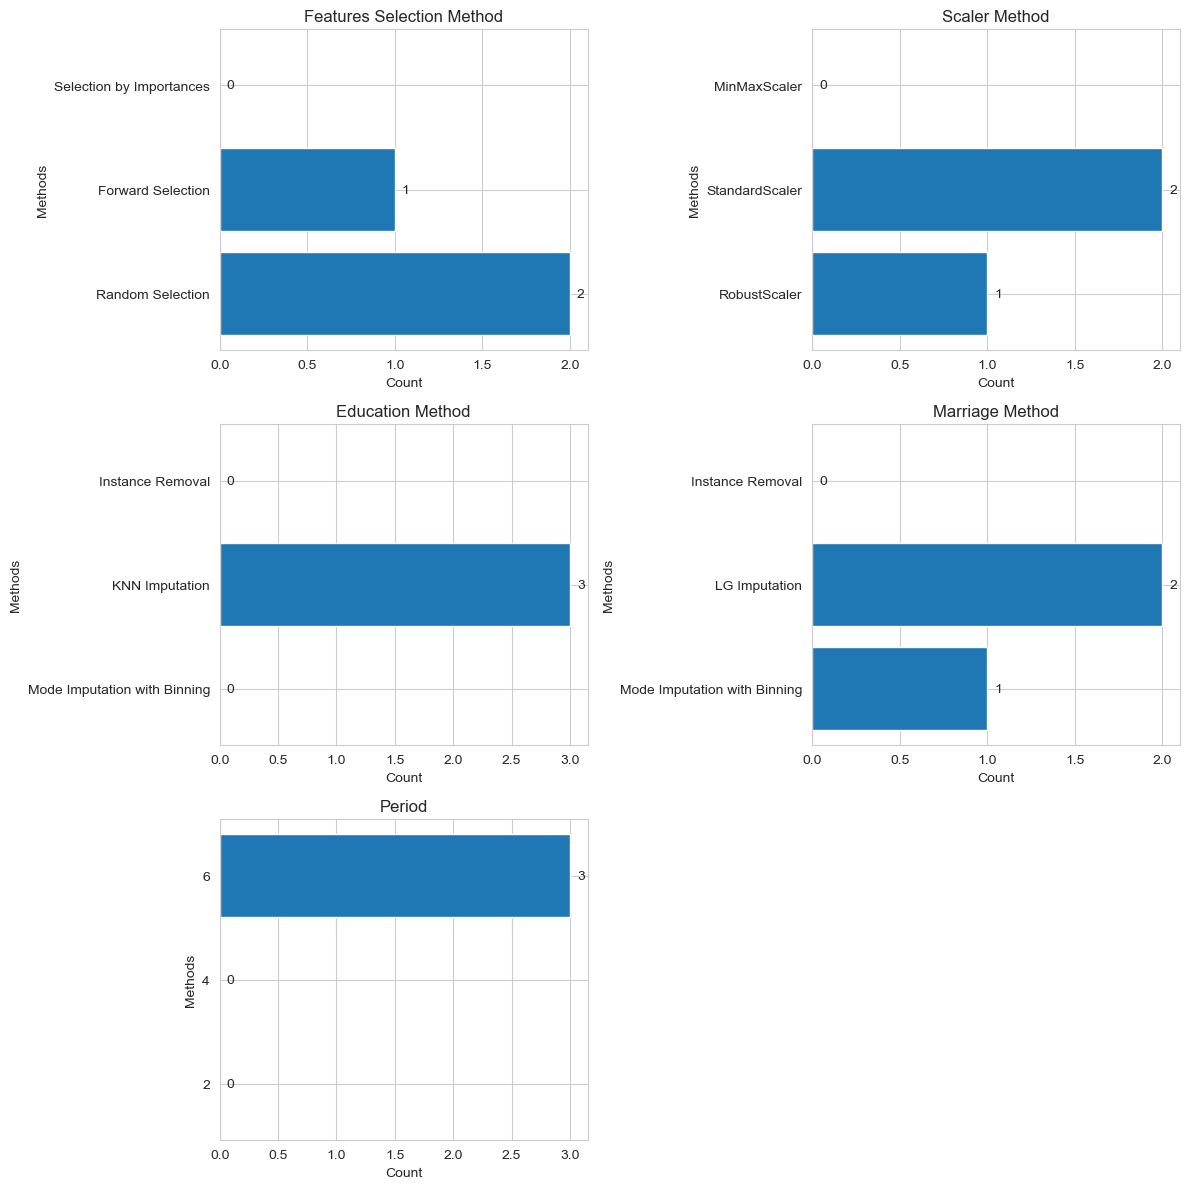

In [902]:
features_selection_methods = models_summery_final['Features_Selection_method']
scaler_methods = models_summery_final['Scaler_method']
education_methods = models_summery_final['education_method'].copy()
marriage_methods = models_summery_final['marriage_method'].copy()
periods = models_summery_final['Period'].copy()

# All possible options for each category
all_feature_selection_methods = ['Random Selection', 'Forward Selection', 'Selection by Importances']
all_scaler_methods = ['RobustScaler', 'StandardScaler', 'MinMaxScaler']
all_education_methods = ["Mode Imputation with Binning", "KNN Imputation", "Instance Removal"]
all_marriage_methods = ["Mode Imputation with Binning", "LG Imputation", "Instance Removal"]
all_periods = ['2', '4', '6']

for i in range(len(marriage_methods)):
    marriage_methods[i]=all_marriage_methods[marriage_methods[i]-1]
for i in range(len(education_methods)):
    education_methods[i]=all_education_methods[education_methods[i]-1]
for i in range(len(periods)):
    periods[i]=str(periods[i])


# Function to count occurrences of options and create horizontal bar plots with annotations
def plot_horizontal_bar_with_annotation(data, all_options, title):
    unique_methods, counts = np.unique(data, return_counts=True)
    option_counts = {option: 0 for option in all_options}
    option_counts.update(dict(zip(unique_methods, counts)))
    plt.barh(list(option_counts.keys()), list(option_counts.values()))
    plt.xlabel('Count')
    plt.ylabel('Methods')
    plt.title(title)
    for i in range(len(list(option_counts.keys()))):
        plt.annotate(option_counts[list(option_counts.keys())[i]], 
                     (option_counts[list(option_counts.keys())[i]], list(option_counts.keys())[i]), 
                     textcoords="offset points", xytext=(5,0), ha='left', va='center')

# Create bar plots for each category
plt.figure(figsize=(12, 12))

plt.subplot(3, 2, 1)
plot_horizontal_bar_with_annotation(features_selection_methods, all_feature_selection_methods, 'Features Selection Method')

plt.subplot(3, 2, 2)
plot_horizontal_bar_with_annotation(scaler_methods, all_scaler_methods, 'Scaler Method')

plt.subplot(3, 2, 3)
plot_horizontal_bar_with_annotation(education_methods, all_education_methods, 'Education Method')

plt.subplot(3, 2, 4)
plot_horizontal_bar_with_annotation(marriage_methods, all_marriage_methods, 'Marriage Method')

plt.subplot(3, 2, 5)
plot_horizontal_bar_with_annotation(periods, all_periods, 'Period')

plt.tight_layout()
plt.show()

It can be seen that data for all of the last six months yielded the model with the best results for each type of model and so did the completion method for the education column with knn. It can also be seen that removing the instances for each type of model did not produce the best results, so did selection by importance and min max scaler (as we discussed at the beginning, this could be a result of our outliers that we decided to leave them as they are since they are the actual population).

In [809]:
rows = []

for i in range(len(models_summery_final['Model_type'])):
    model_type = models_summery_final['Model_type'][i]
    recall = models_summery_final['Evaluation_methods'][i]['recall']
    precision = models_summery_final['Evaluation_methods'][i]['precision']
    accuracy = mofeatures_selection_methods = models_summery_final['Features_Selection_method']
scaler_methods = models_summery_final['Scaler_method']
education_methods = models_summery_final['education_method'].copy()
marriage_methods = models_summery_final['marriage_method'].copy()
periods = models_summery_final['Period'].copy()

# All possible options for each category
all_feature_selection_methods = ['Random Selection', 'Forward Selection', 'Selection by Importances']
all_scaler_methods = ['RobustScaler', 'StandardScaler', 'MinMaxScaler']
all_education_methods = ["Mode Imputation with Binning", "KNN Imputation", "Instance Removal"]
all_marriage_methods = ["Mode Imputation with Binning", "LG Imputation", "Instance Removal"]
all_periods = ['2', '4', '6']

for i in range(len(marriage_methods)):
    marriage_methods[i]=all_marriage_methods[marriage_methods[i]-1]
for i in range(len(education_methods)):
    education_methods[i]=all_education_methods[education_methods[i]-1]
for i in range(len(periods)):
    periods[i]=str(periods[i])


# Function to count occurrences of options and create horizontal bar plots with annotations
def plot_horizontal_bar_with_annotation(data, all_options, title):
    unique_methods, counts = np.unique(data, return_counts=True)
    option_counts = {option: 0 for option in all_options}
    option_counts.update(dict(zip(unique_methods, counts)))
    plt.barh(list(option_counts.keys()), list(option_counts.values()))
    plt.xlabel('Count')
    plt.ylabel('Methods')
    plt.title(title)
    for i in range(len(list(option_counts.keys()))):
        plt.annotate(option_counts[list(option_counts.keys())[i]], 
                     (option_counts[list(option_counts.keys())[i]], list(option_counts.keys())[i]), 
                     textcoords="offset points", xytext=(5,0), ha='left', va='center')

# Create bar plots for each category
plt.figure(figsize=(12, 12))

plt.subplot(3, 2, 1)
plot_horizontal_bar_with_annotation(features_selection_methods, all_feature_selection_methods, 'Features Selection Method')

plt.subplot(3, 2, 2)
plot_horizontal_bar_with_annotation(scaler_methods, all_scaler_methods, 'Scaler Method')

plt.subplot(3, 2, 3)
plot_horizontal_bar_with_annotation(education_methods, all_education_methods, 'Education Method')

plt.subplot(3, 2, 4)
plot_horizontal_bar_with_annotation(marriage_methods, all_marriage_methods, 'Marriage Method')

plt.subplot(3, 2, 5)
plot_horizontal_bar_with_annotation(periods, all_periods, 'Period')

plt.tight_layout()
plt.show()

It can be seen that data for all of the last six months yielded the model with the best results for each type of model and so did the completion method for the education column with knn. It can also be seen that removing the instances for each type of model did not produce the best results, so did selection by importance and min max scaler (as we discussed at the beginning, this could be a result of our outliers that we decided to leave them as they are since they are the actual population).dels_summery_final['Evaluation_methods'][i]['accuracy']
    roc_auc = models_summery_final['Evaluation_methods'][i]['roc_auc']
    f1_score = models_summery_final['F1_score'][i]
    rows.append({
        'Model_type': model_type,
        'recall': recall,
        'precision': precision,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'F1_score': f1_score
    })
df = pd.DataFrame(rows)
df

Model_type    recall  precision  accuracy   roc_auc  F1_score
0        KNN  0.799574   0.774666  0.799574  0.722213  0.772789
1         LG  0.800924   0.779150  0.800924  0.742696  0.781568
2         RF  0.802108   0.778147  0.802108  0.738412  0.777256

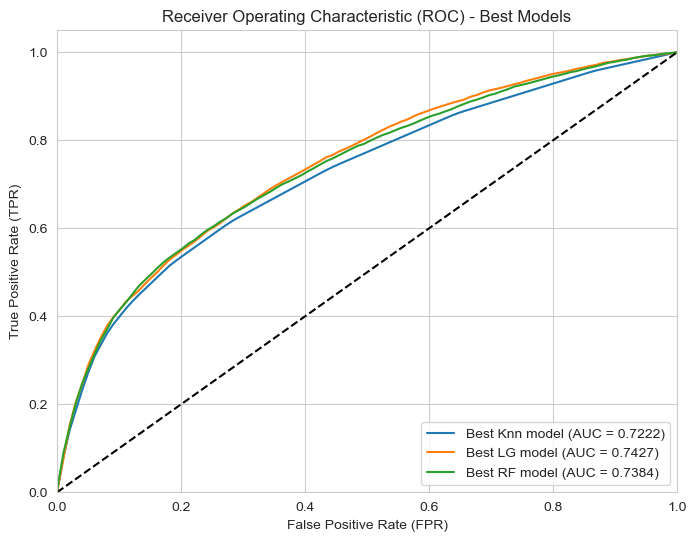

In [804]:
FPR_knn=models_summery_final['Evaluation_methods'][0]['FPR']
TPR_knn=models_summery_final['Evaluation_methods'][0]['TPR']
roc_auc_knn=models_summery_final['Evaluation_methods'][0]['roc_auc']

FPR_LG=models_summery_final['Evaluation_methods'][1]['FPR']
TPR_LG=models_summery_final['Evaluation_methods'][1]['TPR']
roc_auc_LG=models_summery_final['Evaluation_methods'][1]['roc_auc']

FPR_RF=models_summery_final['Evaluation_methods'][2]['FPR']
TPR_RF=models_summery_final['Evaluation_methods'][2]['TPR']
roc_auc_RF=models_summery_final['Evaluation_methods'][2]['roc_auc']

# Plotting ROC curves
plt.figure(figsize=(8, 6))
plt.plot(FPR_knn,TPR_knn, label='Best Knn model (AUC = %0.4f)' % roc_auc_knn)
plt.plot(FPR_LG,TPR_LG, label='Best LG model (AUC = %0.4f)' % roc_auc_LG)
plt.plot(FPR_RF,TPR_RF, label='Best RF model (AUC = %0.4f)' % roc_auc_RF)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) - Best Models')
plt.legend(loc='lower right')
plt.show()

# Select the best model
As you can see the **logistic regression** gives the best indicators in all the parameters and therefore we chose it

In [956]:
"""
The code saves the best model (best_model)
"""

available_methods = ['Knn', 'Logisic Regression', 'Random Forest']
print("Available models:")
for i, method in enumerate(available_methods, 1):
    print(f"{i}. {method}")

selected_method = int(input("Enter the number corresponding to the model you want to use based on the analysis: "))


if selected_method==1:
    best_k=models_summery_final['hyper_parameters'][0]['best_k']
    best_p=models_summery_final['hyper_parameters'][0]['best_p']
    best_features=models_summery_final['features'][0]
    best_scaler=models_summery_final['Scaler_method'][0]
    best_education_method=models_summery_final['education_method'][0]
    best_marriage_method=models_summery_final['marriage_method'][0]
    best_period=models_summery_final['Period'][0]
    
    X,y=identify_relevant_data(best_education_method,best_marriage_method,best_period)
    X=X[:,best_features]
    scaler = eval(best_scaler)()
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
    X_train_scaled = scaler.fit_transform(X_train) 
    best_model = KNeighborsClassifier(n_neighbors=best_k,p=best_p) 
    best_model.fit(X_train_scaled, y_train)
    dic_results = rows[0]
    Model_Performance_Metrics(dic_results,'Best Model (Knn):')

    
elif selected_method==2:
    best_n_iter=models_summery_final['hyper_parameters'][1]['n_iter']
    best_eps=models_summery_final['hyper_parameters'][1]['Eps']
    best_Penalty=models_summery_final['hyper_parameters'][1]['Penalty']
    best_Threshold=models_summery_final['hyper_parameters'][1]['Threshold']
    best_imbalance=models_summery_final['hyper_parameters'][1]['imbalance']
    if best_imbalance=='Regular':
        class_weighted=None
    else:
        class_weighted='balanced'
    best_features=models_summery_final['features'][1]
    best_scaler=models_summery_final['Scaler_method'][1]
    best_education_method=models_summery_final['education_method'][1]
    best_marriage_method=models_summery_final['marriage_method'][1]
    best_period=models_summery_final['Period'][1]
    
    X,y=identify_relevant_data(best_education_method,best_marriage_method,best_period)
    X=X[:,best_features]
    scaler = eval(best_scaler)()
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
    X_train_scaled = scaler.fit_transform(X_train) 
    best_model=LogisticRegression(max_iter=best_n_iter, tol=best_eps, solver='liblinear', penalty=best_Penalty,class_weight=class_weighted)
    best_model.fit(X_train_scaled, y_train)
    ##Remember to predict by the best_Threshold value
    
    dic_results = rows[1]
    Model_Performance_Metrics(dic_results,'Best Model (Logistic Regression):')

elif selected_method==3:
    best_n_estimators=models_summery_final['hyper_parameters'][2]['n_estimators']
    best_criterion=models_summery_final['hyper_parameters'][2]['criterion']
    best_max_depth=models_summery_final['hyper_parameters'][2]['max_depth']
    best_min_samples_split=models_summery_final['hyper_parameters'][2]['min_samples_split']
    best_min_samples_leaf=models_summery_final['hyper_parameters'][2]['min_samples_leaf']
    best_max_features=models_summery_final['hyper_parameters'][2]['max_features']
    best_imbalance=models_summery_final['hyper_parameters'][2]['imbalance']
    if best_imbalance=='Regular':
        class_weighted=None
    else:
        class_weighted='balanced'
    best_Threshold=models_summery_final['hyper_parameters'][2]['Threshold']
    best_features=models_summery_final['features'][2]
    best_scaler=models_summery_final['Scaler_method'][2]
    best_education_method=models_summery_final['education_method'][2]
    best_marriage_method=models_summery_final['marriage_method'][2]
    best_period=models_summery_final['Period'][2]
    
    X,y=identify_relevant_data(best_education_method,best_marriage_method,best_period)
    X=X[:,best_features]
    scaler = eval(best_scaler)()
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
    X_train_scaled = scaler.fit_transform(X_train) 
    best_model=RandomForestClassifier(n_estimators=best_n_estimators,
                                         criterion=best_criterion,
                                         max_depth=best_max_depth,
                                         min_samples_split=best_min_samples_split,
                                         min_samples_leaf=best_min_samples_leaf,
                                         max_features=best_max_features,
                                         class_weight=class_weighted)

    best_model.fit(X_train_scaled, y_train)
    ##Remember to predict by the best_Threshold value
    
    dic_results = rows[2]
    Model_Performance_Metrics(dic_results,'Best Model (Random Forest):')



Available models:
1. Knn
2. Logisic Regression
3. Random Forest
Enter the number corresponding to the model you want to use based on the analysis: 2
Performance Metrics for Best Model (Logistic Regression):

+------------+--------------------+
| Metric     | Value              |
+============+====================+
| Model_type | LG                 |
+------------+--------------------+
| recall     | 0.8009238422361719 |
+------------+--------------------+
| precision  | 0.7791501379464754 |
+------------+--------------------+
| accuracy   | 0.8009238422361719 |
+------------+--------------------+
| roc_auc    | 0.7426955162652155 |
+------------+--------------------+
| F1_score   | 0.7815680176884064 |
+------------+--------------------+
Accuracy: 0.8009238422361719 - The model outperforms the prior model


The logistic regression model (LG) demonstrated promising performance across various metrics. It achieved a relatively high recall of 0.801, indicating its ability to correctly identify a significant proportion of true positive cases. The precision of 0.779 reflects the model's capability to avoid misclassifying negative instances as positives. The overall accuracy of 0.801 suggests that the model provides accurate predictions for both positive and negative cases. The area under the receiver operating characteristic curve (ROC AUC) achieved a value of 0.743, indicating a reasonable ability to discriminate between positive and negative cases. Finally, the F1 score, which considers both precision and recall, attained a value of 0.782, further confirming the model's effectiveness in achieving a balance between precision and recall. Overall, the logistic regression model demonstrated good performance and appears to be a promising candidate for our dataset.

In [936]:
accuracy_best_model=rows[1]['accuracy']
F1_score_best_model=rows[1]['F1_score']
recall_best_model=rows[1]['recall']
precision_best_model=rows[1]['precision']

# Best Model - Logistic Regression !

# Test-Training Ratio Analysis

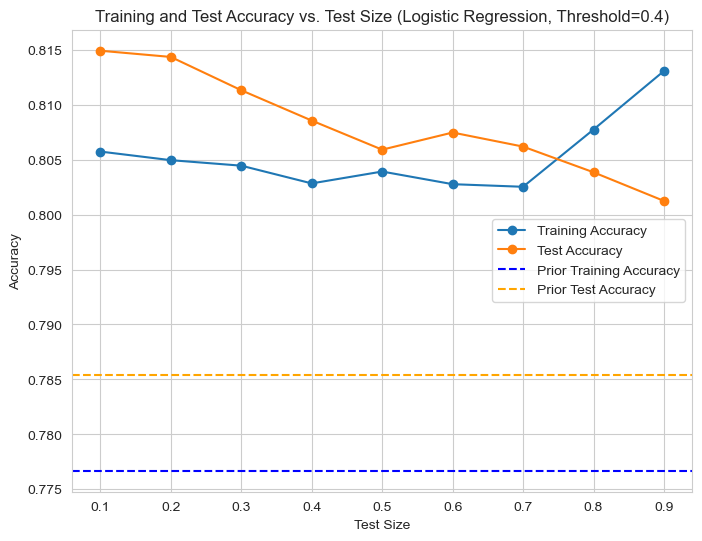

In [903]:
test_sizes = np.arange(0.1, 1, 0.1)

train_accuracies = []
test_accuracies = []

X, y = identify_relevant_data(best_education_method, best_marriage_method, best_period)
X=X[:,best_features]

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    scaler = eval(best_scaler)()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression(max_iter=best_n_iter, tol=best_eps, solver='liblinear', penalty=best_Penalty, class_weight=class_weighted)
    model.fit(X_train_scaled, y_train)

    y_prob_cv = cross_val_predict(model, X_train_scaled, y_train, cv=5, method='predict_proba')[:, 1]

    y_pred_cv = (y_prob_cv >= best_Threshold).astype(int)

    train_accuracy = accuracy_score(y_train, model.predict(X_train_scaled))
    test_accuracy = accuracy_score(y_test, (model.predict_proba(X_test_scaled)[:, 1] >= best_Threshold).astype(int))

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.figure(figsize=(8, 6))
plt.plot(test_sizes, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(test_sizes, test_accuracies, label='Test Accuracy', marker='o')
plt.axhline(y=train_acc_prior, color='blue', linestyle='dashed', label='Prior Training Accuracy')
plt.axhline(y=test_acc_prior, color='orange', linestyle='dashed', label='Prior Test Accuracy')
plt.xlabel('Test Size')
plt.ylabel('Accuracy')
plt.title(f'Training and Test Accuracy vs. Test Size (Logistic Regression, Threshold={best_Threshold})')
plt.legend()
plt.grid(True)
plt.show()

First you can see that in general our accuracy is higher than the prior model!
<br>
The graph highlights the target variable imbalance, where approximately 80% of our data belongs to the non-default class. As we see for high test percentages (low train percentages), the training accuracy is vary high, while for low test percentages, the test accuracy is very high. This pattern may suggest that certain datasets had an overwhelming majority for one particular class. To address the data imbalance, a test-to-training ratio of 70:30 appears to be the most suitable choice. This ratio ensures the presence of both classes in each dataset, mitigating the impact of class imbalance and leading to higher overall accuracy and also give best accurcy (between 0.3-0.7).

# The Weights of the Lasso Coefficients

In [1006]:
coefficients = best_model.coef_[0]
coefficients_dic = {}

for i, coef in enumerate(coefficients):
    coefficients_dic[df_ed2_ma2.columns[best_features[i]]] = coef

sorted_coefficients = sorted(coefficients_dic.items(), key=lambda x: x[1], reverse=True)

for feature, coef in sorted_coefficients:
    if coef == 0:
        print(f"\033[91m{feature}: {coef:.0f}\033[0m")
    else:
        print(f"{feature}: {coef:.5f}")


pay_1_2: 0.80847
pay_5_1: 0.73075
pay_5_2: 0.59207
pay_3_3: 0.50126
avg_months_late: 0.49706
std_bill_amt: 0.44388
pay_2_6: 0.38939
bill_amt5: 0.36945
pay_5_-3: 0.29921
pay_4_1: 0.24588
pay_2_-3: 0.23117
pay_2_0: 0.17020
pay_4_2: 0.16977
pay_1_0: 0.15867
pay_3_1: 0.14000
is_late: 0.11099
pay_1_-3: 0.08937
age: 0.07458
expenses_credit_limit_ratio_3_mts: 0.07417
marriage_method_2_married: 0.06394
pay_4_-1: 0.05608
late_count: 0.05587
pay_3_-3: 0.05313
education_method_2_others: 0.04698
education_method_2_2: 0.02316
pay_3_6: 0.01964
bill_amt2: 0.01800
bill_amt4: 0.01104
bill_amt3: 0.00570
pay_2_-2: 0.00480
default: 0.00177
pay_1_7: 0
pay_5_5: 0
pay_5_4: 0
pay_4_4: 0
pay_1_3: 0
pay_4_3: 0
pay_4_0: 0
std_pay_amt: 0
pay_1_8: 0
pay_5_6: 0
pay_4_6: 0
pay_1_5: 0
pay_3_5: 0
pay_4_-3: 0
pay_3_4: 0
pay_1_4: 0
pay_3_-2: 0
pay_5_7: 0
pay_4_7: 0
pay_3_0: 0
pay_5_0: 0
pay_2_7: 0
pay_5_-2: 0
pay_2_5: 0
pay_1_6: 0
education_method_2_graduate school: 0
pay_3_7: 0
pay_3_8: -0.00428
pay_3_2: -0.02269
pay_4

We observe that some features were assigned zero coefficients, indicating that they have little to no impact on the model's predictions. Interestingly, many of these features were also deemed to have low importance in the previous analysis. As for the non-zero coefficients, we notice that they have both positive and negative values. For instance, the feature "avg_months_late" has a positive coefficient, indicating that an increase in its value positively influences the likelihood of the predicted outcome. On the other hand, features with negative coefficients, such as "limit_bal" negatively impact the prediction, where higher values of "limit_bal" correspond to a lower probability of the predicted outcome. 

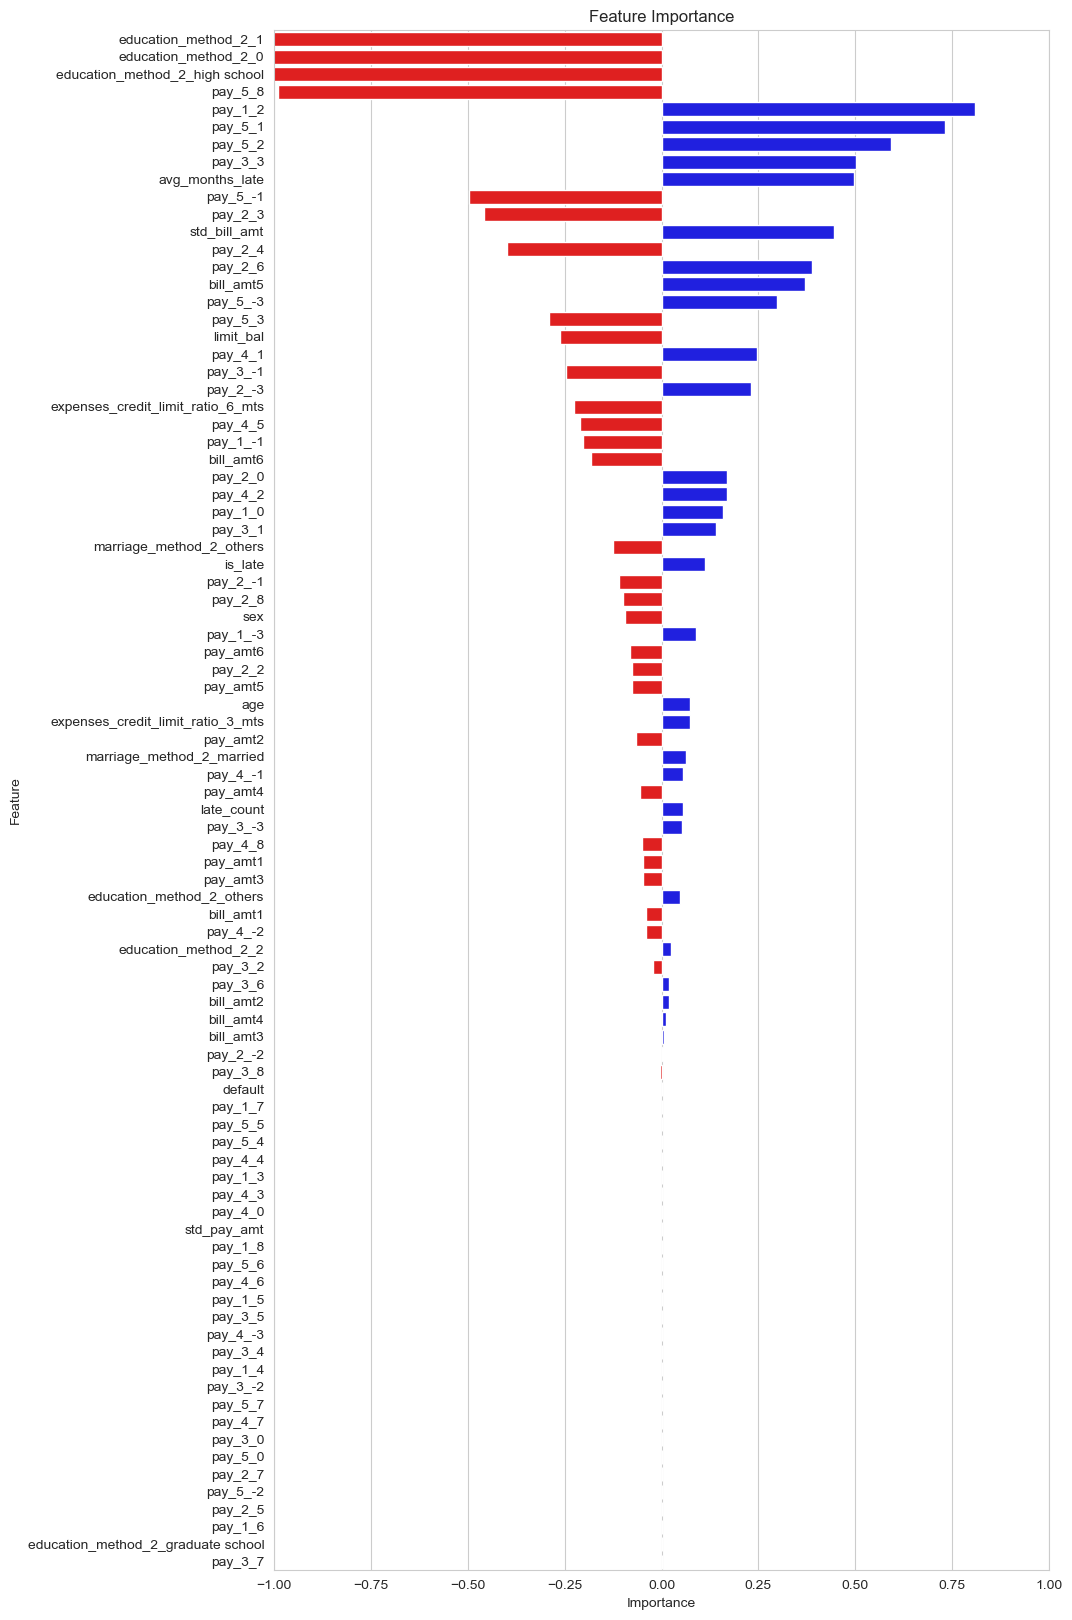

In [1003]:
coefficients_df = pd.DataFrame(sorted_coefficients)

coefficients_df = pd.DataFrame(sorted_coefficients, columns=['Feature', 'Importance'])

# Create a color palette for the plot
colors = ['red' if coef<0 else 'blue' for coef in coefficients_df['Importance']]

# Create the barplot with the correct orientation
plt.figure(figsize=(10, 20))
sns.barplot(x='Importance', y='Feature', data=coefficients_df, palette=colors, orient='h')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.xlim(-1, 1)  # Adjust the x-axis limits to match the range of importance values
plt.show()

# PCA
We tried to apply PCA to our best model for analysis . The reason we chose to do this is of course to examine the effect of reducing the dimension on the quality of the model and also to visually see our data.

Now we have 88 features
n_components: 1
Test F1 Score: 0.6844149038
Test Accuracy: 0.7805985471
---------------------------------------------
n_components: 2
Test F1 Score: 0.6844149038
Test Accuracy: 0.7805985471


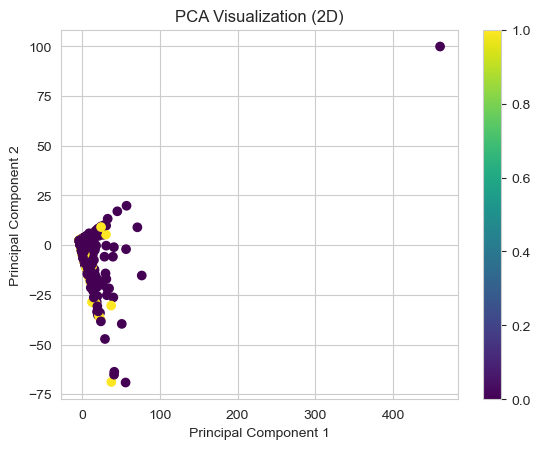

---------------------------------------------
n_components: 3
Test F1 Score: 0.6844149038
Test Accuracy: 0.7805985471


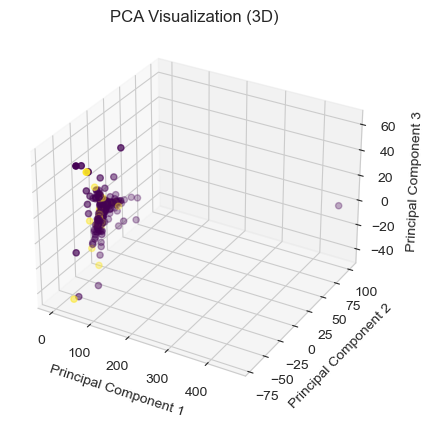

---------------------------------------------
n_components: 8
Test F1 Score: 0.6844821935
Test Accuracy: 0.7797299431
---------------------------------------------
n_components: 12
Test F1 Score: 0.7800191970
Test Accuracy: 0.8038139608
---------------------------------------------
n_components: 17
Test F1 Score: 0.7788441577
Test Accuracy: 0.8029453569
---------------------------------------------
n_components: 20
Test F1 Score: 0.7800930421
Test Accuracy: 0.8040903348
---------------------------------------------
n_components: 30
Test F1 Score: 0.7838009553
Test Accuracy: 0.8042087808
---------------------------------------------
n_components: 40
Test F1 Score: 0.7838808795
Test Accuracy: 0.8025900190
---------------------------------------------
n_components: 50
Test F1 Score: 0.7853931818
Test Accuracy: 0.8021162350
---------------------------------------------
n_components: 70
Test F1 Score: 0.7850308059
Test Accuracy: 0.8023531270
---------------------------------------------


In [919]:
X, y = identify_relevant_data(best_education_method, best_marriage_method, best_period)
X = X[:, best_features]

print("Now we have",X.shape[1],'features')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

scaler = eval(best_scaler)()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##Since there are 88 pitches at the moment, we will try to use the following values:

n_components_list = [1, 2, 3,8,12,17,20,30,40,50,70]
for n_components in n_components_list:
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    model = LogisticRegression(max_iter=best_n_iter, tol=best_eps, solver='liblinear', penalty=best_Penalty, class_weight=class_weighted)
    model.fit(X_train_pca, y_train)

    y_prob_test = model.predict_proba(X_test_pca)[:, 1]
    y_pred_test = (y_prob_test >= best_Threshold).astype(int)

    f1_score_test = f1_score(y_test, y_pred_test,average='weighted')
    accuracy_test = model.score(X_test_pca, y_test)

    print("n_components:", n_components)
    print("Test F1 Score: {:.10f}".format(f1_score_test))
    print("Test Accuracy: {:.10f}".format(accuracy_test))

    if n_components == 2:
        plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title('PCA Visualization (2D)')
        plt.colorbar()
        plt.show()
    elif n_components == 3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c=y_train, cmap='viridis')
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        ax.set_zlabel('Principal Component 3')
        ax.set_title('PCA Visualization (3D)')
        plt.show()

    print("---------------------------------------------")


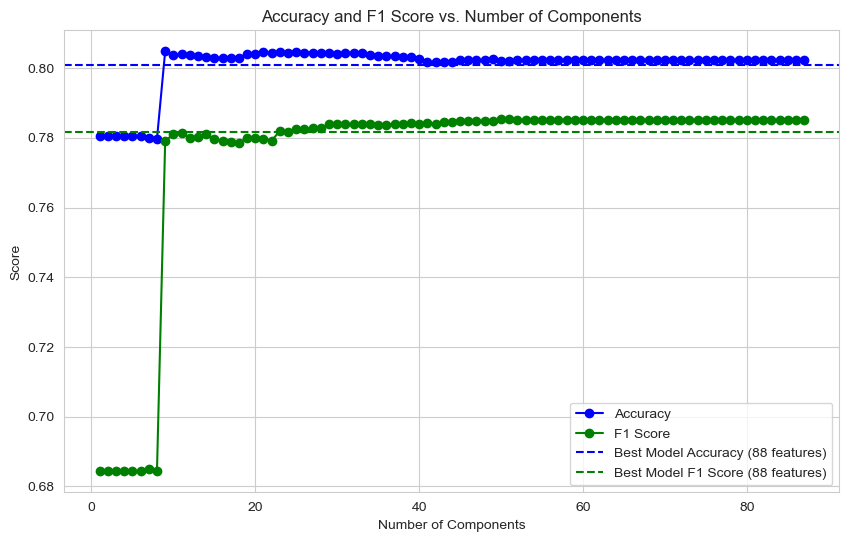

In [930]:
X, y = identify_relevant_data(best_education_method, best_marriage_method, best_period)
X = X[:, best_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

scaler = eval(best_scaler)()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

accuracy_scores = []
f1_scores = []

for n_components in range(1, 88):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    model = LogisticRegression(max_iter=best_n_iter, tol=best_eps, solver='liblinear', penalty=best_Penalty, class_weight=class_weighted)
    model.fit(X_train_pca, y_train)

    y_prob_test = model.predict_proba(X_test_pca)[:, 1]
    y_pred_test = (y_prob_test >= best_Threshold).astype(int)

    accuracy_test = model.score(X_test_pca, y_test)
    f1_score_test = f1_score(y_test, y_pred_test, average='weighted')

    accuracy_scores.append(accuracy_test)
    f1_scores.append(f1_score_test)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 88), accuracy_scores, label='Accuracy', marker='o', linestyle='-', color='blue')
plt.plot(range(1, 88), f1_scores, label='F1 Score', marker='o', linestyle='-', color='green')

# Dotted line for the best model's accuracy
plt.axhline(y=accuracy_best_model, color='blue', linestyle='--', label='Best Model Accuracy (88 features)')
# Dotted line for the best model's F1 score
plt.axhline(y=F1_score_best_model, color='green', linestyle='--', label='Best Model F1 Score (88 features)')

plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('Accuracy and F1 Score vs. Number of Components')
plt.legend()
plt.grid(True)
plt.show()


It can be seen that for n_components smaller than 12 the accuracy and f1 are lower than our model now. But as n_components increase, it can be seen that the indices improve slightly from our model.

#Since we did not implement the code together, we will leave the model as it is at the moment.

## AdaBoost with Logistic Regression
In try to improve our classification model, we will implement AdaBoost, an ensemble learning technique that combines multiple weak classifiers to create a strong classifier. We will use Logistic Regression as our base classifier, which has shown promising results in previous analyses.
We will run the Basic and Weak Model, which consists of a basic and weak model without any modifications to the hyperparameters, except for the relevant dataset and the best scaler.

Calculates performance metrics of the best AdaBoost model with this hyperparamters.

In [940]:
X, y = identify_relevant_data(best_education_method, best_marriage_method, best_period)

scaler = eval(best_scaler)()

total_weighted_f1 = 0
weighted_recall = 0
weighted_precision = 0
weighted_accuracy = 0

adaboost_fpr = []
adaboost_tpr = []
adaboost_roc_auc = []

for fold in range(5):
    indices = np.random.permutation(X.shape[0])
    idx_train, idx_val = indices[:int(0.7 * X.shape[0])], indices[int(0.7 * X.shape[0]):]
    X_train, X_val = X[idx_train], X[idx_val, :]
    y_train, y_val = y[idx_train], y[idx_val]

    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    adaboost_model = AdaBoostClassifier(base_estimator=LogisticRegression())
    adaboost_model.fit(X_train_scaled, y_train)

    y_pred = adaboost_model.predict(X_val_scaled)
    
    total_weighted_f1 += f1_score(y_val, y_pred, average='weighted')
    weighted_recall += recall_score(y_val, y_pred, average='weighted')
    weighted_precision += precision_score(y_val, y_pred, average='weighted')
    weighted_accuracy += accuracy_score(y_val, y_pred)

weighted_f1 = total_weighted_f1 / 5
weighted_recall /= 5
weighted_precision /= 5
weighted_accuracy /= 5

dic_results_adaboost_best = {
    'F1': weighted_f1,
    'recall': weighted_recall,
    'precision': weighted_precision,
    'accuracy': weighted_accuracy
}

def color_value(value, best_value):
    if value > best_value:
        return '\033[92m' + str(value) + '\033[0m'  # Green color
    elif value < best_value:
        return '\033[91m' + str(value) + '\033[0m'  # Red color
    else:
        return str(value)

# Create a table displaying performance metrics with colored values
table_Ada_weak_learner = [
    ['F1', color_value(weighted_f1, F1_score_best_model)],
    ['recall', color_value(weighted_recall, recall_best_model)],
    ['precision', color_value(weighted_precision, precision_best_model)],
    ['accuracy', color_value(weighted_accuracy, accuracy_best_model)]
]
headers = ["Metric", "Value"]
table_Ada_weak_learner = tabulate(table_Ada_weak_learner, headers, tablefmt="grid")
headline = "Performance Metrics for AdaBoost with Logistic Regression - Basic and Weak Model"
print(headline)
print(table_Ada_weak_learner)

Performance Metrics for AdaBoost with Logistic Regression - Basic and Weak Model
+-----------+----------+
| Metric    |    Value |
+===========+==========+
| F1        | 0.770484 |
+-----------+----------+
| recall    | 0.804761 |
+-----------+----------+
| precision | 0.78202  |
+-----------+----------+
| accuracy  | 0.804761 |
+-----------+----------+




We observe that all model performance metrics, except for the F1 score, show improvement. It is important to note that the increase in performance is relatively minor, showing a difference of less than 0.001. However, as previously mentioned, we give greater importance to the F1 score due to the imbalance in the target variable. The F1 score provides a balanced measure of both precision and recall, making it a critical metric for our analysis. Therefore, we will proceed with the logistic regression model we identified earlier, as it offers the best F1 score.

## SVM
Initially, we attempted to run an SVM model- however, due to the large size of our dataset, the process did not complete even after running for 5 hours. Consequently, we decided to apply the PCA algorithm to reduce the dimensionality of the data. Unfortunately, even with PCA, the model failed to finish running after approximately 4 hours, leading us to terminate the attempt. We did it because considered exploring other model with different assumptions.

# BEST MODEL

#### As we have seen the best model was and remains the logistic regression model!

In [1034]:
features_str = ', '.join(map(str, models_summery_final['features'][1]))
best_model_summery_dic= {'Model_type':models_summery_final['Model_type'][1],
                     'Features_Selection_method':models_summery_final['Features_Selection_method'][1],
                     'Scaler_method':models_summery_final['Scaler_method'][1],
                     'education_method':all_education_methods[models_summery_final['education_method'][1]-1],
                     'marriage_method':all_marriage_methods[models_summery_final['marriage_method'][1]-1],
                     'features':features_str,
                     'n_iter':models_summery_final['hyper_parameters'][1]['n_iter'],
                     'eps':models_summery_final['hyper_parameters'][1]['Eps'],
                     'Penalty':models_summery_final['hyper_parameters'][1]['Penalty'],
                     'Threshold':models_summery_final['hyper_parameters'][1]['Threshold'],
                     'imbalance':models_summery_final['hyper_parameters'][1]['imbalance'],
                     'Period':models_summery_final['Period'][1],
                     'F1_score':models_summery_final['F1_score'][1],
                     'recall':models_summery_final['Evaluation_methods'][1]['recall'],
                     'precision':models_summery_final['Evaluation_methods'][1]['precision'],
                     'accuracy':models_summery_final['Evaluation_methods'][1]['accuracy'],
                     'roc_auc':models_summery_final['Evaluation_methods'][1]['roc_auc']}
best_model_summery = pd.DataFrame([best_model_summery_dic])
best_model_summery

Model_type Features_Selection_method Scaler_method education_method  \
0         LG         Forward Selection  RobustScaler   KNN Imputation   

  marriage_method                                           features  n_iter  \
0   LG Imputation  22, 33, 78, 17, 27, 7, 75, 70, 52, 8, 10, 81, ...    2000   

      eps Penalty  Threshold imbalance  Period  F1_score    recall  precision  \
0  0.0001      l1        0.4   Regular       6  0.781568  0.800924    0.77915   

   accuracy   roc_auc  
0  0.800924  0.742696

## Thank you very much for a no less than perfect course!